# Welcome! - AirBnB / Zillow Real Estate Recommendation

## Goal

We have prepared our discoveries and conclusions (recommendation + actions), which should help the real-estate investor to decide <ins>*which zip codes are the most profitable on short-term rentals within New York City (NYC)*</ins>.


## Datasets

Two core datasets are available to us in order to derive useful insights:

| Dataset Name | Dataset Type  | Description  |
|:--------------|:---------------|:--------------|
| AirBnB       | Revenue  | Leverages rent information of properties through AirBnB   |
| Zillow      | Cost  | Provides estimate value (median price) of 2-Bedroom properties over time  |


Two helper datasets has been augmented to our data preprocessing step:

| Dataset Name | Dataset Type  | Description  |
|:--------------|:---------------|:--------------|
| State ID Dataset | Validation  | Utilized for sanity check in ensuring 2-letter state ID's are not erroneous |
| NYC By Natives Site | Validation | Utilized for attempting a sanity on NYC zipcodes | 

## Assumptions

1. The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for).
2. The time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now).
3. The number of reviews are an estimate
4. A 2-bedroom property is deemed to be profitable regardless of the number of beds avaiable and the number of occupants the host permits to stay in his property (i.e., if the host permits only 1 person to stay in a 2-bedroom apartment which has 4 beds available, the property is still deemed to generate high profit) 
5. All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale.)

# Global Dependencies Management

This section deals with loading and setting up dependencies and data that are relevant for our data analysis.  

## Libraries

All data science libraries pivotal to our data analysis are loaded into the notebook. 

In [186]:
# Enable Autorelead
%load_ext autoreload
%autoreload

# Package Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from scipy.stats import ttest_ind, probplot
from os import path, environ
from datetime import datetime

# Append sys.poth with custom paths to modules in different directories 
UTIL_MODPATH = path.join(environ.get('PROJ_HOME'), 'util')
if UTIL_MODPATH not in sys.path: sys.path.insert(1, path.join(environ.get('PROJ_HOME'), 'util'))

# Custom Module Imports
from augment_data import ExternDataController as EDC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings 

Backups, Markdown table and Seaborn plot styles are configured here.  

### Seaborn Style 

Enable dark-grid graph styles:

In [187]:
sns.set_style('darkgrid')

### Markdown Table

Left-align markdown tables:

In [188]:
%%html
<style>
table {float:left}
</style>

### Backup Flag

Set this flag to true to backup relevant processed datasets, which are tagged with this flag in the *backup_dataset()* utility function call arguments, as per their backup path (paths are mentioned in the *Dataset Paths* section)

In [189]:
BACKUP_FLAG = False             # <---------- Set your option here 
BACKUP_FLAG = not BACKUP_FLAG  # the 'ignore' argument in utility function takes the opposite

## Data Quality Management

The datasets to be loaded are processed, as well as their associated file-path strings are managed. Please feel free to update file paths to the datasets in this section.  

### Dataset Paths

Configure Core Datasets' (Cost + Revenue) and Helper Datasets' (State IDs) paths:  

In [190]:
# Core Dataset Paths
ZILLOW_DS_PATH = path.join("../data/zillow", "Zip_Zhvi_2bedroom.csv")
AIRBNB_DS_PATH = path.join("../data/airbnb", "listings.csv") 

# Helper Dataset Paths
STATES_DS_PATH = path.join("../data/states", "state_id.txt")
STATES_DS_URL = "https://people.sc.fsu.edu/~jburkardt/datasets/states/state_id.txt"
NYC_ZIP_URL = "https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php"

# Backup Preprocessing Path
ZILLOW_DS_BACKUP_PATH = path.join("../data/proc-backup", "zillow-cdf-back.csv")
ZILLOW_DS_NONFILTERED_BACKUP_PATH = path.join("../data/proc-backup", "zillow-cdf-nonfilter-back.csv")
AIRBNB_DS_BACKUP_PATH = path.join("../data/proc-backup", "airbnb-rdf-back.csv")
AIRBNB_DS_UNCOMMON_ZIP_BACKUP_PATH = path.join("../data/proc-backup", "airbnb-rdf-uncommonzip-back.csv") 

# legacy Paths
# NYC_ZIP_URL = "https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm" # Not updated zipcode list 

### Dataset Load 

#### Utility Functions

The following utility functions useful for readability; they would be packaged into their respective modules if time permits.   

In [191]:
def lowercase_set(lst):
    """Computes a set of lowercased column names
    Args: 
        lst: List of column-names (which are strings)
        
    Returns:
        Set: Lowercased column-names
    """
    return set(list(map(str.lower, lst)))

In [192]:
def nunique_plot(dataset, dname, threshold):
    """Provides the dataset columns whose number of unique-elements are below (less than = lt) the predefined threshold
    Args:
        dataset: DataFrame pertaining to AirBnB/Zillow dataset
        threshold: Positive integer between [0.1, 1]; indicates the fraction of rows of the input dataset
    """
    dataset = dataset.copy()
    nrow = dataset.shape[0]
    
    df_uniq = pd.merge(                                                          # Join results of nunique + dtypes 
        pd.DataFrame(dataset.nunique(), columns=['number_of_unique_elements']), 
        pd.DataFrame(dataset.dtypes, columns=['column_dtype']),
        left_index=True,
        right_index=True
    ).query(                                                                     # Filter nunique based on threshold 
        'number_of_unique_elements < {} * {}'.format(threshold, nrow)
    ).apply(                                                                     # Convert 'column_dtype' values to string 
        lambda x: x.astype('str') if x.name == 'column_dtype' else x
    ).sort_values(                                                               # Sort based on (nunique, dtypes)
        ['number_of_unique_elements', 'column_dtype'], 
        ascending=[True, False]
    )
    
    # Create a horizontal plot
    plt.figure(figsize=(20, 8))
    ax = sns.barplot(x='number_of_unique_elements', y=df_uniq.index, hue='column_dtype', dodge=False, data=df_uniq)
    
    # Add text to horizontal bars
    for rownum, row in zip(range(len(df_uniq)), df_uniq.itertuples()):
        ax.text(
            row.number_of_unique_elements, 
            rownum, 
            row.number_of_unique_elements, 
            color='black', 
            va='center',
            fontsize=15,
        )
    
    #
    plt.xlabel('Number of Unique Values')
    plt.ylabel('Dataset Columns')
    plt.title(
        '{} Dataset Columns, with Number of Unique Elements < {} % of Number of Rows in the Dataset'.format(
            dname, int(threshold*100)
        )
    )
    plt.legend(title='Column DType')
    plt.show()
    
    return df_uniq

In [193]:
def categorize(dataset, columnlist):
    """Converts the dtypes of the dataset's columns to their corresponding categorical type  
    Args:
        dataset: DataFrame pertaining to AirBnB/Zillow dataset
        columnlist: list of column names (as strings), to convert
    
    Returns:
        cat_dataset: DataFrame whose column names were passed are now categorized
    """
    dataset = dataset.copy()
    
    for x in columnlist: dataset[x] = dataset[x].astype('category')
    
    return dataset 

####  AirBnB Dataset

The following columns have been picked up for the AirBnB dataset. Columns that did not find a place in this analysis either had zero variance (same valued columns) or irrelevant information  for our analysis (eg. host_list_id). 

In [194]:
revenue_df_raw = pd.read_csv(
    AIRBNB_DS_PATH,
    usecols=lambda col: col.lower() in lowercase_set([
        'id',
        'zipcode',
        'property_type',
        'room_type',
        'accommodates',
        'beds',
        'bathrooms',
        'bedrooms',
        'amenities',
        'neighbourhood_cleansed',
        'neighbourhood_group_cleansed',
        'state',
        'latitude',
        'longitude',
        'is_location_exact',
        'price',
        'number_of_reviews',
        'review_scores_rating',
        'review_scores_accuracy',
        'review_scores_cleanliness',
        'review_scores_location',
        'review_scores_value',
        'reviews_per_month',
        'availability_30',
        'availability_60',
        'availability_90',
        'availability_365',
        'first_review',
        'last_review'
    ]),
    low_memory=False
)

revenue_df_raw.head()

id neighbourhood_cleansed neighbourhood_group_cleansed state zipcode  \
0  2539             Kensington                     Brooklyn    NY   11218   
1  2595                Midtown                    Manhattan    NY   10018   
2  3647                 Harlem                    Manhattan    NY   10027   
3  3831           Clinton Hill                     Brooklyn    NY   11238   
4  5022            East Harlem                    Manhattan    NY   10029   

   latitude  longitude is_location_exact property_type        room_type  ...  \
0  40.64749  -73.97237                 f     Apartment     Private room  ...   
1  40.75362  -73.98377                 f     Apartment  Entire home/apt  ...   
2  40.80902  -73.94190                 t     Apartment     Private room  ...   
3  40.68514  -73.95976                 t   Guest suite  Entire home/apt  ...   
4  40.79851  -73.94399                 t     Apartment  Entire home/apt  ...   

   availability_365  number_of_reviews  first_review  last_review  \
0               365                  9    2015-12-04   2018-10-19   
1               355                 45    2009-11-21   2019-05-21   
2               365                  0           NaN          NaN   
3               194                270    2014-09-30   2019-07-05   
4                 0                  9    2012-03-20   2018-11-19   

  review_scores_rating review_scores_accuracy  review_scores_cleanliness  \
0                 98.0                   10.0                       10.0   
1                 95.0                   10.0                        9.0   
2                  NaN                    NaN                        NaN   
3                 90.0                   10.0                        9.0   
4                 93.0                   10.0                        9.0   

   review_scores_location  review_scores_value  reviews_per_month  
0                    10.0                 10.0               0.21  
1                    10.0                  9.0               0.38  
2                     NaN                  NaN                NaN  
3                    10.0                  9.0               4.64  
4                     9.0                 10.0               0.10  

[5 rows x 29 columns]

In [195]:
revenue_df_raw.shape

(48895, 29)

In [196]:
revenue_df_raw.info(verbose=True, null_counts=True , memory_usage='deep') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            48895 non-null  int64  
 1   neighbourhood_cleansed        48895 non-null  object 
 2   neighbourhood_group_cleansed  48895 non-null  object 
 3   state                         48889 non-null  object 
 4   zipcode                       48378 non-null  object 
 5   latitude                      48895 non-null  float64
 6   longitude                     48895 non-null  float64
 7   is_location_exact             48895 non-null  object 
 8   property_type                 48895 non-null  object 
 9   room_type                     48895 non-null  object 
 10  accommodates                  48895 non-null  int64  
 11  bathrooms                     48839 non-null  float64
 12  bedrooms                      48873 non-null  float64
 13  b

From a quick glance, the revenue dataset is known to have missing data for some columns, interestingly for the one of the most important attributes, zipcode. Memory can be also be saved This will be handled in the following sections.  

##### Memory Optimizations by Correcting Column Data Types

As dtype inference may not be appropiate upon reading the AirBnB dataset, memory optimizations can be attained by converting the dtype of affected columns to their respective optimal dtypes.

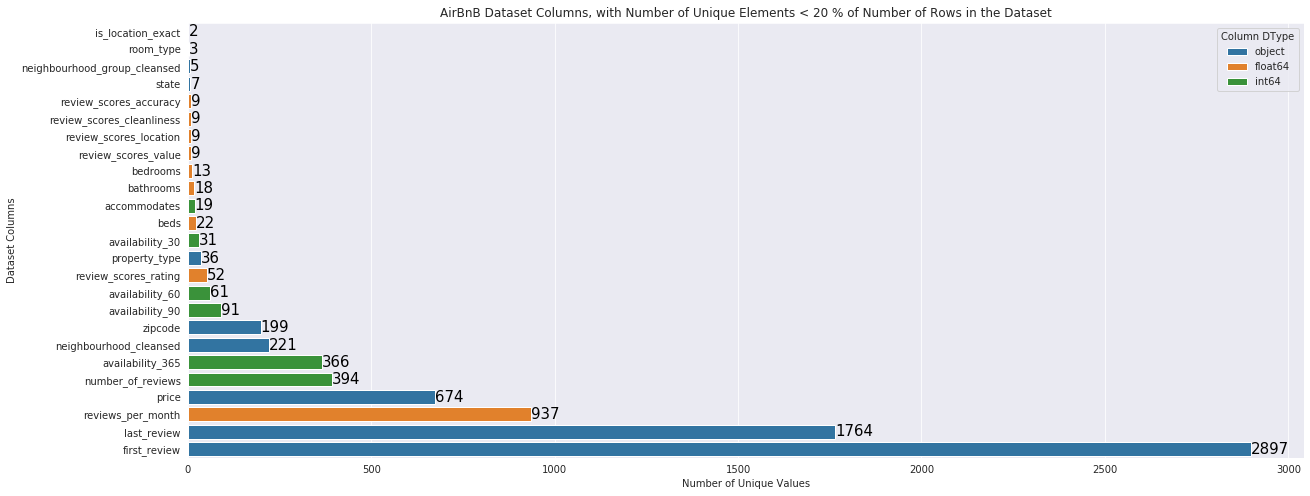

In [197]:
rdf_nunique = nunique_plot(revenue_df_raw, 'AirBnB', 0.20)

It is clear from the graph above, that several columns (listed below) have the memory-consuming *object* data types although they contain a set of few unique values.

In [198]:
rdf_nunique.loc[rdf_nunique.column_dtype == 'object', ['number_of_unique_elements']]

number_of_unique_elements
is_location_exact                                     2
room_type                                             3
neighbourhood_group_cleansed                          5
state                                                 7
property_type                                        36
zipcode                                             199
neighbourhood_cleansed                              221
price                                               674
last_review                                        1764
first_review                                       2897

This paves the way of converting the dtypes of these columns above (except the *price* column) to *categorical* type, which will save memory for further analysis. 

In [199]:
revenue_df_raw = categorize(
    revenue_df_raw, 
    [x for x in rdf_nunique.loc[rdf_nunique.column_dtype == 'object'].index.values if x !='price']
)

In [200]:
revenue_df_raw.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   id                            48895 non-null  int64   
 1   neighbourhood_cleansed        48895 non-null  category
 2   neighbourhood_group_cleansed  48895 non-null  category
 3   state                         48889 non-null  category
 4   zipcode                       48378 non-null  category
 5   latitude                      48895 non-null  float64 
 6   longitude                     48895 non-null  float64 
 7   is_location_exact             48895 non-null  category
 8   property_type                 48895 non-null  category
 9   room_type                     48895 non-null  category
 10  accommodates                  48895 non-null  int64   
 11  bathrooms                     48839 non-null  float64 
 12  bedrooms                      48873 non-null  

After applying the dtype corrections, we are working with 42% less memory. These gains wil be significant as the dataset scales to millions or billions of rows. The dtype of the *price* column seems to be incorrectly inferred due to the dollar symbol, as shown below:  

In [201]:
revenue_df_raw.price.head()

0    $149.00
1    $225.00
2    $150.00
3     $89.00
4     $80.00
Name: price, dtype: object

The *price* column will be cleaned in the upcoming sections.

#### Zillow Dataset

In [202]:
# Load the zillow dataset
cost_df_raw = pd.read_csv(
    ZILLOW_DS_PATH, 
    usecols=lambda col: col.lower() not in lowercase_set(['RegionID', 'City', 'Metro', 'CountyName']) # exclude columns
)

cost_df_raw.head()

RegionName State  SizeRank   1996-04   1996-05   1996-06   1996-07  \
0       10025    NY         1       NaN       NaN       NaN       NaN   
1       60657    IL         2  167700.0  166400.0  166700.0  167200.0   
2       10023    NY         3       NaN       NaN       NaN       NaN   
3       60614    IL         4  195800.0  193500.0  192600.0  192300.0   
4       79936    TX         5   59100.0   60500.0   60900.0   60800.0   

    1996-08   1996-09   1996-10  ...  2016-09  2016-10  2016-11    2016-12  \
0       NaN       NaN       NaN  ...  1374400  1364100  1366300  1354800.0   
1  166900.0  166900.0  168000.0  ...   368600   370200   372300   375300.0   
2       NaN       NaN       NaN  ...  1993500  1980700  1960900  1951300.0   
3  192600.0  193600.0  195500.0  ...   398900   401200   403200   405700.0   
4   60300.0   60400.0   61200.0  ...    82400    82300    82400    82300.0   

   2017-01  2017-02  2017-03  2017-04  2017-05  2017-06  
0  1327500  1317300  1333700  1352100  1390000  1431000  
1   378700   381400   381800   382100   383300   385100  
2  1937800  1929800  1955000  2022400  2095000  2142300  
3   408300   408800   408000   410100   412200   412200  
4    82500    83200    83900    84100    83900    83700  

[5 rows x 258 columns]

In [203]:
# Dimensions of the dataset
cost_df_raw.shape

(8946, 258)

In [204]:
cost_df_raw.info(verbose=True, null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Data columns (total 258 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  8946 non-null   int64  
 1   State       8946 non-null   object 
 2   SizeRank    8946 non-null   int64  
 3   1996-04     6284 non-null   float64
 4   1996-05     6364 non-null   float64
 5   1996-06     6364 non-null   float64
 6   1996-07     6369 non-null   float64
 7   1996-08     6370 non-null   float64
 8   1996-09     6370 non-null   float64
 9   1996-10     6370 non-null   float64
 10  1996-11     6380 non-null   float64
 11  1996-12     6380 non-null   float64
 12  1997-01     6404 non-null   float64
 13  1997-02     6833 non-null   float64
 14  1997-03     6853 non-null   float64
 15  1997-04     6853 non-null   float64
 16  1997-05     6853 non-null   float64
 17  1997-06     6855 non-null   float64
 18  1997-07     6855 non-null   float64
 19  1997-08     6952 non-null 

From a quick glance, the *year-month* columns will need to be aggregated annually, which will done during the preprocessing phase.  

##### Memory Optimizations by Correcting Column Data Types 

The amount of memory that can be optimized for this dataset would not be significant, as evident from the plot below: 

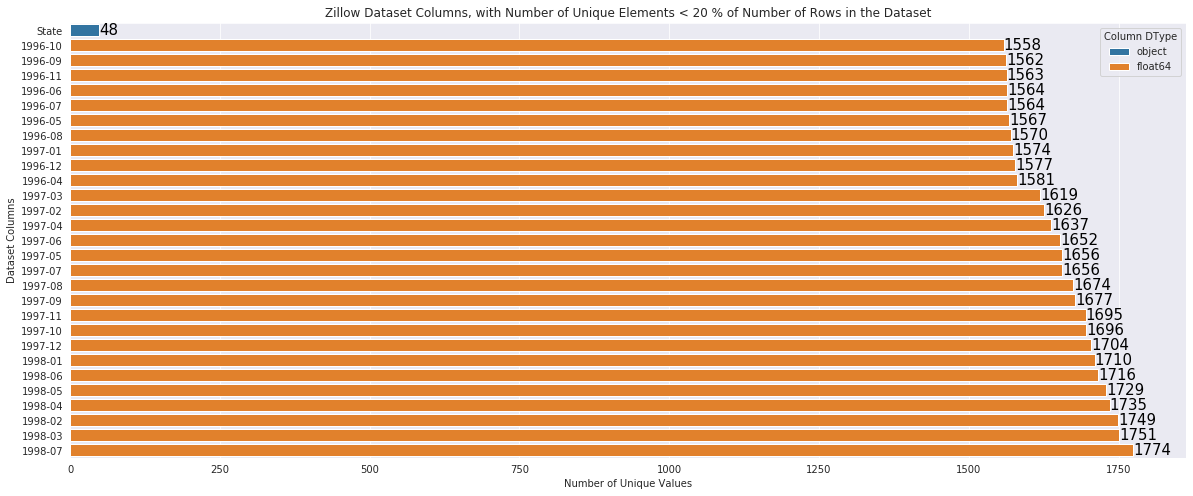

In [205]:
cdf_nunique = nunique_plot(cost_df_raw, 'Zillow', 0.20)

Only the *State* column dtype maybe categorized as follows: 

In [206]:
cost_df_raw = categorize(cost_df_raw, ['State'])

In [207]:
cost_df_raw.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Data columns (total 258 columns):
 #   Column      Dtype   
---  ------      -----   
 0   RegionName  int64   
 1   State       category
 2   SizeRank    int64   
 3   1996-04     float64 
 4   1996-05     float64 
 5   1996-06     float64 
 6   1996-07     float64 
 7   1996-08     float64 
 8   1996-09     float64 
 9   1996-10     float64 
 10  1996-11     float64 
 11  1996-12     float64 
 12  1997-01     float64 
 13  1997-02     float64 
 14  1997-03     float64 
 15  1997-04     float64 
 16  1997-05     float64 
 17  1997-06     float64 
 18  1997-07     float64 
 19  1997-08     float64 
 20  1997-09     float64 
 21  1997-10     float64 
 22  1997-11     float64 
 23  1997-12     float64 
 24  1998-01     float64 
 25  1998-02     float64 
 26  1998-03     float64 
 27  1998-04     float64 
 28  1998-05     float64 
 29  1998-06     float64 
 30  1998-07     float64 
 31  1998-08     float64 
 32  199

As it can be seen, trivial amounts of memory was saved from this process.

#### State IDs Dataset 

The state-ids dataset is first downloaded and placed at the *STATES_DS_PATH*.

In [208]:
# Download state_ids dataset if it doesn't exist
EDC.download(STATES_DS_URL, STATES_DS_PATH)

[.] ../data/states/state_id.txt already exists.


True

Then, a set of state-ids are generated from the dataset.  

In [209]:
states_set = set(pd.read_csv(STATES_DS_PATH, sep='\n', header=None, names=['stateids']).stateids.unique())
print(states_set)

{'CO', 'AL', 'IA', 'UT', 'GA', 'TX', 'OH', 'CA', 'LA', 'VT', 'KS', 'NV', 'WI', 'PA', 'CT', 'MN', 'MA', 'WY', 'ME', 'ID', 'ND', 'NH', 'PR', 'NC', 'NY', 'WV', 'SC', 'OK', 'TN', 'MD', 'MI', 'AR', 'HI', 'AZ', 'US', 'MT', 'IN', 'NE', 'NJ', 'OR', 'VA', 'NM', 'DC', 'MO', 'DE', 'KY', 'IL', 'WA', 'AK', 'FL', 'MS', 'RI', 'SD'}


In [210]:
len(states_set)

53

#### NYC Zipcodes Dataset 

The set of zipcodes specific to NYC can be attained from the website as follows:  

In [211]:
zipcodes_set = EDC.search_zipcodes(NYC_ZIP_URL)
print(zipcodes_set)

{'10458', '11693', '11420', '11360', '10452', '11358', '11415', '10154', '10123', '11213', '10461', '10028', '11375', '10112', '10020', '10470', '10039', '11371', '10475', '11106', '11412', '10045', '10460', '10155', '10171', '11422', '11369', '11432', '11421', '10031', '11435', '11426', '11235', '11206', '10280', '10024', '10468', '10121', '11241', '11219', '10023', '11363', '11237', '10177', '11379', '10303', '11364', '10007', '11212', '10032', '10010', '10022', '10055', '10107', '10013', '11222', '11249', '10176', '11378', '11234', '11433', '10474', '11204', '11366', '11692', '10060', '11252', '10158', '10456', '10301', '11208', '11233', '10090', '11413', '10036', '11417', '10467', '10472', '10281', '10011', '11434', '10162', '10003', '10098', '10166', '10001', '10466', '10175', '10128', '11209', '10120', '10041', '10311', '11361', '10167', '10095', '10309', '10270', '10473', '11236', '11372', '10015', '10009', '10014', '11374', '10169', '10279', '10106', '10018', '11224', '10111', 

In [212]:
len(zipcodes_set)

242

### Data Cleaning
Some preliminary exploratory data analysis is carried out to aid in cleaning the datasets.

#### Check for Erroneous State-Ids 

A utility function useful for validity check is as follows

In [213]:
#### Utility Functions

def isvalid(dataset, colname, valset):
    """Checks if the dataset's states column has valid values (eg. state-ids , zipcodes) 
    Args:
        dataset: DataFrame pertaining to AirBnB/Zillow dataset
        colname: Name of the dataset's state column
        valset: Set of state-ids used to verify the state-id values in the dataset  
    
    Returns:
        Boolean: False if the dataset column values are not valid
        err_states/None: List of potential erroneous values in dataset if validation check failed, else None returned 
    """
    dataset = dataset.copy()
    err_values = dataset[colname].apply(
        lambda value: value if value not in valset else np.nan                 # Store values that don't match in validation set
    ).dropna().unique().tolist()                                               # Drop nulls and get a unique list of mismatches 
        
    if not err_values: return (True, None)
    else: return (False, err_values)
    

The cost dataset does not seem to have any erroneous state-ids, as it can be inferred from below:

In [214]:
valid, err_states = isvalid(cost_df_raw, 'State', states_set)
valid, err_states

(True, None)

In [215]:
print(cost_df_raw.State.unique().tolist())

['NY', 'IL', 'TX', 'CA', 'FL', 'TN', 'NC', 'GA', 'DC', 'MD', 'MO', 'VA', 'NJ', 'OK', 'OH', 'AZ', 'KS', 'NM', 'WA', 'CT', 'NV', 'MA', 'PA', 'MI', 'CO', 'KY', 'OR', 'SC', 'IN', 'ND', 'AR', 'AL', 'MN', 'DE', 'MS', 'ID', 'MT', 'WI', 'HI', 'UT', 'LA', 'RI', 'IA', 'NE', 'WY', 'AK', 'NH', 'WV']


The revenue dataset seems to have 1 erroneous and 3 incorrectly abbreviated state-ids: 

In [216]:
valid, err_states = isvalid(revenue_df_raw, 'state', states_set)
valid, err_states

(False, ['Ny', 'ny', 'MP', 'New York '])

The rows that span these states ids are as follows: 

In [217]:
revenue_df_raw[revenue_df_raw.state.isin(err_states)]

id neighbourhood_cleansed neighbourhood_group_cleansed  \
4583    3205292            Boerum Hill                     Brooklyn   
6269    4581788           Williamsburg                     Brooklyn   
8415    6462513     Bedford-Stuyvesant                     Brooklyn   
9857    7582706     Financial District                    Manhattan   
18876  14982907             St. Albans                       Queens   
36557  29061711         Hell's Kitchen                    Manhattan   
37637  29849903     Financial District                    Manhattan   
38051  30059579             St. Albans                       Queens   
39446  30739988                Midtown                    Manhattan   
39454  30744543         Queens Village                       Queens   
40861  31759546        Upper West Side                    Manhattan   
48391  36235150           Williamsburg                     Brooklyn   

           state zipcode  latitude  longitude is_location_exact property_type  \
4583          Ny   11217  40.68823  -73.98604                 t     Apartment   
6269          ny   11211  40.71370  -73.94378                 f     Apartment   
8415          MP   11221  40.68521  -73.93707                 t     Apartment   
9857          ny   10004  40.70406  -74.01227                 f     Apartment   
18876         ny   11434  40.68692  -73.76832                 f     Townhouse   
36557         Ny     NaN  40.76177  -73.99426                 f   Condominium   
37637         Ny   10005  40.70731  -74.00871                 f     Apartment   
38051         Ny   11412  40.69866  -73.76759                 f         House   
39446         Ny   10022  40.75816  -73.97004                 f     Apartment   
39454         Ny   11427  40.72348  -73.75269                 f     Apartment   
40861         Ny   10025  40.80153  -73.96550                 f     Apartment   
48391  New York    11211  40.71232  -73.94220                 t     Apartment   

             room_type  ...  availability_365  number_of_reviews  \
4583   Entire home/apt  ...                54                 12   
6269      Private room  ...                 0                  0   
8415      Private room  ...                 0                115   
9857   Entire home/apt  ...                 0                  0   
18876     Private room  ...               174                 74   
36557  Entire home/apt  ...                83                  0   
37637  Entire home/apt  ...               107                  0   
38051     Private room  ...               365                  0   
39446  Entire home/apt  ...                 0                  3   
39454  Entire home/apt  ...                66                 41   
40861  Entire home/apt  ...                74                  0   
48391  Entire home/apt  ...               340                  1   

       first_review  last_review review_scores_rating review_scores_accuracy  \
4583     2016-03-15   2016-10-24                100.0                   10.0   
6269            NaN          NaN                  NaN                    NaN   
8415     2015-05-26   2019-05-25                 92.0                    9.0   
9857            NaN          NaN                  NaN                    NaN   
18876    2016-09-14   2019-05-11                 95.0                   10.0   
36557           NaN          NaN                  NaN                    NaN   
37637           NaN          NaN                  NaN                    NaN   
38051           NaN          NaN                  NaN                    NaN   
39446    2018-12-26   2019-01-01                 87.0                   10.0   
39454    2019-01-02   2019-06-20                 97.0                   10.0   
40861           NaN          NaN                  NaN                    NaN   
48391    2019-07-07   2019-07-07                100.0                   10.0   

       review_scores_cleanliness  review_scores_location  review_scores_value  \
4583                        

After a quick online verification of the given *neighbourhood* and *neighbourhood_groups* for the erroneous-state rows, it can be inferred that the state-ids are merely mispelled or not abberviated correctly. The erroneous state-ids can be corrected in one line:  

In [218]:
revenue_df_raw.loc[revenue_df_raw['state'].isin(err_states), 'state'] = 'NY'
revenue_df_raw.state.unique()

[NY, NaN, CA, NJ]
Categories (3, object): [NY, CA, NJ]

As we are only concerned with NYC properties, the revenue dataset rows will be filtered based on NYC and its constituent boroughs.  

#### Filtering Samples based on NY state 

In [219]:
revenue_df_raw = revenue_df_raw.loc[revenue_df_raw['state'] == 'NY']
print(revenue_df_raw.state.unique())
revenue_df_raw.drop('state', axis=1, inplace=True)

[NY]
Categories (1, object): [NY]


In [220]:
cost_df_raw = cost_df_raw.loc[cost_df_raw['State'] == 'NY']
print(cost_df_raw.State.unique())
cost_df_raw.drop('State', axis=1, inplace=True)

[NY]
Categories (1, object): [NY]


#### Correction for 5-digit Zipcodes 

The cost dataset zipcodes are of appropiate length of 5.

In [221]:
(cost_df_raw.RegionName.astype('str').str.len() > 5).sum()

0

This is not the case for the revenue dataset.

In [222]:
indx_len_gt_5 = revenue_df_raw.zipcode.str.len() > 5
revenue_df_raw.loc[indx_len_gt_5]

id neighbourhood_cleansed neighbourhood_group_cleansed  \
4062    2582812           Williamsburg                     Brooklyn   
9112    6973292                Astoria                       Queens   
10057   7724136        Lower East Side                    Manhattan   
18482  14551508              Ridgewood                       Queens   
26300  20968166    Springfield Gardens                       Queens   
31255  24278511                Arverne                       Queens   

            zipcode  latitude  longitude is_location_exact      property_type  \
4062   11249\n11249  40.71997  -73.95945                 t          Apartment   
9112     11103-3233  40.76583  -73.91086                 f          Apartment   
10057    10002-2289  40.72092  -73.98849                 t          Apartment   
18482    11385-2308  40.70645  -73.90578                 f          Apartment   
26300    11413-3220  40.66648  -73.76286                 f          Apartment   
31255    11692-2304  40.58906  -73.79503                 f  Bed and breakfast   

             room_type  accommodates  ...  availability_365  \
4062      Private room             2  ...                 0   
9112      Private room             2  ...                 0   
10057     Private room             1  ...                 0   
18482     Private room             2  ...                 0   
26300  Entire home/apt             2  ...               281   
31255     Private room             2  ...               364   

       number_of_reviews  first_review last_review review_scores_rating  \
4062                  44    2016-08-05  2018-03-28                 97.0   
9112                 108    2015-07-15  2019-06-06                 99.0   
10057                  0           NaN         NaN                  NaN   
18482                 38    2016-09-13  2018-12-01                 98.0   
26300                146    2017-10-10  2019-06-23                 98.0   
31255                  0           NaN         NaN                  NaN   

       review_scores_accuracy  review_scores_cleanliness  \
4062                     10.0                       10.0   
9112                     10.0                       10.0   
10057                     NaN                        NaN   
18482                    10.0                       10.0   
26300                    10.0                       10.0   
31255                     NaN                        NaN   

       review_scores_location  review_scores_value  reviews_per_month  
4062                     10.0                 10.0               1.24  
9112                     10.0                 10.0               2.23  
10057                     NaN                  NaN                NaN  
18482                     9.0                 10.0               1.11  
26300                    10.0                 10.0               6.87  
31255                     NaN                  NaN                NaN  

[6 rows x 28 columns]

The first-5 digits of the zipcode can be stripped from the *zipcode* column to form the zipcodes of appropiate length. 

In [223]:
revenue_df_raw.loc[indx_len_gt_5, 'zipcode'] = revenue_df_raw.loc[indx_len_gt_5, 'zipcode'].str[0:5]

In [224]:
revenue_df_raw.loc[indx_len_gt_5, 'zipcode']

4062     11249
9112     11103
10057    10002
18482    11385
26300    11413
31255    11692
Name: zipcode, dtype: category
Categories (199, object): [07093, 07302, 10001, 10002, ..., 11693, 11694, 91766, 94085]

#### Attempt to Cross-Check for Erroneous Zipcodes

From research, there does not appear to be fixed consensus of the zipcodes that exactly belong to NYC. This means that it is not easy to get a comprehensive list of zipcodes in NYC. This is evident from the NYC zipcodes in the revenue dataset.  

In [225]:
isvalid(revenue_df_raw, 'zipcode', zipcodes_set)

(False,
 ['10075',
  '10065',
  '10080',
  '11001',
  '10129',
  '10550',
  '11559',
  '10704',
  '11003',
  '11021',
  '10705'])

In this case, the zipcode *11559* points to *Lawrence,NY* , which is technically adjoint to NYC and not a part of it. Since it is assumed that the real-estate investor intends to rent out potential properties from the AirBnB list (which is more or less pertaining to NYC), such ambiguous zipcodes are included in the analysis to not only avoid confusion, but also provide possibly more lucrative opportunities for the real-estate investor.

For the cost dataset, the NY zipcodes need not pertain to NYC in general as shown below, eg. (zipcode *14580* pertaining to *Webster,NY*). This problem can be solved buy merely joining the the revenue zipcode series and cost dataframe. This will be carried out in further cleaning steps.  

In [226]:
isvalid(cost_df_raw, 'RegionName', zipcodes_set)

(False,
 [10025,
  10023,
  10128,
  10011,
  10003,
  11201,
  11234,
  10314,
  11215,
  14850,
  10028,
  10021,
  10701,
  14580,
  10014,
  14094,
  11746,
  10036,
  12550,
  11434,
  10940,
  14120,
  10306,
  12065,
  13760,
  10312,
  11706,
  12866,
  14609,
  10022,
  14450,
  13601,
  13021,
  11772,
  11561,
  12603,
  10977,
  11743,
  14624,
  12601,
  12401,
  14612,
  11217,
  12901,
  10013,
  10583,
  10950,
  12590,
  11231,
  13126,
  13027,
  11757,
  11520,
  12020,
  10304,
  10705,
  10305,
  14304,
  12203,
  11779,
  14626,
  14621,
  10573,
  14534,
  12303,
  13090,
  14616,
  12309,
  10704,
  12010,
  11787,
  14620,
  12205,
  11937,
  12302,
  13905,
  12804,
  13045,
  10562,
  11727,
  12306,
  11901,
  11003,
  13088,
  10956,
  14617,
  10710,
  10598,
  13210,
  12078,
  11722,
  12553,
  12208,
  10512,
  10708,
  13069,
  10309,
  10566,
  11725,
  14623,
  12047,
  14607,
  10952,
  14020,
  10901,
  12533,
  14618,
  10591,
  14830,
  13208,
  

#### Imputation of Missing Zipcodes for Revenue Dataset 

A very small % of zipcodes (about 1%) are missing:

In [227]:
revenue_df_raw.zipcode.isna().sum()/len(revenue_df_raw) * 100

1.053492891480004

One potential avenue would be is to utilize Reverse Geo-encoding APIs such as those provided by Google, that can provide accurate zipcode information by inputting the spatial coordinates information. However, such services are either not free or require an API key account, which may not be suitable for this use case.

Instead, it would make sense to ballpark and impute the zipcodes based on the *longitude* and *latitude* values using KNN machine learning algorithm. The KNN algorithm can approximate the zipcode based on the spatial distance (expressed from the spatial coordinates) of its neighbors. The *is_location_exact* column gives us confidence for the accuracy spatial coordinates (*latitude* and *longitude* columns), wherein about 82% of the spatial coordinate data exactly pin points to th location of the property. The accuracy of zipcode information could be tested at a later date by parsing the AirBnB property listing URL (unfortunately exact location information is only made available to consumers by AirBnB when a booking is made).  

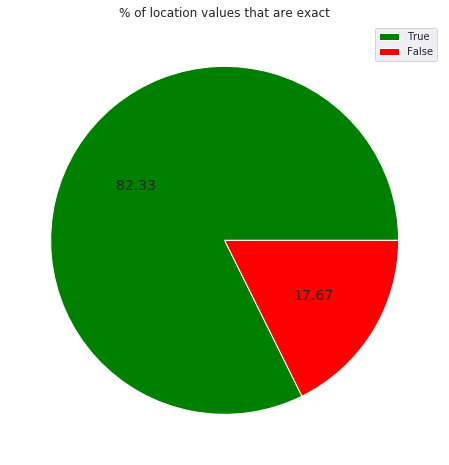

In [228]:
rdf_locexact = pd.DataFrame(revenue_df_raw.is_location_exact.value_counts()/len(revenue_df_raw) * 100)

# Plotting the % exact location values pie chart
rdf_locexact.plot.pie(y='is_location_exact', figsize=(20,8), autopct='%.2f', labels=['', ''], fontsize=14, colors=['g', 'r'])
plt.ylabel('')
plt.title('% of location values that are exact')
plt.legend(labels=['True', 'False'])

The training dataset + KNN model for the imputer can be trained as shown below.

In [229]:
KNN_MODEL_PATH = '../model/knn_imputer'
if path.exists(KNN_MODEL_PATH):
    knn_imputer = pickle.load(open(KNN_MODEL_PATH, 'rb'))    
else:
    # Prepare training set
    train_features = revenue_df_raw.loc[revenue_df_raw.zipcode.notna(), ['latitude', 'longitude']].values.copy()
    train_labels = revenue_df_raw.loc[revenue_df_raw.zipcode.notna(), ['zipcode']].values.copy()
    train_labels = train_labels.reshape((len(train_labels)))
        
    # Fit the model
    knn_imputer = KNN(n_neighbors=5)
    knn_imputer.fit(train_features, train_labels)
    pickle.dump(knn_imputer, open(KNN_MODEL_PATH, 'wb'))

In [230]:
# Acquire prediction indices for NaN zipcodes
predict_features = revenue_df_raw.loc[revenue_df_raw.zipcode.isna(), ['latitude', 'longitude']].values.copy()
predict_indices = revenue_df_raw.zipcode.isna().copy()


# Make predictions    
predict_labels = knn_imputer.predict(predict_features)

To verify our unsupervised machine learning solution, let us refer to a random (latitude, longitude) position:

In [231]:
# a prediction instance
predict_features[34]

array([ 40.72118, -73.99682])

The true coordinates for the location can be mapped:

The AirBnB is posted on https://www.airbnb.com/rooms/3059273

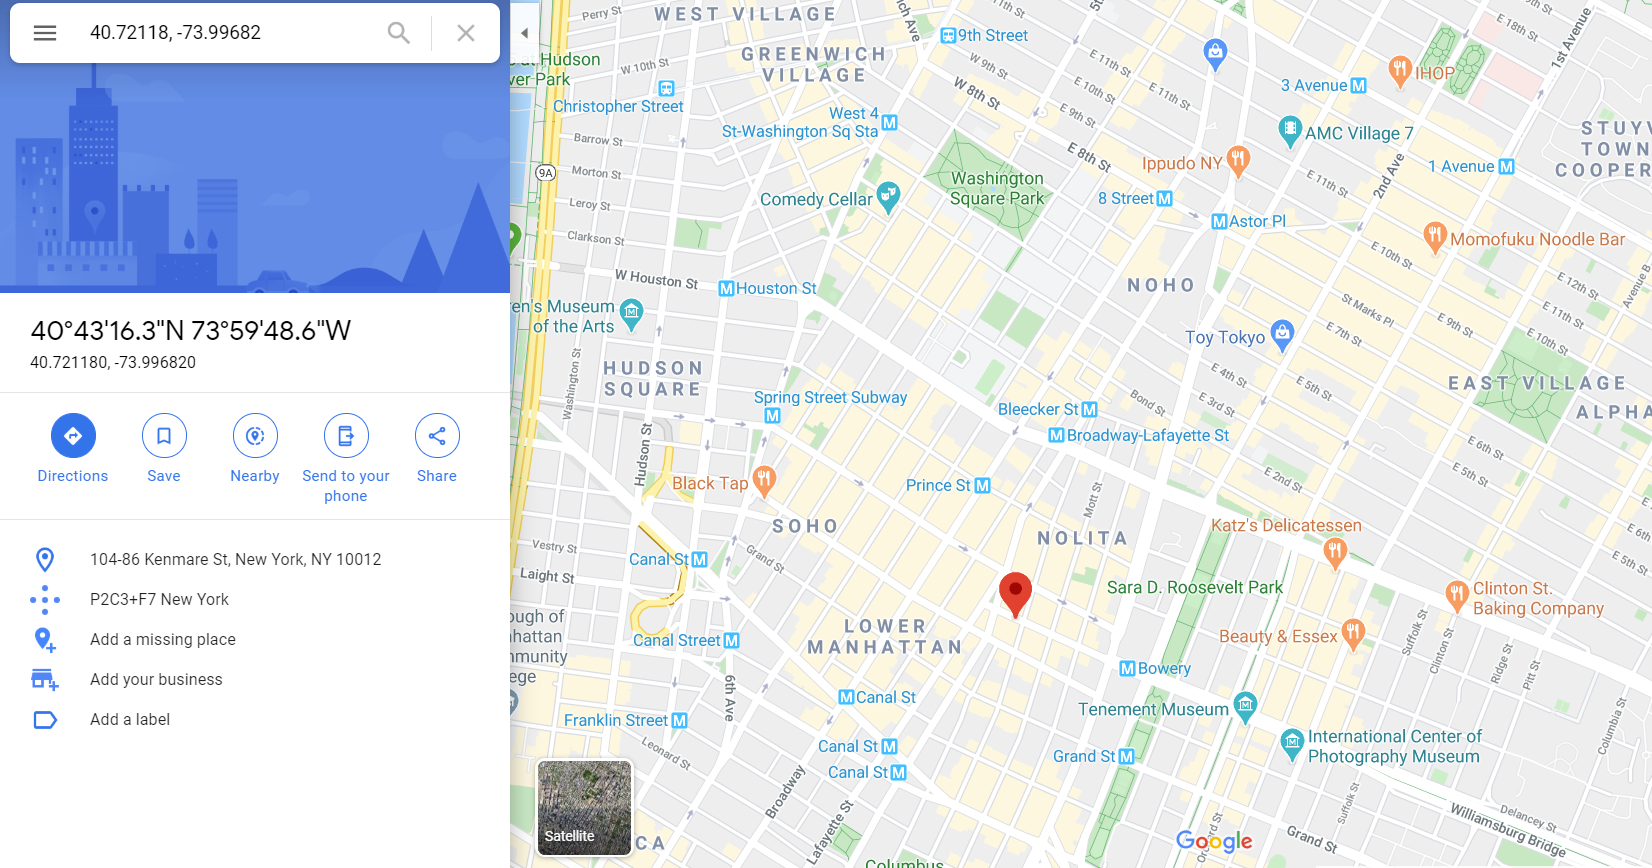

The KNN imputer predicted the following zipcode, which can be plotted as 

In [232]:
predict_labels[34]

'10012'

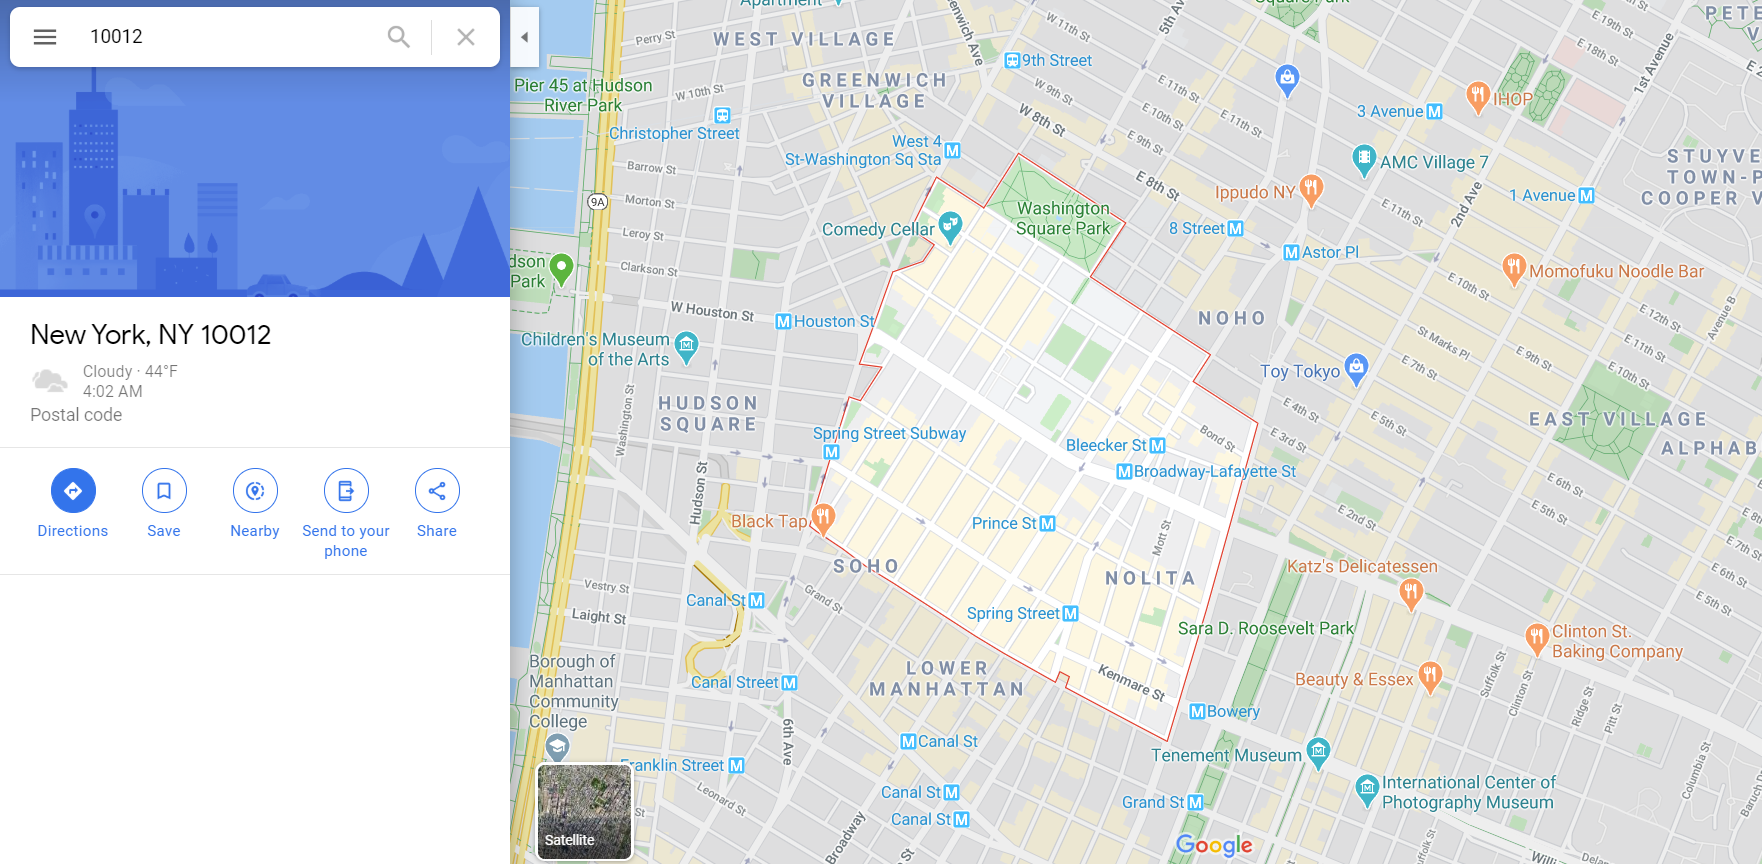

The zipcode looks quite accurate when referring back to the spatial coordinates information. Thus, our KNN imputation should be in a position to decently handle missing results for zipcodes in the revenue dataset. All predicted zipcodes can be assiged to the null-zipcode rows of the revenue dataset. 

In [233]:
revenue_df_raw.loc[predict_indices, 'zipcode'] = predict_labels.copy()
revenue_df_raw.loc[predict_indices].head()

id neighbourhood_cleansed neighbourhood_group_cleansed zipcode  \
36     11452     Bedford-Stuyvesant                     Brooklyn   11221   
313    74240           Williamsburg                     Brooklyn   11249   
745   270139               Bushwick                     Brooklyn   11237   
1208  515392                Chelsea                    Manhattan   10011   
1345  591565                Tribeca                    Manhattan   10013   

      latitude  longitude is_location_exact property_type        room_type  \
36    40.68876  -73.94312                 f     Apartment     Private room   
313   40.71903  -73.95970                 t     Apartment  Entire home/apt   
745   40.70278  -73.92673                 f     Apartment     Private room   
1208  40.74348  -73.99980                 f     Apartment  Entire home/apt   
1345  40.71552  -74.00749                 t          Loft     Private room   

      accommodates  ...  availability_365  number_of_reviews  first_review  \
36               1  ...               365                  0           NaN   
313              2  ...               215                 68    2011-03-29   
745              2  ...                88                 21    2013-07-17   
1208             3  ...               260                 60    2013-03-05   
1345             4  ...                36                 62    2012-08-01   

     last_review review_scores_rating  review_scores_accuracy  \
36           NaN                  NaN                     NaN   
313   2019-06-07                 93.0                     9.0   
745   2019-01-15                 87.0                     9.0   
1208  2019-06-02                 96.0                    10.0   
1345  2014-04-27                 98.0                     9.0   

      review_scores_cleanliness  review_scores_location  review_scores_value  \
36                          NaN                     NaN                  NaN   
313                         9.0                    10.0                  9.0   
745                         8.0                     9.0                  9.0   
1208                        9.0                    10.0                  9.0   
1345                       10.0                    10.0                 10.0   

      reviews_per_month  
36                  NaN  
313                0.67  
745                0.29  
1208               0.78  
1345               0.73  

[5 rows x 28 columns]

#### How many common NYC zipcodes are present in the Cost and Revenue Datasets?

From a closer look, it seems like we have very few number of zipcodes common to the Cost and Revenue datasets respectively, which is given by:

In [234]:
# Using set theory to find out common rows 
common_zipcodes = set(
    revenue_df_raw.zipcode.astype('int64').unique()
).intersection(
    set(cost_df_raw.RegionName.unique())
)


print('Common Number of NYC Zipcodes between Cost & Revenue Datasets: {}'.format(len(common_zipcodes)))
print('Number of NYC Zipcodes in Revenue Dataset: {}'.format(len(revenue_df_raw.zipcode.unique())))
print('Number of NY Zipcodes in Cost Dataset: {}'.format(len(cost_df_raw.RegionName.unique())))
print('Number of NYC Zipcodes in Revenue Dataset: {}'.format(len(common_zipcodes)))

Common Number of NYC Zipcodes between Cost & Revenue Datasets: 28
Number of NYC Zipcodes in Revenue Dataset: 189
Number of NY Zipcodes in Cost Dataset: 475
Number of NYC Zipcodes in Revenue Dataset: 28


From common number of zipcodes, it can be inferred that we could prune our analysis space to make our decision making process simpler. However since we have not referring to a large number of zipcodes relevant to NYC (i.e., 161 lesser zipcodes which may have more lucrative options), our pruned analysis space is not guaranteed to give the most optimal recommendation for the best 2-bedroom property for investment. Unfortunately, the Cost Dataset (i.e., Zillow Dataset) does not contain historic information that could help us determine, for example, the number of years it would take to breakeven. 

It would probably make sense to save a copy of the portion of the preprocessed revenue dataset whose zipcodes don't overlap with the cost dataset, since we might be able to gather more historic information pertaining to the missing NYC zipcodes by updating out cost dataset with time. 

For further preprocessing, we still consider the revenue dataset with approximately its complete NYC zipcode space (i.e., all 189 NYC zipcodes we have acquired till now), so that we can fork a dataset copy of irrelevant (in terms of the cost dataset) NYC zipcodes for future analysis (time will be saved in the future since we have already preprocessed this portion of the dataset, and so we can append it to our existing processed revenue dataset for analysis).    

#### Numeric Conversion of *Price* Column in Revenue Dataset 

The *price* column of the revenue dataset appears to have ',' and '$' symbols, which may have caused its incorrect dtype-inference on read to an *object* type.    

In [235]:
revenue_df_raw.price.unique()[-5:]

array(['$1,308.00', '$561.00', '$1,369.00', '$1,749.00', '$338.00'],
      dtype=object)

The *price* column can be correctly converted to a numeric type by removing the unwanted symbols:

In [236]:
revenue_df_raw.price = revenue_df_raw.price.str[1:].replace(',', '', regex=True).astype('float64')
revenue_df_raw.price.head()

0    149.0
1    225.0
2    150.0
3     89.0
4     80.0
Name: price, dtype: float64

#### Handling Missing Values of Review Score Attributes  

There are particularly 5 attributes pertaining to the review scores that draw our attention:
- review_scores_accuracy 
- review_scores_cleanliness
- review_scores_location
- review_scores_value
- review_scores_rating

These attributes could be useful in filtering properties that are not worth investing based on their scores.

The percentage of missing values for these attributes are about:

In [237]:
rdf_revscores = revenue_df_raw.loc[:, 'review_scores_rating':'review_scores_value'].copy()
rdf_revscores.isna().sum()/len(revenue_df_raw) * 100

review_scores_rating         22.542702
review_scores_accuracy       22.620436
review_scores_cleanliness    22.585660
review_scores_location       22.665439
review_scores_value          22.661348
dtype: float64

From first glance, it looks we might be able to impute the data for these attributes. But unfortunately, the distribution for the attributes is skewed as shown below: 

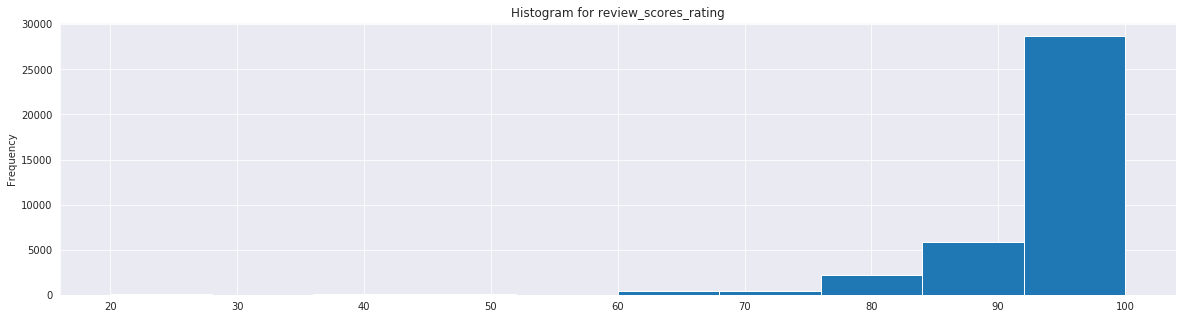

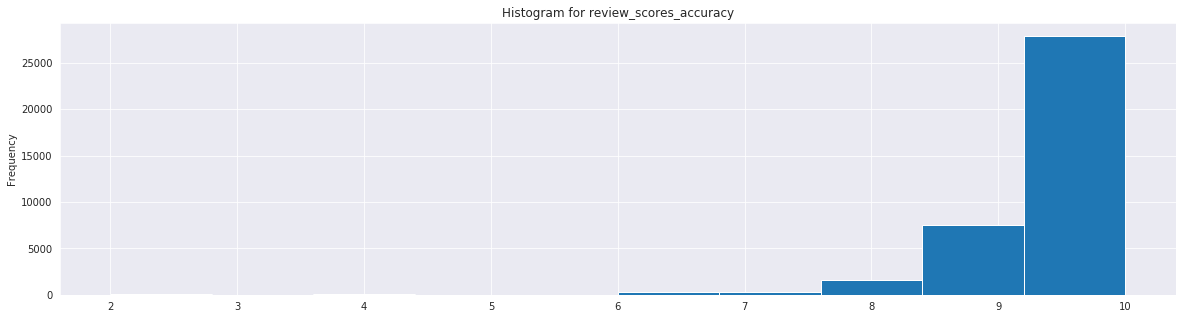

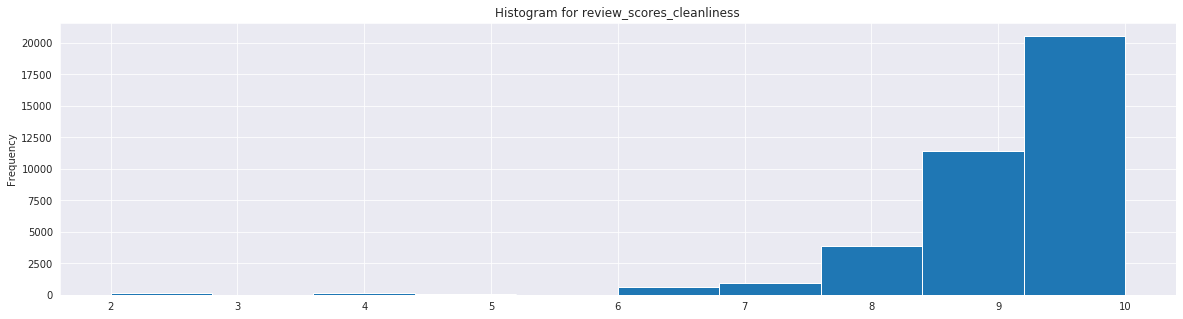

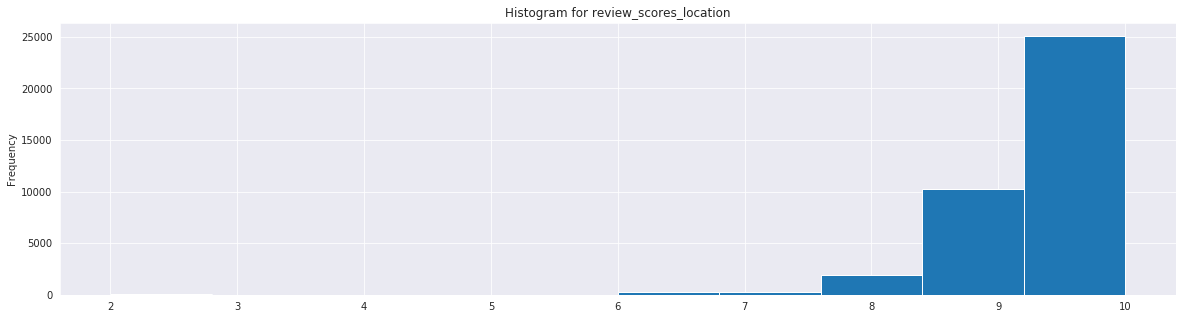

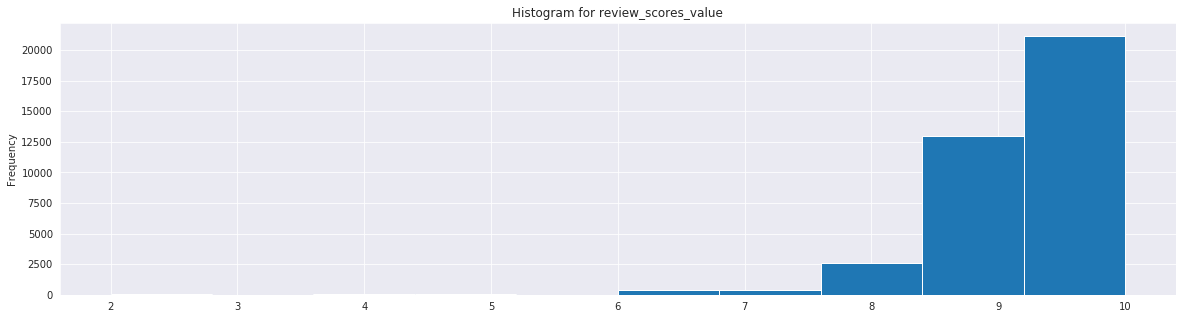

In [238]:
for x in rdf_revscores.columns.values:
    plt.figure(figsize=(20, 5))
    rdf_revscores[x].plot(kind='hist')
    plt.title('Histogram for ' + x)

Most of the properties seem to score >= 8 (or 80). To get an idea of the situation from a numeric sense, 

In [239]:
# Utility that returns a sorted cumsum dataframe for an attribute
def attribute_cumsum(attribute, colname):
    """Returns sorted cumsum dataframe for an attribute of a dataset. 
       Allows a maximum of 10 unique values; otherwise the series is binned into 10 ranges
    Args:
        attribute: Series referring to dataset attribute, 
        colname: String referring to attribute name
    
    Returns:
        DataFrame: Unique values of attributes (sorted) along with their cumsum values 
    """
    attribute = attribute.dropna().copy()
    if len(attribute.unique()) > 10: attribute = pd.cut(attribute, bins=10)
    temp = attribute.value_counts().sort_index().to_frame()
    temp['cumsum'] = temp.cumsum()/len(attribute) * 100
    temp.index.name = colname
    temp.columns = ['value_counts', 'percent_of_total_rows <= score_value']
    print(len(attribute))
    return temp

In [240]:
attribute_cumsum(rdf_revscores.review_scores_rating, 'review_scores_rating')

37865


value_counts  percent_of_total_rows <= score_value
review_scores_rating                                                    
(19.92, 28.0]                  105                              0.277301
(28.0, 36.0]                     7                              0.295788
(36.0, 44.0]                    93                              0.541397
(44.0, 52.0]                    43                              0.654958
(52.0, 60.0]                   365                              1.618909
(60.0, 68.0]                    83                              1.838109
(68.0, 76.0]                   457                              3.045028
(76.0, 84.0]                  2377                              9.322593
(84.0, 92.0]                  6927                             27.616532
(92.0, 100.0]                27408                            100.000000

In [241]:
attribute_cumsum(rdf_revscores.review_scores_location, 'review_scores_location')

37805


value_counts  percent_of_total_rows <= score_value
review_scores_location                                                    
2.0                               53                              0.140193
3.0                                3                              0.148129
4.0                               28                              0.222193
5.0                               16                              0.264515
6.0                              247                              0.917868
7.0                              224                              1.510382
8.0                             1941                              6.644624
9.0                            10220                             33.678085
10.0                           25073                            100.000000

In [242]:
attribute_cumsum(rdf_revscores.review_scores_cleanliness, 'review_scores_cleanliness')

37844


value_counts  percent_of_total_rows <= score_value
review_scores_cleanliness                                                    
2.0                                 153                              0.404291
3.0                                  10                              0.430716
4.0                                 164                              0.864074
5.0                                  96                              1.117747
6.0                                 651                              2.837966
7.0                                 925                              5.282211
8.0                                3848                             15.450270
9.0                               11439                             45.676990
10.0                              20558                            100.000000

In [243]:
attribute_cumsum(rdf_revscores.review_scores_value, 'review_scores_value')

37807


value_counts  percent_of_total_rows <= score_value
review_scores_value                                                    
2.0                            97                              0.256566
3.0                             5                              0.269791
4.0                            90                              0.507842
5.0                            59                              0.663898
6.0                           406                              1.737773
7.0                           399                              2.793134
8.0                          2628                              9.744227
9.0                         12984                             44.087074
10.0                        21139                            100.000000

As we can see from the above tables, more than 50% data for these attributes lie in the range of the top 2 score values, roughly described by [9, 10] or [80, 100] in case of *review_scores_rating*. Further, by looking at the descriptive statistics for these attributes, we find that:  

In [244]:
rdf_revscores.describe()

review_scores_rating  review_scores_accuracy  \
count          37865.000000            37827.000000   
mean              93.926502                9.621382   
std                8.578398                0.842285   
min               20.000000                2.000000   
25%               92.000000                9.000000   
50%               96.000000               10.000000   
75%              100.000000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_location  review_scores_value  
count               37844.000000            37805.000000         37807.000000  
mean                    9.279357                9.564740             9.399397  
std                     1.084451                0.758279             0.907176  
min                     2.000000                2.000000             2.000000  
25%                     9.000000                9.000000             9.000000  
50%                    10.000000               10.000000            10.000000  
75%                    10.000000               10.000000            10.000000  
max                    10.000000               10.000000            10.000000

, the mean and medians also lie in the range of top 2 score values, roughly described by [9, 10] or [80, 100] in case of *review_scores_rating*. This means that simple imputation techniques like mean/median imputation for these review score attributes would be meaningless - the missing data of the review score attributes (comprising of 20% of the revenue dataset rows) would be receive the highest score values in each category (cleanliness, location, etc.), implying that each of the AirBnB properties listings with missing values are *a great choice to invest* since their review scores (which were imputed) always consider these properties *great*. This does not necessarily hold true!

Another interesting observation, is that the percentage of rows having *review_scores_accuracy* with NaN values, *review_scores_cleanliness* with NaN values, *review_scores_location* with NaN values, *review_scores_rating* with NaN values and *review_scores_value* with NaN values collectively is:   

In [245]:
len(rdf_revscores.loc[(rdf_revscores.review_scores_accuracy.isna()) & (rdf_revscores.review_scores_cleanliness.isna()) & (rdf_revscores.review_scores_location.isna()) & (rdf_revscores.review_scores_value.isna()) & (rdf_revscores.review_scores_rating.isna())])/len(rdf_revscores) * 100

22.53042855681702

which is approximately the percentage of missing values of the individual attributes! 

Moreover, from the descriptive statistics for the *number_of_reviews* for the case when all review score attributes are collectively missing, we get:

In [246]:
revenue_df_raw.loc[(revenue_df_raw.review_scores_accuracy.isna()) & (revenue_df_raw.review_scores_cleanliness.isna()) & (revenue_df_raw.review_scores_location.isna()) & (revenue_df_raw.review_scores_value.isna()) & (revenue_df_raw.review_scores_rating.isna())].number_of_reviews.describe()

count    11014.000000
mean         0.104049
std          0.373308
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: number_of_reviews, dtype: float64

This further indicates that such properties (that are missing all review scores; and comprise of nearly all missing values for the review score attributes) never received any rating from tenants. This could be due to a number of reasons:

- Such properties may be new and have just be made available for rent.
- Tenants aren't aware of such properties (possibly due to lack of marketing, or tenants already have good options to choose from - from the histogram plots above, we saw that many properties ave review scores belonging to the top-2 score range).
- Tenants have always avoided staying in these properties since the very beginning.
- Tenants never took the time to review the property after staying there.

In an attempt to impute the review score values nevertheless (since dropping the 22% missing data rows without any justification might result in loss of useful information - derived from other non-missing attributes), we took a step further to try and check among 3 powerful machine learning classifiers for a suitable candidate for imputation for these columns. But it looks like the current set of features (such as *price, zipcode, availability_30, accommodates, etc.*) are not at all good predictors for the review score attributes.   

In [247]:
# Utility functions
# Prepare the data
def standardize(dataset):
    """Handles scaling of numeric attributes
    Args:
        dataset: DataFrame of numeric attributes
    
    Returns:
        Dataframe with standardized numeric attributes
    """
    dataset = dataset.copy()
    return (dataset - dataset.mean()) / dataset.var()



# Train individual mode on dataset 
def train_and_predict(model, X, Y, train_ind, valid_ind):
    """Train individual model on training data and return validation F-score value
    Args:
        model: Machine Learning model object
        X, Y: Processed features and label columns of the dataset
        train_ind, valid_ind: Training and validation indices of the dataset attained from K-Fold
    
    Returns:
        F-score value learned from the model 
    """
    model.fit(X.iloc[train_ind], Y.iloc[train_ind])
    Ypredict = model.predict(X.iloc[valid_ind])
    return f1_score(Y.iloc[valid_ind], Ypredict, average='weighted')    



# Find the best machine learning algorithm as data imputer for review score attributes
def get_imputer(rdf_mldata, features, labels, label_indicator):
    """Recommends the best imputer ML model (from Elastic Net, Random Forest, KNN) for imputing a mising attribute
    Args: 
        rdf_mldata: DataFrame with features and labels
        features: List of Strings indicating the name of columns that are features
        labels: List of Strings indicating the name of columns that are to be predicted
        label_indicator: Number indicating the label in the labels list to be predicted
    
    Prints:
        Best model along with its F-score value
    """
    # Standardize numeric features
    numeric_features = rdf_mldata[features].select_dtypes('number').columns.values
    rdf_mldata.loc[:, numeric_features] = standardize(rdf_mldata.loc[:, numeric_features]).copy()
    
    # Extract dataset for training (non NaN rows in review score attribute)
    Xtrain, Ytrain = (
        pd.get_dummies(rdf_mldata.loc[rdf_mldata[labels[label_indicator]].notna(), features]), # perform one-hot encoding
        rdf_mldata.loc[rdf_mldata[labels[label_indicator]].notna(), labels[label_indicator]],
    )
    
    # Find the 5-Fold Cross Validation indices
    kfold = KFold(n_splits=5, shuffle=True, random_state=5)
    
    # Declare arrays that would store cross-valition scores
    cross_valid_LR = []
    cross_valid_RF = []
    cross_valid_KNN = []
    
    # ML models to choose from after cross validation 
    models = ['Logistic Regression', 'Random  Forest', 'KNN']
    
    # Getting F-scores values from the 3 different regression models at 5 splits of CV
    k = 0 # indicates kth-split completed  
    
    for train_ind, valid_ind in kfold.split(Xtrain, Ytrain):    
        cross_valid_LR.append(train_and_predict(LogisticRegression(max_iter=10000), Xtrain, Ytrain, train_ind, valid_ind))
        cross_valid_RF.append(train_and_predict(RandomForestClassifier(), Xtrain, Ytrain, train_ind, valid_ind))
        cross_valid_KNN.append(train_and_predict(KNN(n_neighbors=10), Xtrain, Ytrain, train_ind, valid_ind))
        k += 1
        print('Cross-Validation split - {} completed'.format(k))

    # Print the model with the highest F-score 
    cv_scores = [np.mean(cross_valid_LR), np.mean(cross_valid_RF), np.mean(cross_valid_KNN)]
    best_model = np.argmax(cv_scores)
    print('-----> The best model was found to be {} with F-score: {}'.format(models[best_model], cv_scores[best_model]))

For example, we tried finding out if we can find a good Machine Learning model for imputing the missing values for the *review_score_accuracy* column. The most suitable machine learning model was found to be: 

In [248]:
# Defining features + labels for models
features = ['zipcode', 'accommodates', 'room_type', 'property_type', 'price', 'availability_30']
labels = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location', 
          'review_scores_value', 'review_scores_rating']

# Finding an ML imputer model 
ignore = True     # training 3 sophisticated models on 5 splits takes a lot of time! (see image instead) 
if not ignore: get_imputer(revenue_df_raw.loc[:, features + labels].copy(), features, labels, 0)

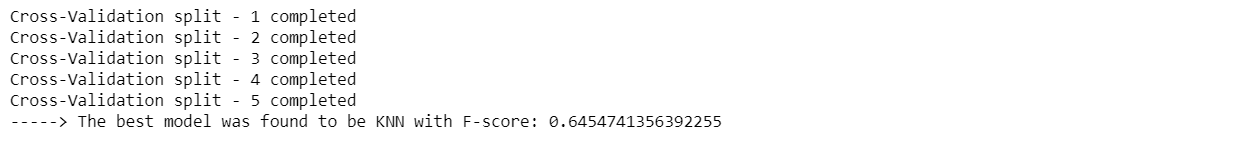

We found that the best ML model gave a F-score of 0.64. This metric value is very low for using our ML model for imputation purposes. We could use more complex models like neural nets, but as mentioned before, such properties haven't even received any reviews. Thus, from all the above observations, we've finally decided to filter out rows in the revenue dataset where all of the review score attributes are collectively null.   

In [249]:
revenue_df_raw.drop(
    revenue_df_raw.loc[(revenue_df_raw.review_scores_accuracy.isna()) & (revenue_df_raw.review_scores_cleanliness.isna()) & (revenue_df_raw.review_scores_location.isna()) & (revenue_df_raw.review_scores_value.isna()) & (revenue_df_raw.review_scores_rating.isna())].index,
    inplace=True
)

The percentage of missing values for the review score attributes has now dropped significantly to less than 1%: 

In [250]:
rdf_revscores = revenue_df_raw.loc[:, 'review_scores_rating':'review_scores_value'].copy()
rdf_revscores.isna().sum()/len(revenue_df_raw) * 100

review_scores_rating         0.015843
review_scores_accuracy       0.116184
review_scores_cleanliness    0.071295
review_scores_location       0.174276
review_scores_value          0.168995
dtype: float64

Interestingly, the rows in the review score attributes that have missing values for their corresponding review score attribute have the following descriptive statistics:

In [251]:
for col in rdf_revscores.columns.values:
    temp = revenue_df_raw[revenue_df_raw[col].isna()].number_of_reviews.copy()
    print(
        "Missing-valued rows for {} column has the following descriptive stats for number_of_reviews: \n- Median: {:.2f} \n- Mean: {:.2f} \n- Min: {:.2f} \n- Max: {:.2f} \n\n".format(
            col, temp.mean(), temp.median(), temp.min(), temp.max()
            )
    )  

Missing-valued rows for review_scores_rating column has the following descriptive stats for number_of_reviews: 
- Median: 1.33 
- Mean: 1.00 
- Min: 1.00 
- Max: 2.00 


Missing-valued rows for review_scores_accuracy column has the following descriptive stats for number_of_reviews: 
- Median: 1.45 
- Mean: 1.00 
- Min: 1.00 
- Max: 10.00 


Missing-valued rows for review_scores_cleanliness column has the following descriptive stats for number_of_reviews: 
- Median: 1.56 
- Mean: 1.00 
- Min: 1.00 
- Max: 10.00 


Missing-valued rows for review_scores_location column has the following descriptive stats for number_of_reviews: 
- Median: 1.42 
- Mean: 1.00 
- Min: 1.00 
- Max: 10.00 


Missing-valued rows for review_scores_value column has the following descriptive stats for number_of_reviews: 
- Median: 1.45 
- Mean: 1.00 
- Min: 1.00 
- Max: 10.00 




This means most of these properties covered by the null review-score rows barely have on average just 1 review, with a maximum of 10 reviews. For a place like New York, we would expect an active property to review more number of reviews (this is what the real-estate investor would also be careful about). Mostly, such properties do have good average review scores:  

In [252]:
rdf_revscores.describe()

review_scores_rating  review_scores_accuracy  \
count          37865.000000            37827.000000   
mean              93.926502                9.621382   
std                8.578398                0.842285   
min               20.000000                2.000000   
25%               92.000000                9.000000   
50%               96.000000               10.000000   
75%              100.000000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_location  review_scores_value  
count               37844.000000            37805.000000         37807.000000  
mean                    9.279357                9.564740             9.399397  
std                     1.084451                0.758279             0.907176  
min                     2.000000                2.000000             2.000000  
25%                     9.000000                9.000000             9.000000  
50%                    10.000000               10.000000            10.000000  
75%                    10.000000               10.000000            10.000000  
max                    10.000000               10.000000            10.000000

But being less-reviewed by tenants, such properties may not a suitable option for investing at all for the long-term (need more data on the reviews!). Finally, we have justified that all missing values for the review score attributes should be dropped.

In [253]:
revscore_attribs = rdf_revscores.columns.values
revenue_df_raw.dropna(subset=revscore_attribs, inplace=True)

#### Imputation the Number of *Beds*, *Bedrooms* and *Bathrooms* in Revenue Dataset

The real-estate firm is concentrating on 2-bedroom properties. For assessing the quality of the property, the number of beds and bathrooms may be important. It is crucial to impute missing values for these attributes. The percentage of null counts for these columns can be summarized as:

In [254]:
rdf_propinfo = revenue_df_raw[['bedrooms', 'beds', 'bathrooms']].copy()
(rdf_propinfo.isna().sum()/len(rdf_propinfo) * 100).sort_values()

bedrooms     0.050288
beds         0.050288
bathrooms    0.113811
dtype: float64

All of these columns barely even constitute 1% of the missing values. However, it might not be suitable to simply drop the rows those have missing values, as the *price* pertaining to these properties may actually turn out to be lucrative. 

In this scenario, a simple imputation technique may be desired. Let us have a look at the mean and median of these columns:

In [255]:
rdf_propinfo.describe().T

count      mean       std  min  25%  50%  75%   max
bedrooms   37763.0  1.179885  0.739724  0.0  1.0  1.0  1.0  14.0
beds       37763.0  1.573074  1.145811  0.0  1.0  1.0  2.0  40.0
bathrooms  37739.0  1.138769  0.421866  0.0  1.0  1.0  1.0  15.5

The mean and median are roughly equal, implying that each NYC property in general tend to comprise 1 bedroom, 1 bed and 1 bathroom. However, we are generally interested in looking at 2-bedroom properties. A heatmap indicating the number of nulls common to columns is drawn below:

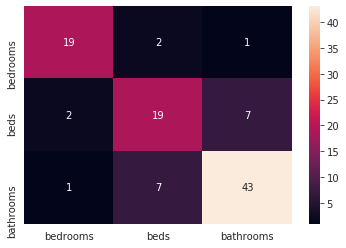

In [256]:
# Create a heatmap
heatmap_arr = np.empty((3,3))
cols = rdf_propinfo[['bedrooms', 'beds', 'bathrooms']].columns.values
for i, x in enumerate(cols):
    for j, y in enumerate(cols):
        heatmap_arr[i, j] = ((rdf_propinfo[x].isna()) & (rdf_propinfo[y].isna())).sum()
        
sns.heatmap(heatmap_arr, annot=True, xticklabels=cols, yticklabels=cols)

It can be inferred from the heatmap that about 22 null-bedrooms would be imputed as a 1-bedroom property (although our preference is for 2-bedroom properties and so we could just discard these 22 rows instead of imputation). Likewise in this case, only a maximum of about 90 rows pertaining to *beds* and *bathrooms* are required to be imputed. From all of these observations, although it may seem overkill to impute a very small fraction of rows in our revenue dataset, this might still be a better idea so as to secure the scalability of our data cleaning pipeline.   

Therefore, a median imputation technique is followed for the columns: *bed, bedrooms* and *bathrooms*:

In [257]:
revenue_df_raw.loc[:, ['bedrooms', 'beds', 'bathrooms']] = rdf_propinfo.fillna(rdf_propinfo.median()).copy()

#### Filtering Samples based on 2-Bedroom Properties 

As the real-estate investor has preference for 2-bedroom properties, we can filter our revenue dataset based on the number of bedrooms (i.e., 2-bedrooms) in the listed AirBnB properties. The revenue dataset finally turns out to have the following number of rows: 

In [258]:
revenue_df_raw = revenue_df_raw.loc[revenue_df_raw['bedrooms'] == 2].drop('bedrooms', axis=1)
len(revenue_df_raw)

5105

#### Filtering Columns based on the *first review, last_review, reviews_per_month* columns 
An attempt was made to study the utility of these columns to create a quality metric, however the proportion of missing values make it difficult to incorporate these columns. A 'proxy' attribute was decided after performing a t-test. 

Earlier, it was decided to estimate a quality metric: **Property Popularity**, defined approximately as the total number of reviews attained since the property was first reviewed.

$Property\_Popularity = \frac{Last\_Review\_Date - First\_Review\_Date}{30\ days}*Reviews\_Per\_Month $

where the subtraction of dates yield results in *days*. 

From the metadata, the $Number\_Of\_Reviews$ attribute in the revenue dataset specifies the total the number of reviews a property is received since its entire existence on AirBnB, it was assumed that:

$Property\_Popularity \neq Number\_Of\_Reviews$

, since a host owning a particular property may have changed over time. For example, Bob listed his *Elmtale* property on AirBnB on June 2016 through his account. Later, he sold his *Elmtale* property to Sam in July 2018. Bob removed the *Elmtale* property from his AirBnB account, but now Sam lists the *Elmtale* property on his AirBnB account.At this time, it is fair to believe that the revenue dataset consisting of Sam's listing of *Elmtale* property would have $Number\_Of\_Reviews$ accounting for the total number of reviews garnered (Bob's + Sam's reviews), as per the metadata information given.      

Unfortunately, the percentage of missing values for *last_review, first_review* and *reviews_per_month* columns are as follows:

In [259]:
revenue_df_raw[['first_review', 'last_review', 'reviews_per_month']].isna().sum()/len(revenue_df_raw) * 100

first_review         0.0
last_review          0.0
reviews_per_month    0.0
dtype: float64

It is technically difficult to impute missing dates for when a property was first and last reviewed respectively. This limitation could be alleviated by seeking information about the missing values directly from AirBnB, but this would suitable t this moment. Although the number of days since it was first and last reviewed respectively can be imputed using, for example the zipcode, it is desirable to get more accurate data regarding the reviews pertaining to the property.  

Could such a $Property\_Popularity$ by estimated a substitute attribute, eg. $Number\_Of\_Reviews$, despite their assumption of not being the equal (discussed above)? Unfortunately, our t-test does not support this statement:   

##### T-Test under Null Hypothesis: $Property\_Popularity$ = $Number\_Of\_Reviews$  

- Compute the propery popularity metric:

Text(0.5, 1.0, 'Distribution of Property_Popularity')

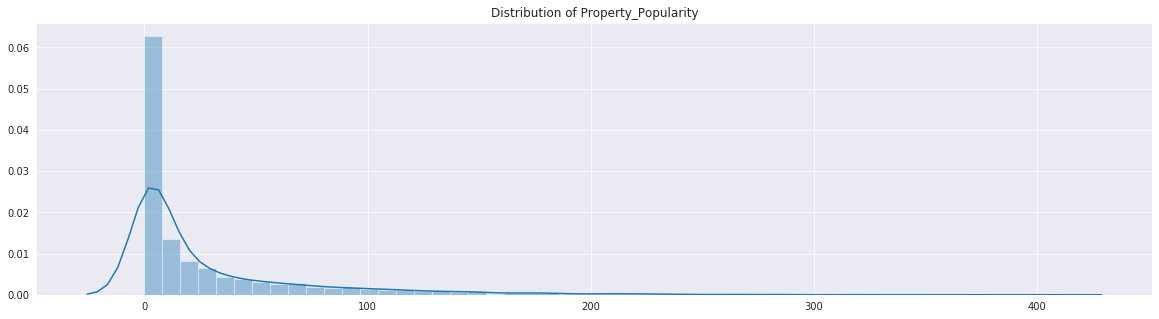

In [260]:
popularity_metric = ((pd.to_datetime(revenue_df_raw.last_review) - pd.to_datetime(revenue_df_raw.first_review))/pd.to_timedelta('30 days') * revenue_df_raw.reviews_per_month).copy()
plt.figure(figsize=(20,5))
sns.distplot(popularity_metric)
plt.title('Distribution of Property_Popularity')

- Extract the number of reviews from the revenue dataset:

Text(0.5, 1.0, 'Distribution of Number_Of_Reviews')

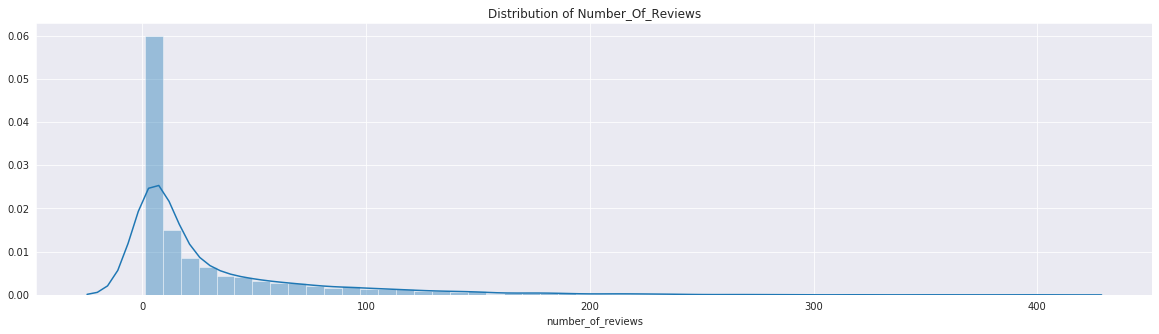

In [261]:
no_of_reviews = revenue_df_raw.number_of_reviews.copy()
plt.figure(figsize=(20,5))
sns.distplot(no_of_reviews)
plt.title('Distribution of Number_Of_Reviews')

From the histogram plot, it looks like the distributions for the popularity metric and number of reviews appear to be the same. 

Performing the t-test, we get:   

In [262]:
ttest_ind(popularity_metric.dropna(), no_of_reviews.dropna())

Ttest_indResult(statistic=-2.3776109523490674, pvalue=0.01744350759664717)

As the p-value is close to the value of Zero, we can reject the null hypothesis with confidence. This implies that the $Property\_Popularity$ and $Number\_Of\_Reviews$ are more likely different than each other. 

Going forward, we use $Number\_Of\_Reviews$ as a proxy for the $Property\_Popularity$ metric, which is now defined differently as the total number of reviews gained since its existence on AirBnB (rather than since its first review). This will be covered later in the upcoming sections.     

##### Removal of  first_review, last_review and reviews_per_month columns

Due to the unlikely benefits from data imputation from lack of real data, *first_review*, *last_review* and *reviews_per_month* are filtered out from the revenue dataset for the time being.   

In [263]:
revenue_df_raw.drop(['first_review', 'last_review', 'reviews_per_month'], axis=1, inplace=True)

#### Filtering Columns based on Availability of Property for Rent within 30 Days time

It is assumed that *availability_x* attributes correspond to the the number of the days a property is not owned by a tenant within the x-days limit from today (or more precisely, the time the AirBnB data was last scraped).

The real-estate investor is looking for short-term rentals. By a loose definition, short-term rentals usually last anywhere upto a month. This makes sense, due to the inherent nature of utilizing AirBnB for publicizing rental properties - if I were a customer, I would look at AirBnB to book my temporary stay if I am touring/visit a new place. On this note, a short-term rental is defined to be about 30 days in length. 

A scatterplot for the *availability_30*, *availability_60*, *availability_90* and *availability_365* columns (abbreviated as **av30, av60, av90 and av365** respectively for readability) is displayed below: 

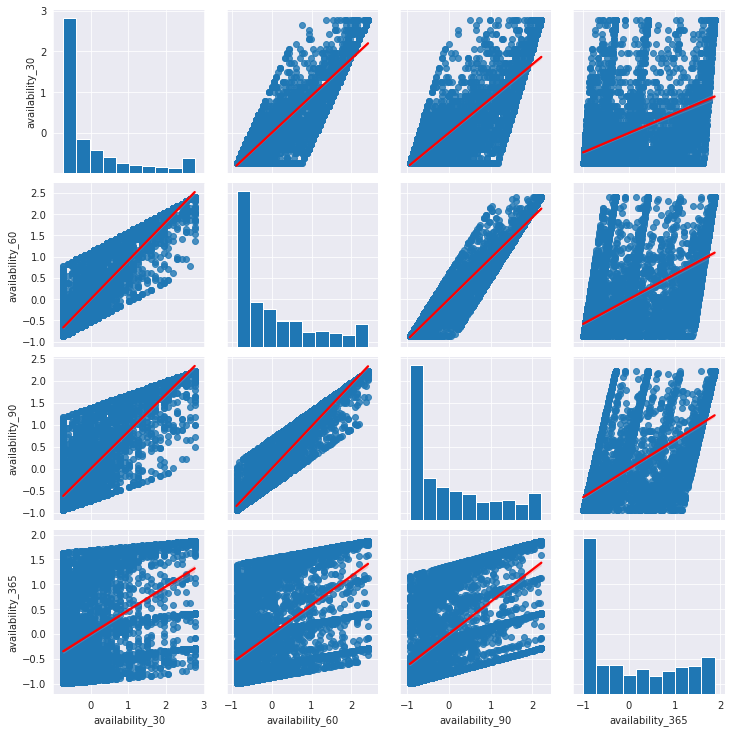

In [264]:
# Standardizing data to minimize effects of scale and then plotting
rdf_std_av = revenue_df_raw[['availability_30', 'availability_60', 'availability_90', 'availability_365']].copy()
rdf_std_av = (rdf_std_av - rdf_std_av.mean()) / rdf_std_av.std()

g = sns.pairplot(
    rdf_std_av, 
    kind='reg', 
    plot_kws={'line_kws':{'color':'red'}}
)
# [g.axes[i,j].set_ylim((0,100)) for i in range(4) for j in range(4)] ;
# [g.axes[i,j].set_xlim((0,400)) for i in range(4) for j in range(4)] ;

From the regression lines, it can be seen that the effect of av60 on av90 is slightly higher (steeper slope, av90 vs av60 plot) compared to the effect of av30 on av90 (av90 vs av30 plot). This makes intuitive sense - if I have 30 more days worth of data (i.e., av60 ~ next 60 days) pertaining to availability of a property for rent (compared to av30 ~ next 30 days only), it should be easier for me to estimate the availability of the property for rent within the next 90 days. This also means lesser variability, that is visible in av90 vs av60 plot (compared to the av90 vs av30 plot).    

So far, it appears to be that av60 should be suitable 'average estimate' for the occupancy rate of rental properties.

None of the attributes - av30, av60, av90. seem to have a strong affect on av365 (based on the variability). This could be due to a number of factors, one such factor could be - seasonality might play a role in renting habits over longer durations.

For our use case however, av30 will be used to determine the availability of a property for rent, i.e., occupancy rate, since short-term rentals would find shorter time durations more critical in deciding the occupancy rate (i.e., for eg. in the next 30 days, can I rent this property?)   

In [265]:
revenue_df_raw.drop(['availability_60', 'availability_90', 'availability_365'], axis=1, inplace=True)

In [266]:
revenue_df_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5105 entries, 48 to 48410
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   id                            5105 non-null   int64   
 1   neighbourhood_cleansed        5105 non-null   category
 2   neighbourhood_group_cleansed  5105 non-null   category
 3   zipcode                       5105 non-null   category
 4   latitude                      5105 non-null   float64 
 5   longitude                     5105 non-null   float64 
 6   is_location_exact             5105 non-null   category
 7   property_type                 5105 non-null   category
 8   room_type                     5105 non-null   category
 9   accommodates                  5105 non-null   int64   
 10  bathrooms                     5105 non-null   float64 
 11  beds                          5105 non-null   float64 
 12  amenities                     5105 non-null   

#### Aggregation of the Amenities Available in a Property  

The amenities column in the revenue dataset would be beneficial for devising a quality metric for our decision. It would be ideal to achieve a frequency representation of our amenities (motivated by one-hot encoding). This can achieved as follows:

In [267]:
# Extract list of words mentioned in the compound column value 
rdf_words = revenue_df_raw.amenities.str.findall('(\w+)').copy()


# Get Dummies for words relating pertaining to amenities 
# Reference: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
amenities_proc = pd.get_dummies(rdf_words.apply(pd.Series).stack()).sum(level=0)
print(amenities_proc.shape)
amenities_proc.head()

(5099, 222)


24  Accessible  Air  BBQ  Baby  Babysitter  Bathtub  Beach  Beachfront  \
48   1           0    0    0     0           0        0      0           0   
52   1           0    0    0     0           0        0      0           0   
61   1           0    1    0     0           0        1      0           0   
62   1           0    1    0     1           1        0      0           0   
66   0           0    1    0     0           0        0      0           0   

    Bed  ...  toys  translation  travel  tub  water  wifi  wireless  with  \
48    0  ...     0            0       0    0      0     0         0     0   
52    0  ...     0            2       0    0      1     0         0     0   
61    0  ...     1            0       1    0      1     0         1     0   
62    1  ...     1            0       0    0      1     0         1     0   
66    0  ...     0            0       0    0      0     0         0     0   

    workspace  you  
48          1    0  
52          1    1  
61          1    1  
62          1    0  
66          0    0  

[5 rows x 222 columns]

However, not every column, i.e., every word pertaining to amenities is meaningful, as it can be seen below (irrelevant words or possibly stopwords in the context of NLP (Natural Language Processing)).

In [268]:
print(amenities_proc.columns.values.tolist())

['24', 'Accessible', 'Air', 'BBQ', 'Baby', 'Babysitter', 'Bathtub', 'Beach', 'Beachfront', 'Bed', 'Breakfast', 'Building', 'Buzzer', 'Cable', 'Carbon', 'Cat', 'Changing', 'Children', 'Cleaning', 'Coffee', 'Cooking', 'Crib', 'Disabled', 'Dishes', 'Dishwasher', 'Dog', 'Doorman', 'Dryer', 'EV', 'Electric', 'Elevator', 'Essentials', 'Ethernet', 'Extra', 'Family', 'Fire', 'Fireplace', 'Firm', 'First', 'Fixed', 'Flat', 'Free', 'Full', 'Game', 'Garden', 'Ground', 'Gym', 'Hair', 'Handheld', 'Hangers', 'Heating', 'High', 'Host', 'Hot', 'Indoor', 'Internet', 'Iron', 'Keypad', 'Kitchen', 'Kitchenette', 'Lake', 'Laptop', 'Lock', 'Lockbox', 'Long', 'Luggage', 'Microwave', 'No', 'Other', 'Outlet', 'Oven', 'Pack', 'Paid', 'Patio', 'Pets', 'Play', 'Pocket', 'Pool', 'Private', 'Refrigerator', 'Roll', 'Room', 'Safety', 'Self', 'Shampoo', 'Shower', 'Single', 'Smart', 'Smoke', 'Smoking', 'Stair', 'Stove', 'Suitable', 'TV', 'Table', 'Washer', 'Waterfront', 'Well', 'Wheelchair', 'Wide', 'Wifi', 'Window', 'a

In terms of frequencies, common words in the *amenities* column can be visualized to be as follows: 

(it is to be noted that one row can have multiple instances of the word)

Text(0.5, 0, 'Frequency')

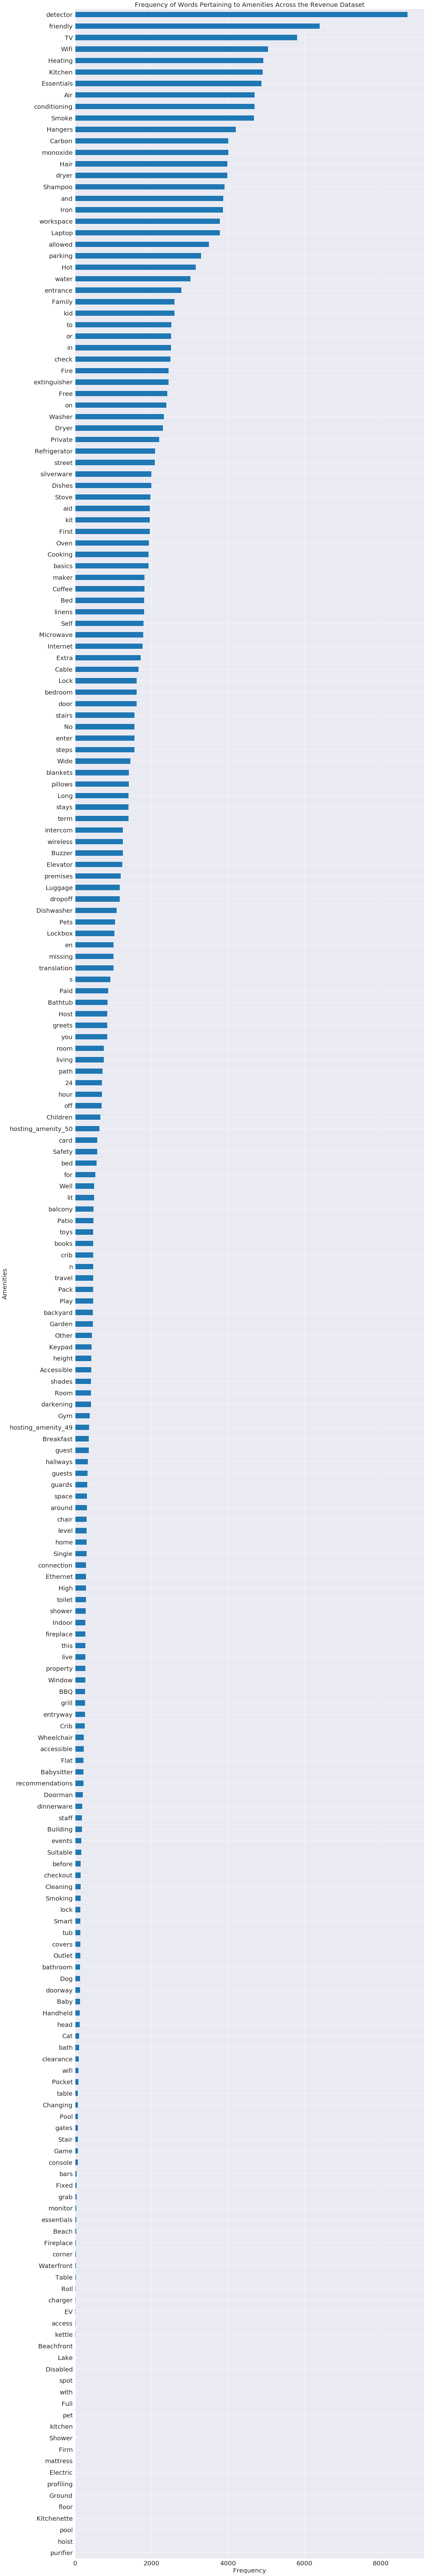

In [269]:
amenities_proc.sum().sort_values(ascending=True).plot(kind='barh', figsize=(20,150), fontsize=20)
plt.title('Frequency of Words Pertaining to Amenities Across the Revenue Dataset', fontsize=20)
plt.ylabel('Amenities', fontsize=20)
plt.xlabel('Frequency', fontsize=20)

It is a possibility that noun-phrases (in context of NLP) were not correctly grouped together - a limitation of our transformation (look at *Smoke* and *detector* in the frequency chart above). However, if parts of the noun-phrase have same frequencies, we can still group different words pertaining to the noun-phrase by assumption. The frequency chart also makes it clear that many words may not be relevant to our analysis.

The list of words pertaining to amenities (let's call them **amenity word**) that seem critical to consumers are listed as:

In [270]:
critical_amen = ['TV', 
                 'Wifi', 
                 'Wheelchair', 
                 'Kitchen', 'Kitchenette', 'Dishes', 'Dishwasher', 'Microwave', 'Oven', 'Stove', 'Breakfast',
                 'Washer', 'Dryer',
                 'Heating', 'Air', # For Air conditioning
                 'Fire', # For Fire extinguisher
                 'Smoke', # For Smoke detector
                 'Gym',
                 'parking']
print(critical_amen)

['TV', 'Wifi', 'Wheelchair', 'Kitchen', 'Kitchenette', 'Dishes', 'Dishwasher', 'Microwave', 'Oven', 'Stove', 'Breakfast', 'Washer', 'Dryer', 'Heating', 'Air', 'Fire', 'Smoke', 'Gym', 'parking']


It is to be noted that a few words pertaining to amenities mentioned above are usually paired with their other words to form the appropriate noun-phrase (eg. Fire extinguisher). To verify that our amenity words are sufficient to describe the presence of the noun-phrase referring to the amenity as such, we devise a heuristic utility set function to justify our assumption, that shows the lengths of rows containing the amenity word (eg. Fire), its counterpart word (eg. extinguisher) and their intersection of rows containing both of them.     

In [271]:
# Heuristic utility to find lengths
def return_set_lengths_approx(dataset, col1, col2):
    """Returns approximate lengths of set col1, set col2 and intersection of col1 and col2;
       calculated by checking presence of word in a row, not its frequency 
    Args:
        dataset: DataFrame reference to amenities dataset
        col1: String pertaining to first column matching a noun-phrase part (Amenity Word)
        col2: String pertaining to second column matching a noun-phrase part
    Returns:
        Prints lengths of respective sets mentioned above
    """
    dataset = dataset.copy()
    print('Length of '+ col1 + ':  ' + str(len(dataset[(dataset[col1] > 0)])) + '  (amenity word)')
    print('Length of '+ col2 + ':  ' + str(len(dataset[(dataset[col2] > 0)])))
    print('Length of '+ col1 + '-' +  col2 +' Intersection:  ' + str(len(dataset[(dataset[col1] > 0) & (dataset[col2] > 0)])))

It can be seen that our amenity words tend to approximate the presence of the real amenities (noun-phrases that are completely made using the amenity name + counterpart word) as mentioned in the listing.

In [272]:
return_set_lengths_approx(amenities_proc, 'Smoke', 'detector')
return_set_lengths_approx(amenities_proc, 'Air', 'conditioning')
return_set_lengths_approx(amenities_proc, 'Fire', 'extinguisher')
return_set_lengths_approx(amenities_proc, 'TV', 'Cable')

Length of Smoke:  4682  (amenity word)
Length of detector:  4705
Length of Smoke-detector Intersection:  4682
Length of Air:  4700  (amenity word)
Length of conditioning:  4700
Length of Air-conditioning Intersection:  4700
Length of Fire:  2450  (amenity word)
Length of extinguisher:  2450
Length of Fire-extinguisher Intersection:  2450
Length of TV:  4183  (amenity word)
Length of Cable:  1662
Length of TV-Cable Intersection:  1662


Thus, by regarding the availability of each amenity as equally important, we can aggregate the number of amenities as follows, based on our amenity word list:

In [273]:
num_amenities = amenities_proc.loc[:, critical_amen].clip(lower=0,upper=1).sum(axis=1)
num_amenities

48        8
52       11
61       16
62       13
66       10
         ..
48055    11
48121    11
48228    10
48351     5
48410     8
Length: 5099, dtype: int64

In [274]:
print('Number of rows in the revenue dataset: {}'.format(revenue_df_raw.shape[0])) # number of rows

Number of rows in the revenue dataset: 5105


But it looks like our aggregated amenities list is missing 16 samples. What happened here?

The regex word parser, while working on the raw revenue dataset, created empty lists for AirBnB properties that did not offer any amenities. This can be verified as below:    

In [275]:
rdf_words.apply(lambda amenities_list: 1 if len(amenities_list) == 0 else 0).sum()

6

To solve this problem, we can simply default number of amenities for such properties to the value of zero. Thus, the number of amenities column in our revenue dataset can be formulated without issues: 

In [276]:
revenue_df_raw['number_of_amenities'] = 0
revenue_df_raw.loc[revenue_df_raw.index.isin(num_amenities.index), 'number_of_amenities'] = num_amenities.copy()

Furthermore,the *amenities* column can be removed to save memory. 

In [277]:
revenue_df_proc = revenue_df_raw.drop('amenities', axis=1)

Our processed revenue dataset has the following properties:

In [278]:
revenue_df_proc.info(verbose=True, null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5105 entries, 48 to 48410
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   id                            5105 non-null   int64   
 1   neighbourhood_cleansed        5105 non-null   category
 2   neighbourhood_group_cleansed  5105 non-null   category
 3   zipcode                       5105 non-null   category
 4   latitude                      5105 non-null   float64 
 5   longitude                     5105 non-null   float64 
 6   is_location_exact             5105 non-null   category
 7   property_type                 5105 non-null   category
 8   room_type                     5105 non-null   category
 9   accommodates                  5105 non-null   int64   
 10  bathrooms                     5105 non-null   float64 
 11  beds                          5105 non-null   float64 
 12  price                         5105 non-null   

The revenue dataset memory consumption, which earlier spanned in the order of MBs, has been brought down to a few 100's of KBs by preprocessing and keeping relevant data in tact. These gains are huge; with respects to scalability of the dataset and the data cleaning pipeline.       

####  Filtering out State Column and Unwanted Zipcodes from Revenue & Cost Datasets 
A copy of the portion of the processed revenue dataset with uncommon zipcodes to the cost dataset is saved for future purposes. This would be useful during future analysis as and when our cost dataset is augmented with more information pretaining to previously uncommon NYC zipcodes. A copy of the relevant processed revenue dataset having zipcodes to the cost dataset is also backed up in this section.

We define a utility to backup a dataset. 

In [279]:
def backup_dataset(dataset, fpath, tag=None, ignore=False):
    """Backup the given dataset to a given path
    Args:
        dataset: DataFrame to be saved
        fpath: Location of the dataset to be saved
        tag: String to tag the version of backup/add comments, if needed
        ignore: Ignore function call (to prevent multiple similar backups when the notebook is rerun)
    
    Returns:
        True: Boolean If the backup was completed successfully 
        False: Boolean If the backup was unsuccessful
    """
    if not ignore:
        backup_version = str(datetime.now().strftime("--%Y-%m-%d--%Hh-%Mm-%Ss"))
        fpath = path.splitext(fpath) # tuple containing: path to file + extension of file
        proc_path = ''
        try:
            dataset = dataset.copy()
            if tag and isinstance(tag, str):
                proc_path = fpath[0] + backup_version + '--' + tag + fpath[1]            
            elif tag and not isinstance(tag, str):
                raise TypeError('The tag argument should be of type \'str\'')
            else:
                proc_path = fpath[0] + backup_version + fpath[1]
            dataset.to_csv(proc_path)
            print('[+] Given dataset is backed up @ {}'.format(proc_path))
            return True    
        except Exception as e:
            print('[-] An error occurred ...')
            print(e)
            return False
    else:
        print('[-] Backup line ignored ... ')
        return True

The cost dataset has zipcodes that do not specifically pertain to NYC. There are two ways to handle unwanted zipcodes:
1. Join revenue and cost datasets on their unique zipcodes (more time consuming)
2. Create a hash set of unique zipcodes from revenue dataset and remove rows from the cost dataset whose zipcodes don't lie in the specific range

We go ahead with option 2.

In [280]:
common_zipcodes = set(revenue_df_proc.zipcode.astype('int64').unique()).intersection(cost_df_raw.RegionName.unique())
cost_df_raw = cost_df_raw.loc[cost_df_raw.RegionName.isin(common_zipcodes), :].copy()

The dataset is forked into 2 portions - one having common zipcodes with cost dataset, the other having uncommon zipcodes the cost dataset. We backup these portions of our processed revenue dataset for in-memory fault tolerance. Before backup, the categorical variables' metadata have to updated to reflect the removal of values. This should help us save memory. 

In [281]:
# Filtering unwanted zipcodes for current analysis
revenue_df_uncommon_zip = revenue_df_proc.loc[~revenue_df_proc.zipcode.astype('int64').isin(common_zipcodes), :].copy()

print('Number of revenue dataset rows being discarded with uncommon cost dataset zipcodes: {0}, roughly about {1:0.2f} % of the total # of rows'.format(
    len(revenue_df_uncommon_zip),
    len(revenue_df_uncommon_zip)/len(revenue_df_proc) * 100
))

revenue_df_proc = revenue_df_proc.loc[revenue_df_proc.zipcode.astype('int64').isin(common_zipcodes), :].copy()

# Resetting categorical metadata before storing final data
for x in revenue_df_proc.select_dtypes('category'):
    revenue_df_proc[x].cat.remove_unused_categories(inplace=True)

# Backing up data
backup_dataset(revenue_df_uncommon_zip, AIRBNB_DS_UNCOMMON_ZIP_BACKUP_PATH, 'first-copy', ignore=BACKUP_FLAG)
backup_dataset(revenue_df_proc, AIRBNB_DS_BACKUP_PATH, 'first-copy', ignore=BACKUP_FLAG)

Number of revenue dataset rows being discarded with uncommon cost dataset zipcodes: 3921, roughly about 76.81 % of the total # of rows
[-] Backup line ignored ... 
[-] Backup line ignored ... 


True

#### Tidying Cost Dataset before further Exploratory Data Analysis

A couple of backups for tidy versions of the cost dataset are also taken in this section. 

Firstly, we define a utility function to draw of line plot of median prices:

In [282]:
def trend_plot(dataset, title, yr_low=2004):
    """Plots a trend plot for cost dataset having date, zipcodes and median price as columns
    Args:
        dataset: Cost DataFrame
        title: Chart title
        yr_low: Year value above which the trend plot is drawn
    """    
    dataset = dataset.copy()
    dataset[dataset.Date.dt.year > yr_low].pivot(index='Date', columns='RegionName', values='MedianPrice').plot(figsize=(20,15))
    plt.title(title)
    plt.legend(title='Zipcodes')

The cost dataset looks like this:

In [283]:
cost_df_raw.head()

RegionName  SizeRank  1996-04  1996-05  1996-06  1996-07  1996-08  \
0        10025         1      NaN      NaN      NaN      NaN      NaN   
2        10023         3      NaN      NaN      NaN      NaN      NaN   
13       10128        14      NaN      NaN      NaN      NaN      NaN   
14       10011        15      NaN      NaN      NaN      NaN      NaN   
20       10003        21      NaN      NaN      NaN      NaN      NaN   

    1996-09  1996-10  1996-11  ...  2016-09  2016-10  2016-11    2016-12  \
0       NaN      NaN      NaN  ...  1374400  1364100  1366300  1354800.0   
2       NaN      NaN      NaN  ...  1993500  1980700  1960900  1951300.0   
13      NaN      NaN      NaN  ...  1526000  1523700  1527200  1541600.0   
14      NaN      NaN      NaN  ...  2354000  2355500  2352200  2332100.0   
20      NaN      NaN      NaN  ...  1932800  1930400  1937500  1935100.0   

    2017-01  2017-02  2017-03  2017-04  2017-05  2017-06  
0   1327500  1317300  1333700  1352100  1390000  1431000  
2   1937800  1929800  1955000  2022400  2095000  2142300  
13  1557800  1582900  1598900  1646100  1720500  1787100  
14  2313300  2319600  2342100  2365900  2419700  2480400  
20  1915700  1916500  1965700  2045300  2109100  2147000  

[5 rows x 257 columns]

A 'tidier' version of the cost dataset looks like: 

In [284]:
# Tidying cost dataset
cost_df_raw = pd.melt(
    cost_df_raw, id_vars=['RegionName', 'SizeRank'],
    var_name='Date', value_name='MedianPrice'
).sort_values(
    ['RegionName', 'Date']
).copy()

cost_df_raw

RegionName  SizeRank     Date  MedianPrice
4          10003        21  1996-04          NaN
28         10003        21  1996-05          NaN
52         10003        21  1996-06          NaN
76         10003        21  1996-07          NaN
100        10003        21  1996-08          NaN
...          ...       ...      ...          ...
6013       11434       622  2017-02     361900.0
6037       11434       622  2017-03     370800.0
6061       11434       622  2017-04     377100.0
6085       11434       622  2017-05     380200.0
6109       11434       622  2017-06     382300.0

[6120 rows x 4 columns]

It would make sense to represent the Date column as a datetime type, which would handle resampling median prices in special cases, for eg. leap years.

In [285]:
cost_df_raw.Date = pd.to_datetime(cost_df_raw.Date)
cost_df_raw

RegionName  SizeRank       Date  MedianPrice
4          10003        21 1996-04-01          NaN
28         10003        21 1996-05-01          NaN
52         10003        21 1996-06-01          NaN
76         10003        21 1996-07-01          NaN
100        10003        21 1996-08-01          NaN
...          ...       ...        ...          ...
6013       11434       622 2017-02-01     361900.0
6037       11434       622 2017-03-01     370800.0
6061       11434       622 2017-04-01     377100.0
6085       11434       622 2017-05-01     380200.0
6109       11434       622 2017-06-01     382300.0

[6120 rows x 4 columns]

If we wanted to compute and fix the breakeven years, we should smoothen the cost time series by resampling yearly; one benefit of doing the same is that we can lessen the effects of noise (evident once we plot the line chart). We might need to drop *SizeRank* column, but that column should be easily recoverable from the raw cost dataset version. 

In [286]:
cost_df_tidy = cost_df_raw.drop(
    'SizeRank', axis=1
).set_index(
    'Date'
).groupby(
    'RegionName'
)['MedianPrice'].resample(
    'YS'
).mean().reset_index()

cost_df_tidy

RegionName       Date    MedianPrice
0         10003 1996-01-01            NaN
1         10003 1997-01-01            NaN
2         10003 1998-01-01            NaN
3         10003 1999-01-01            NaN
4         10003 2000-01-01            NaN
..          ...        ...            ...
523       11434 2013-01-01  266933.333333
524       11434 2014-01-01  281158.333333
525       11434 2015-01-01  297491.666667
526       11434 2016-01-01  336333.333333
527       11434 2017-01-01  371633.333333

[528 rows x 3 columns]

Let us compare before and after yearly average smoothing the median prices for properties belonging to the specific zipcodes:

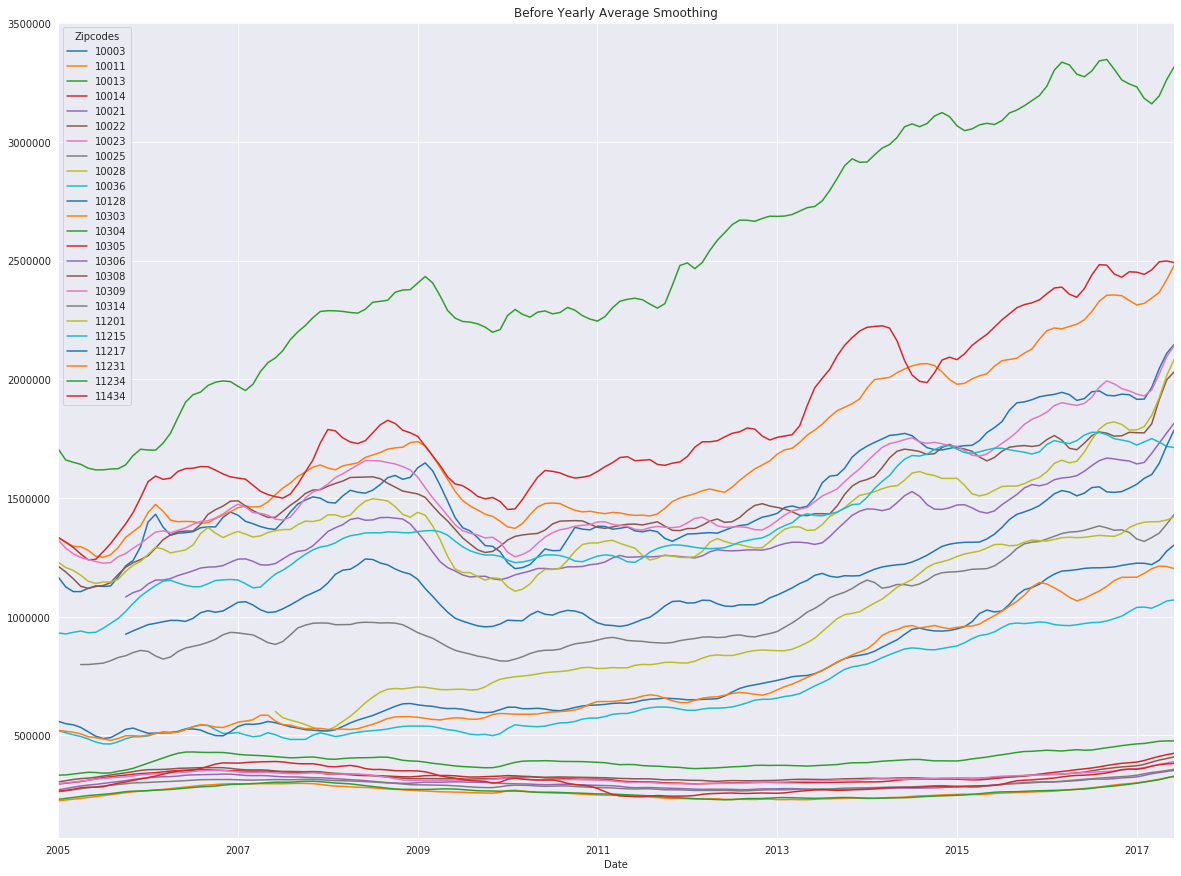

In [287]:
trend_plot(cost_df_raw, 'Before Yearly Average Smoothing')

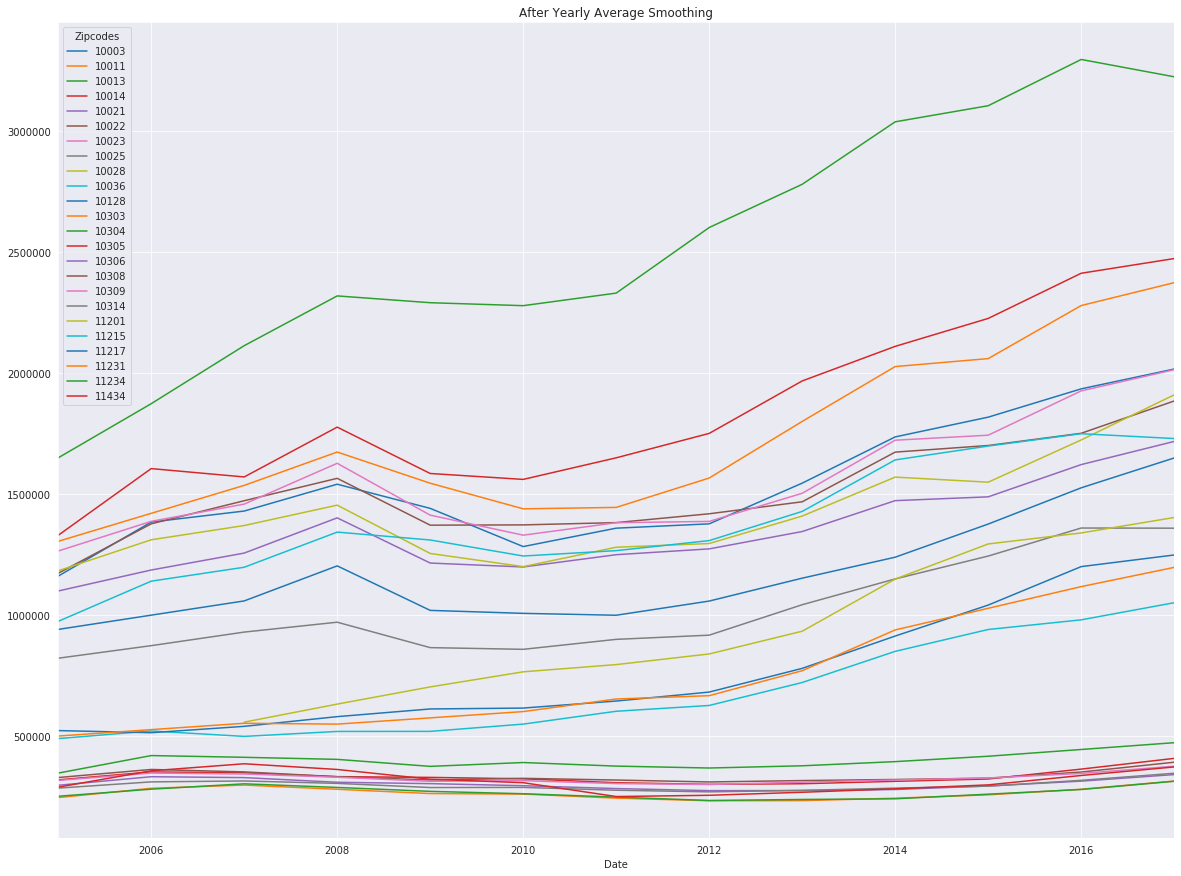

In [288]:
trend_plot(cost_df_tidy, 'After Yearly Average Smoothing')

It is clear that the yearly averaged cost dataset captures the underlying effective trend of the median prices (i.e., do median prices increase or decrease with time? this is more easily decipherable).

One important point to note is that, yearly median prices for almost all zipcodes tend to remain the same or increase only by a small amount with time. This means that we might as well consider the last available year's median price as a 'proxy' (assumption that the median property price remains constant) for basing our thougts on when computing the breakeven time after purchasing a property.  

The *SizeRank* column is appended back to a tidy version of the cost dataset.

In [289]:
cost_df_proc = pd.merge(
    cost_df_raw[['RegionName', 'SizeRank']].drop_duplicates().copy(), 
    cost_df_tidy, 
    on='RegionName'
).rename(columns={'RegionName': 'zipcode', 'Date': 'date', 'SizeRank': 'size_rank', 'MedianPrice': 'median_price'})

cost_df_proc.head()

zipcode  size_rank       date  median_price
0    10003         21 1996-01-01           NaN
1    10003         21 1997-01-01           NaN
2    10003         21 1998-01-01           NaN
3    10003         21 1999-01-01           NaN
4    10003         21 2000-01-01           NaN

We are mostly concerned with the last year for the average median price to compute breakeven years if a property in the corresponding zipcode is purchased. We could normalize (in terms of the data model) further to remove redundancy, but again we are only concerned with the latest year. We can filter out unwanted years from our analysis. The latest year of average median price we have is:

In [290]:
cost_df_proc.date.dt.year.max()

2017

We backup the tidy cost dataset temporarily as well as its latest-year filtered version, as follows:

In [291]:
# Transforming and backing up data
backup_dataset(cost_df_proc, ZILLOW_DS_NONFILTERED_BACKUP_PATH, tag='first-copy', ignore=BACKUP_FLAG)
cost_df_proc = cost_df_proc.loc[cost_df_proc.date.dt.year == cost_df_proc.date.dt.year.max(), :]
backup_dataset(cost_df_proc, ZILLOW_DS_BACKUP_PATH, tag='first-copy', ignore=BACKUP_FLAG)

[-] Backup line ignored ... 
[-] Backup line ignored ... 


True

Finally, we store the latest year in a variable and drop the date column as it provides redundant information:

In [292]:
cost_df_year = cost_df_proc.iloc[0].date.year
cost_df_proc.drop('date', axis=1, inplace=True)

In [293]:
cost_df_proc.head()

zipcode  size_rank  median_price
21     10003         21  2.016550e+06
43     10011         15  2.373500e+06
65     10013       1744  3.224517e+06
87     10014        379  2.473150e+06
109    10021        190  1.717183e+06

We consider the above the data to be 'tidy' enough for our analysis

# Quick Exploratory Data Analysis (EDA)

A second phase of EDA is quickly performed to confirm our data meets the quality standards of 'clean data' for analysis purposes. To get a better understanding of the datasets in general, it would helpful to mine several interesting preliminary insights that could help us in defining the performance metrics for the decision making process. 

Please note that as data scale in size (eg. exabytes), it may be appropriate to randomly sample rows that represent the population, or use other scalable big data processing engines (distributed computing solutions like Spark) to perform large-scale EDA.     

### Revenue Dataset 

Our AirBnB Revenue dataset can be summarized as follows:

In [294]:
print('Size of the dataset = {} rows, {} columns'.format(revenue_df_proc.shape[0], revenue_df_proc.shape[1]))

Size of the dataset = 1184 rows, 21 columns


In [295]:
revenue_df_proc.info(verbose=True, null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 66 to 47867
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   id                            1184 non-null   int64   
 1   neighbourhood_cleansed        1184 non-null   category
 2   neighbourhood_group_cleansed  1184 non-null   category
 3   zipcode                       1184 non-null   category
 4   latitude                      1184 non-null   float64 
 5   longitude                     1184 non-null   float64 
 6   is_location_exact             1184 non-null   category
 7   property_type                 1184 non-null   category
 8   room_type                     1184 non-null   category
 9   accommodates                  1184 non-null   int64   
 10  bathrooms                     1184 non-null   float64 
 11  beds                          1184 non-null   float64 
 12  price                         1184 non-null   

The memory for the reveue dataset has been optimized from MB's worth of data to just about 150 KB.

The dtypes care fairly consistent for the respective columns.

The descriptive statistics for the revenue dataset can be seen as: 

In [296]:
revenue_df_proc.describe()

id     latitude    longitude  accommodates    bathrooms  \
count  1.184000e+03  1184.000000  1184.000000   1184.000000  1184.000000   
mean   1.634988e+07    40.723565   -73.984462      4.487331     1.270270   
std    1.101237e+07     0.047675     0.033288      1.347428     0.443811   
min    1.645800e+04    40.522930   -74.212380      1.000000     0.000000   
25%    6.717022e+06    40.680820   -73.996663      4.000000     1.000000   
50%    1.610543e+07    40.729565   -73.987825      4.000000     1.000000   
75%    2.529912e+07    40.762367   -73.975930      5.000000     1.500000   
max    3.596121e+07    40.808150   -73.764540     16.000000     3.500000   

              beds        price  availability_30  number_of_reviews  \
count  1184.000000  1184.000000      1184.000000        1184.000000   
mean      2.413851   260.244088         5.476351          26.238176   
std       0.815744   188.593792         8.416330          44.216986   
min       0.000000    50.000000         0.000000           1.000000   
25%       2.000000   155.000000         0.000000           3.000000   
50%       2.000000   220.000000         1.000000           8.000000   
75%       3.000000   300.000000         8.000000          27.000000   
max       6.000000  2000.000000        30.000000         403.000000   

       review_scores_rating  review_scores_accuracy  \
count           1184.000000             1184.000000   
mean              94.154561                9.595439   
std                8.207099                0.806365   
min               20.000000                2.000000   
25%               92.000000                9.000000   
50%               96.000000               10.000000   
75%              100.000000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_location  review_scores_value  \
count                1184.000000             1184.000000          1184.000000   
mean                    9.303209                9.792230             9.314189   
std                     1.031273                0.626877             0.961262   
min                     2.000000                2.000000             2.000000   
25%                     9.000000               10.000000             9.000000   
50%                    10.000000               10.000000            10.000000   
75%                    10.000000               10.000000            10.000000   
max                    10.000000               10.000000            10.000000   

       number_of_amenities  
count          1184.000000  
mean              9.246622  
std               3.091994  
min               0.000000  
25%               7.000000  
50%               9.000000  
75%              12.000000  
max              16.000000

#### Univariate Analysis 

##### Histograms 

**Histogram** for all numeric attributes are as follows:

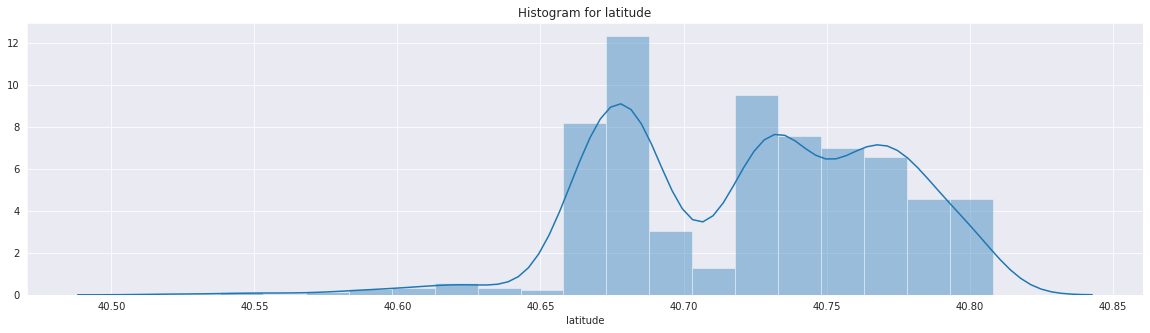

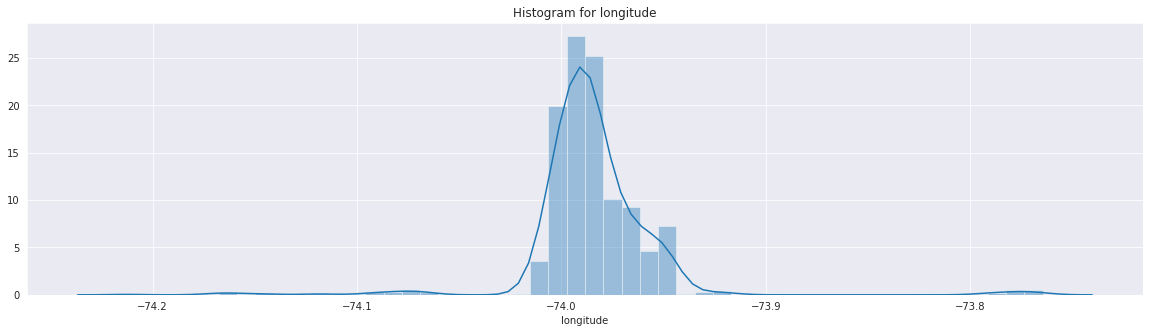

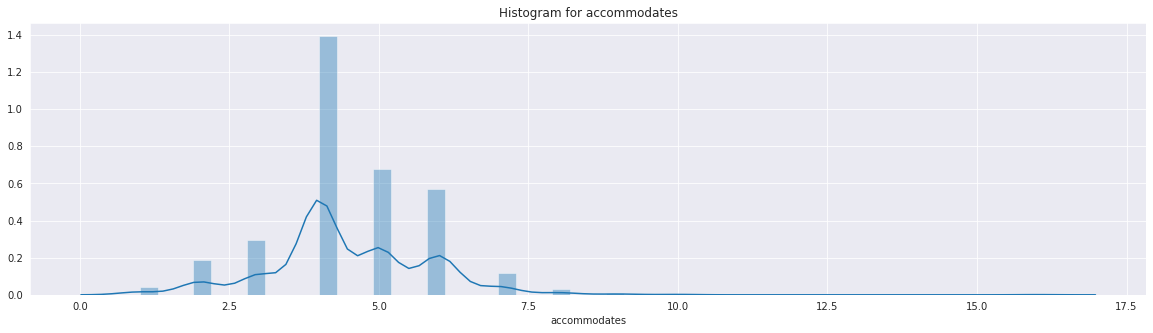

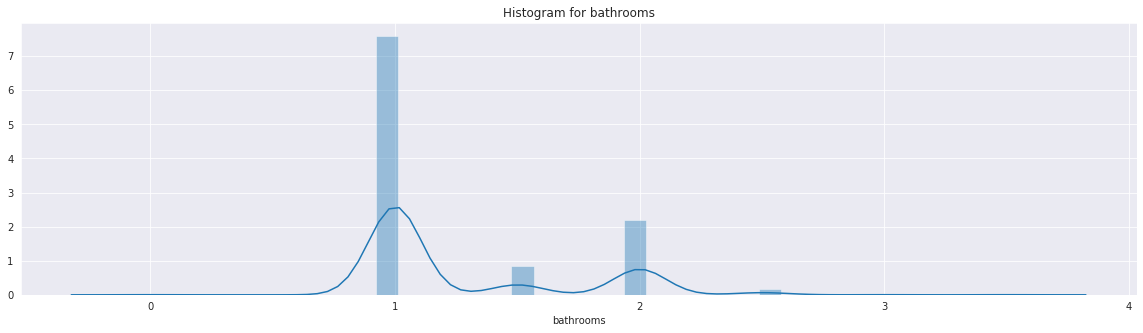

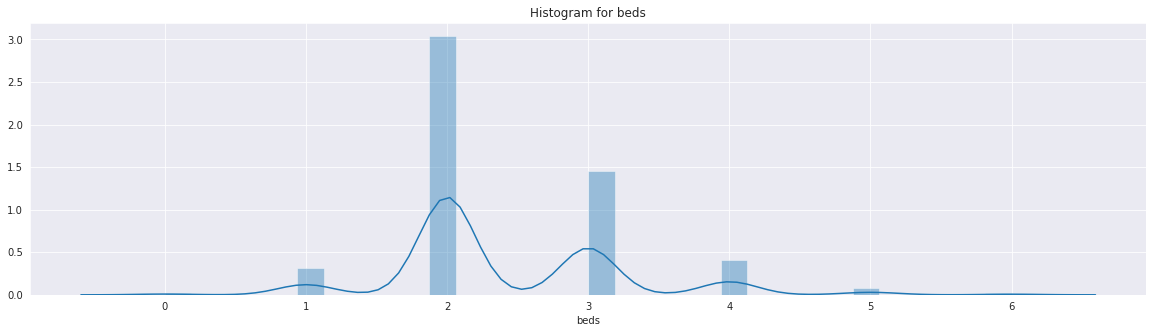

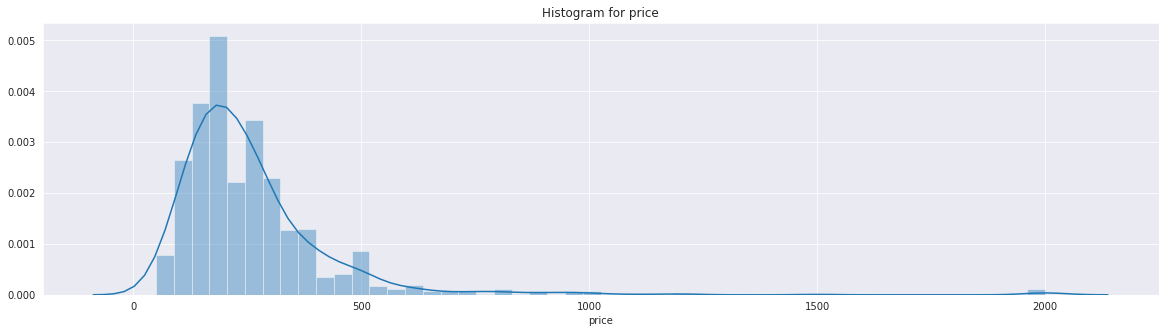

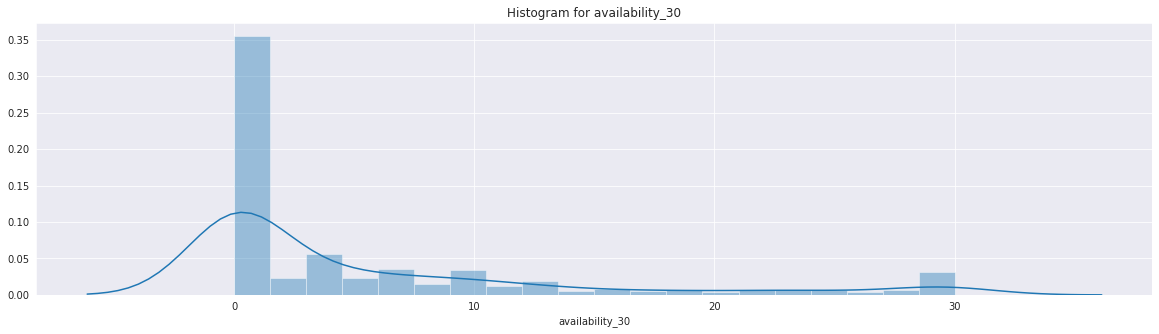

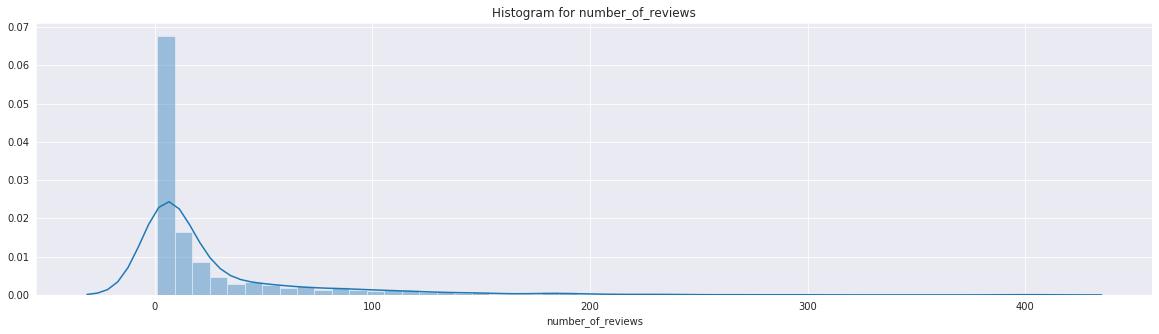

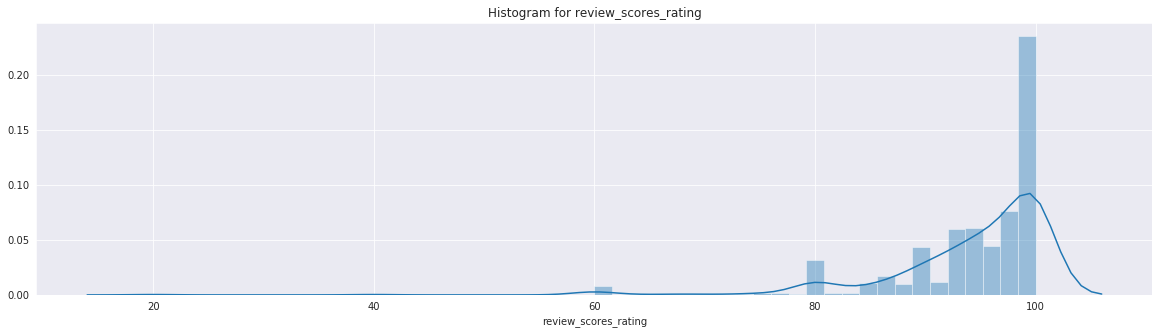

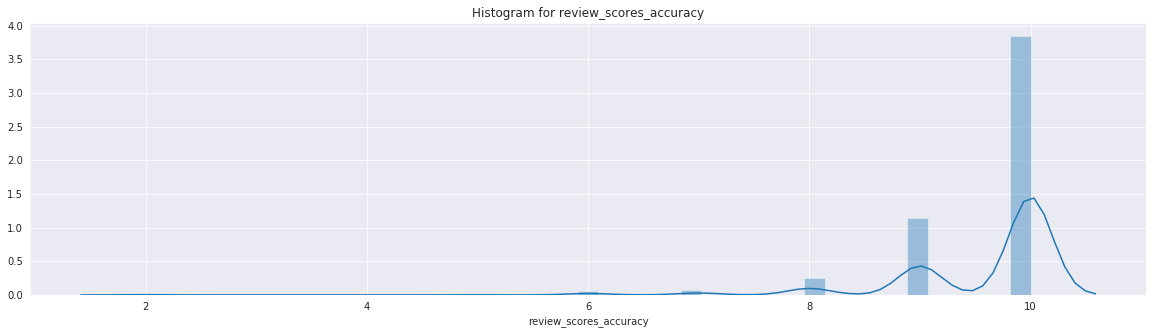

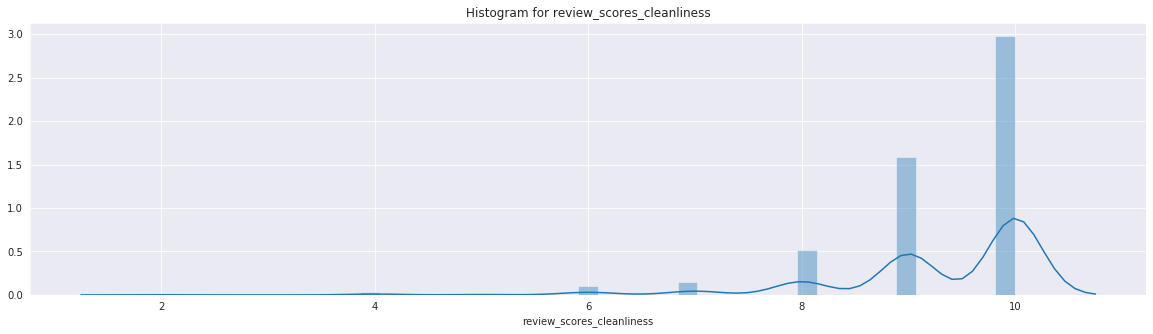

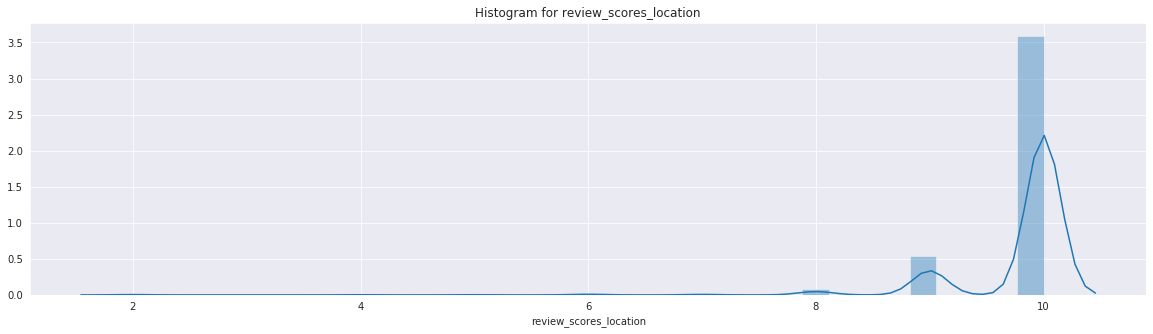

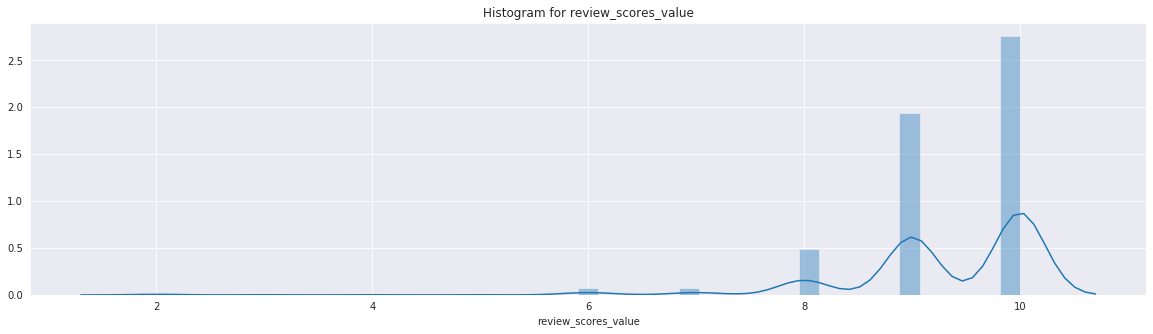

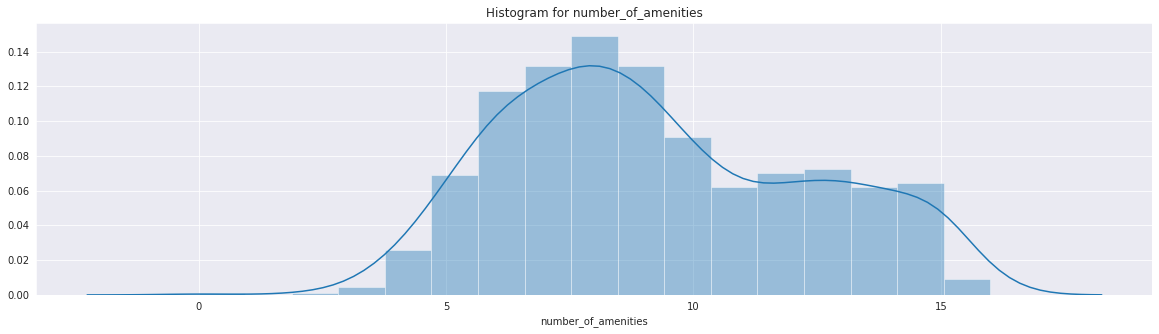

In [297]:
for column in revenue_df_proc.select_dtypes('number').drop('id', axis=1):
    plt.figure(figsize=(20, 5))
    sns.distplot(revenue_df_proc[column])
    plt.title('Histogram for ' + column)

We can see that *latitude* and *longitude* columns seem to indicate the presence of some outliers. This could be due to our decision of keeping some debatable zipcodes that controversially border (or) are within the border of NYC. The *price* (highly rent-pricey properties) and *availability_30* (properties not occupied by tenants for about a month) columns also provide some indication for outliers. From this quick glance of the possible nature of such outliers, we've decided to keep these outliers. We assume that such outliers should be helpful in ruling out unfit properties thereby pruning our analysis space and in turn help in determining lucrative properties.   

##### Count plots 

**Count plots** for categorical attributes are as follows:

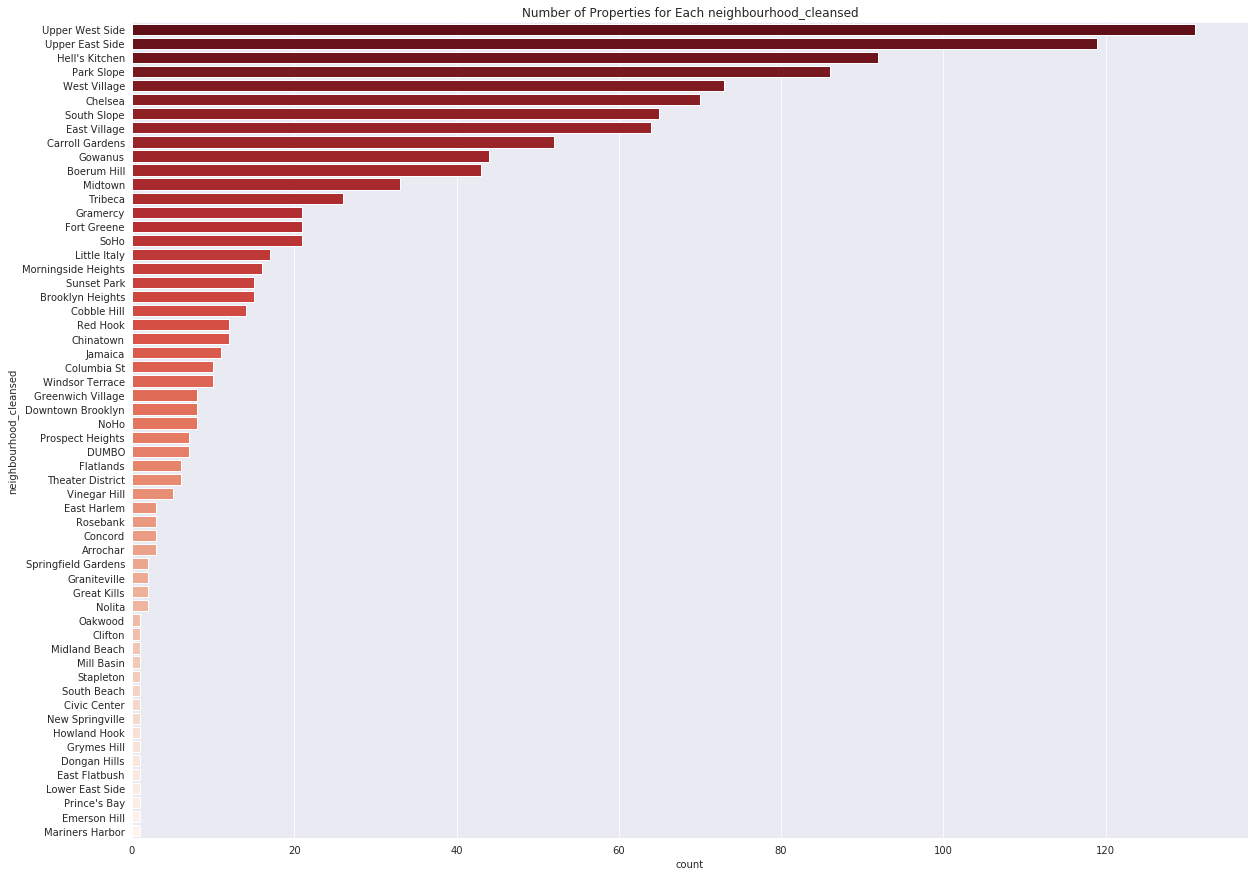

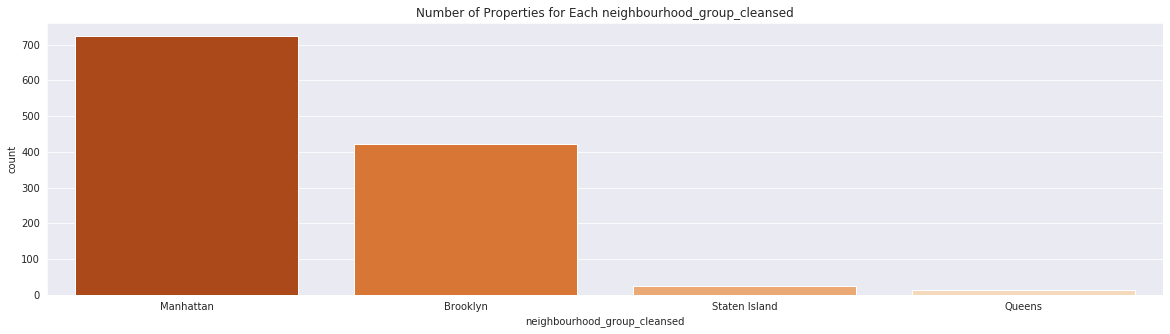

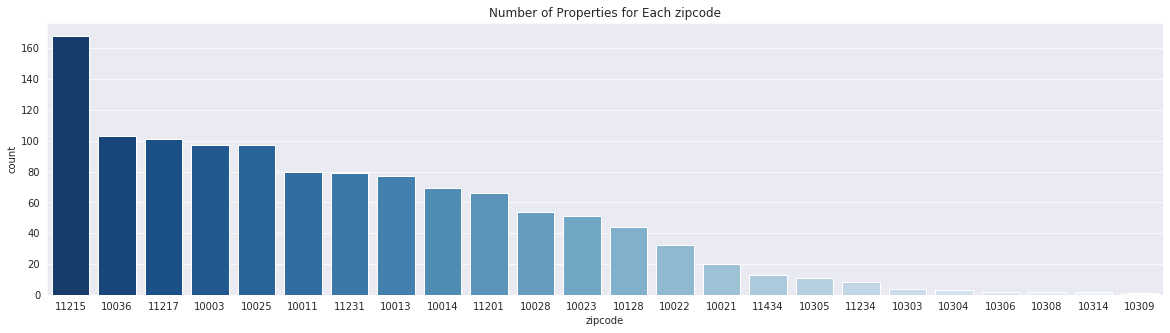

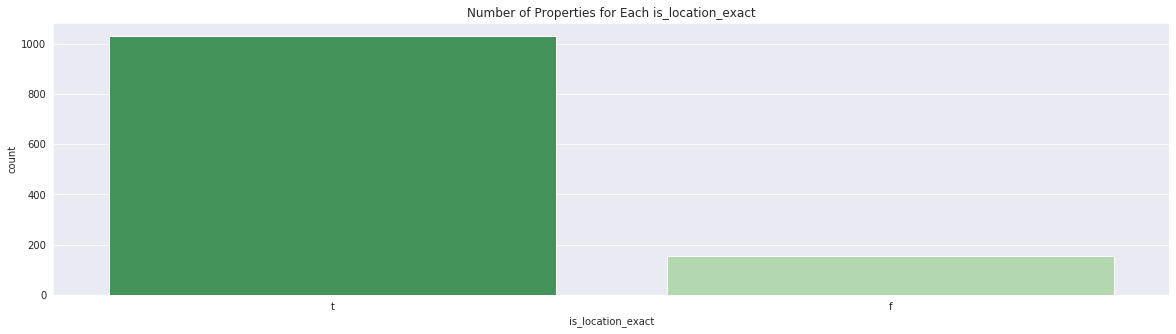

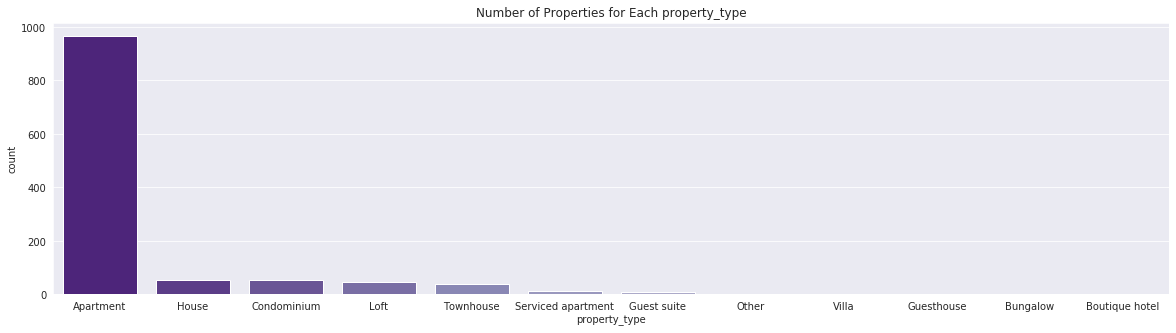

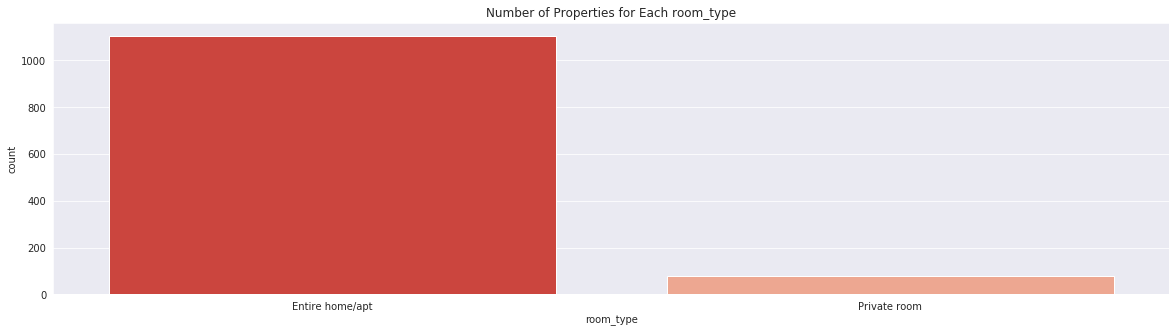

In [298]:
palette_cols = ['Reds_r', 'Oranges_r', 'Blues_r', 'Greens_r', 'Purples_r', 'Reds_r']
for i, column in enumerate(revenue_df_proc.select_dtypes('category')):
    if column in ['neighbourhood_cleansed']:
        plt.figure(figsize=(20, 15))
        sns.countplot(
            y=column, 
            data=revenue_df_proc, 
            order=revenue_df_proc[column].value_counts().index, 
            palette=sns.color_palette(palette_cols[i], len(revenue_df_proc[column].unique()))
        )
    else:
        plt.figure(figsize=(20, 5))
        sns.countplot(
            x=column, 
            data=revenue_df_proc, 
            order=revenue_df_proc[column].value_counts().index,
            palette=sns.color_palette(palette_cols[i], len(revenue_df_proc[column].unique()))
        )
    plt.title('Number of Properties for Each ' + column)    

The counplots are quite interesting: It was earlier checked that no two listing urls were the same in the revenue dataset, this means that each row is a unique listing of a property. It can also be inferred that the countplot gives the number of properties at each level of the categories, as displayed above.   

The following insights can be established:
1. The top three neighbourhoods with the most number of properties are in Manhattan - Upper West Side, Upper East Side and Hell's Kitchen 
2. Most of the AirBnB listings pertain to the Manhattan borough, followed by the Brooklyn borough. This shouldn't be any surprise, as many people consider Manhattan to be the most popular borough in NYC
3. The top three zipcodes which have a large number of properties are 11215, 10036 and 10003.
4. A large proportion of the spatial coordinates information (longitude + longitude) provided in the AirBnB listings are exact for the specific property listing.
5. Majority of the properties are apartment style.
6. Most property listings require the host to rent the entire home/apartment.

##### Q-Q Plots 

**Q-Q Plots** for verifying normality assumption of numeric attributes are shown below: 

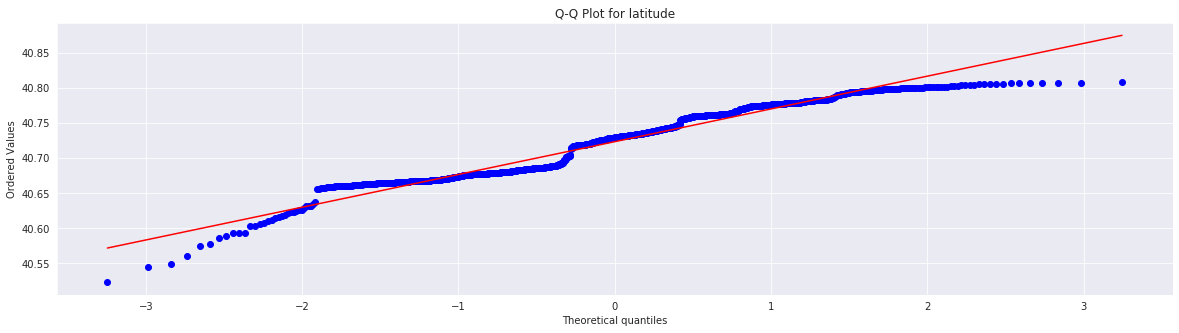

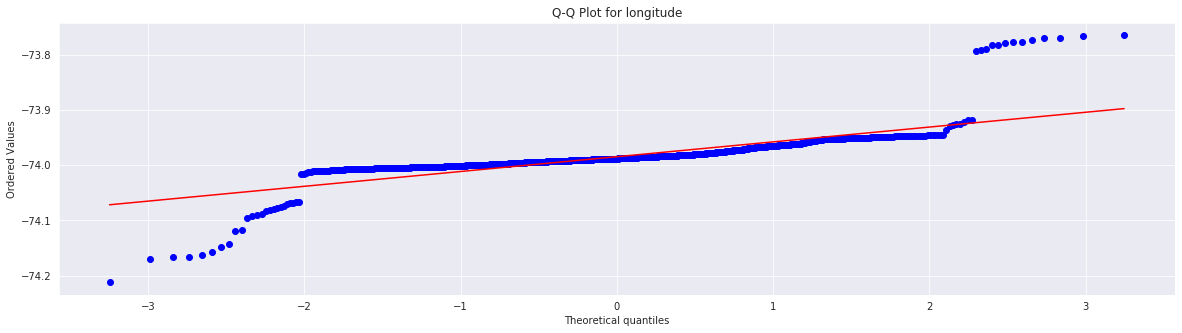

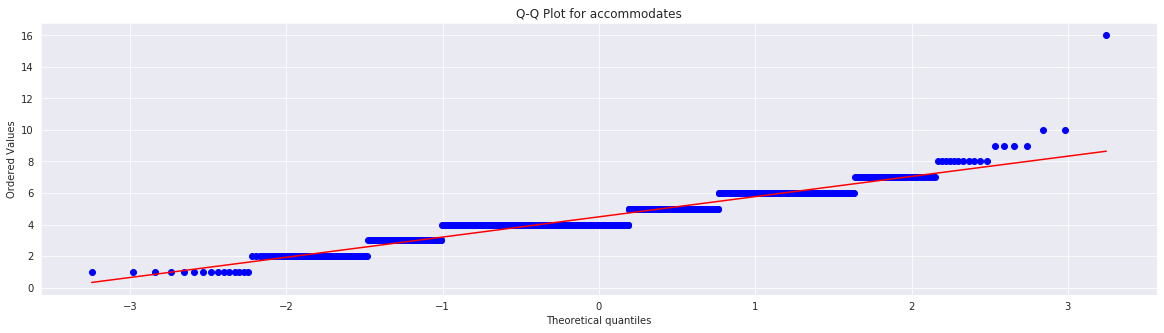

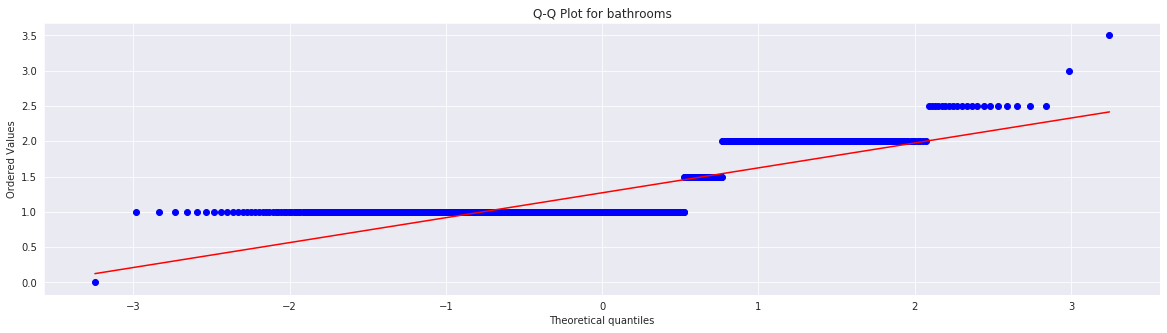

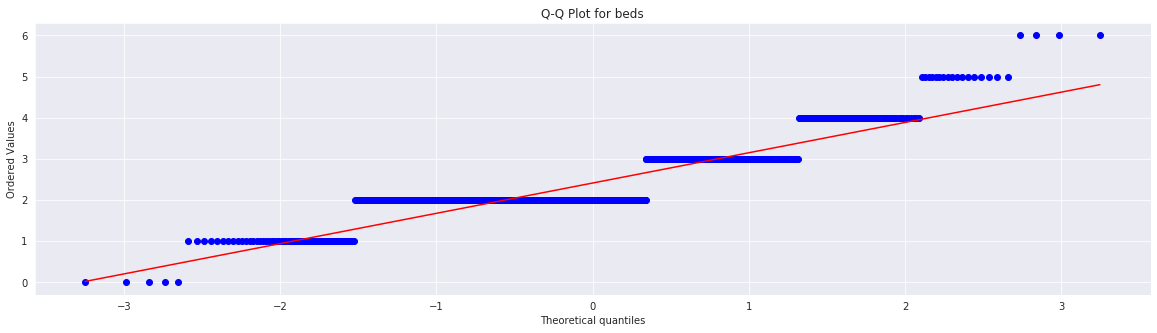

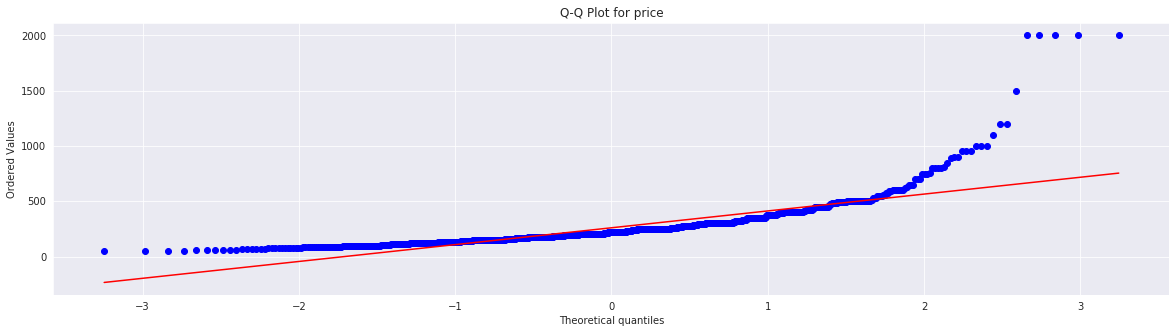

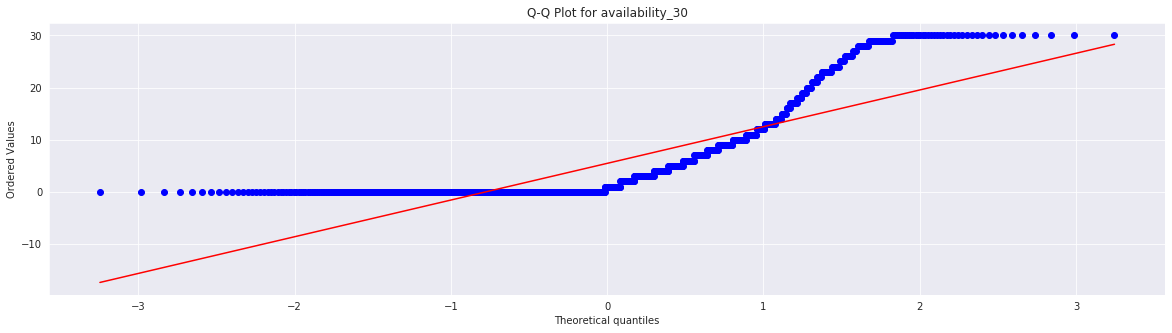

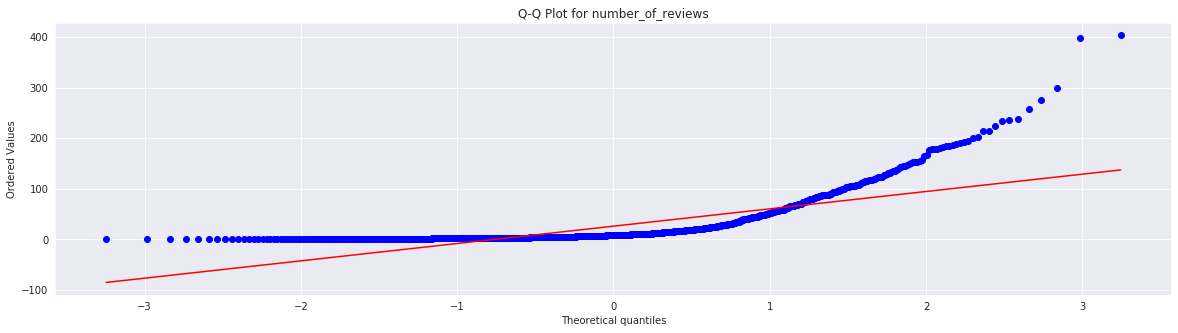

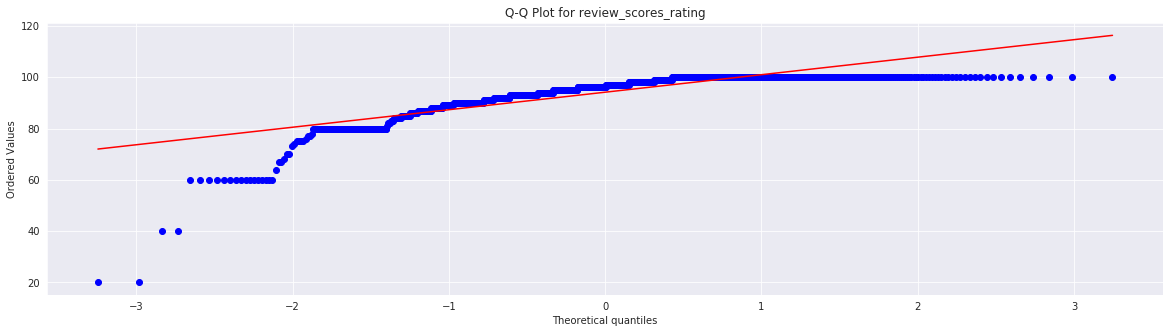

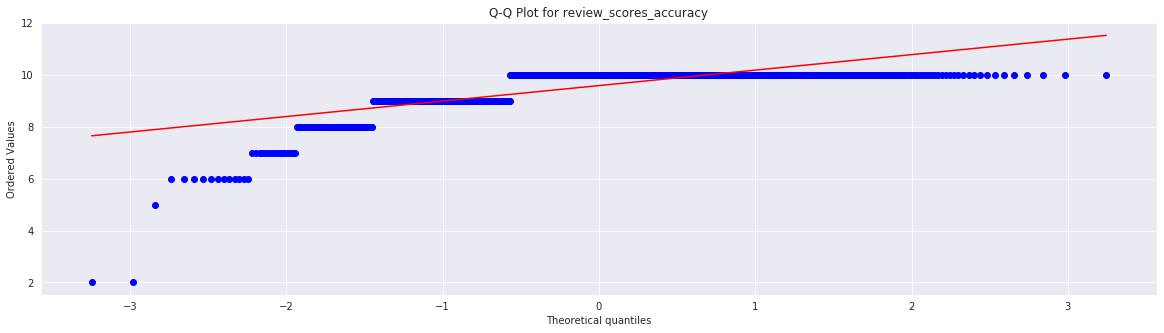

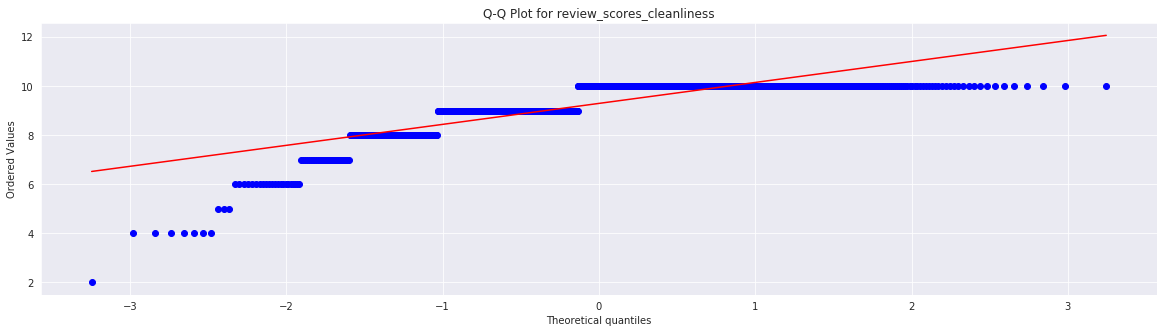

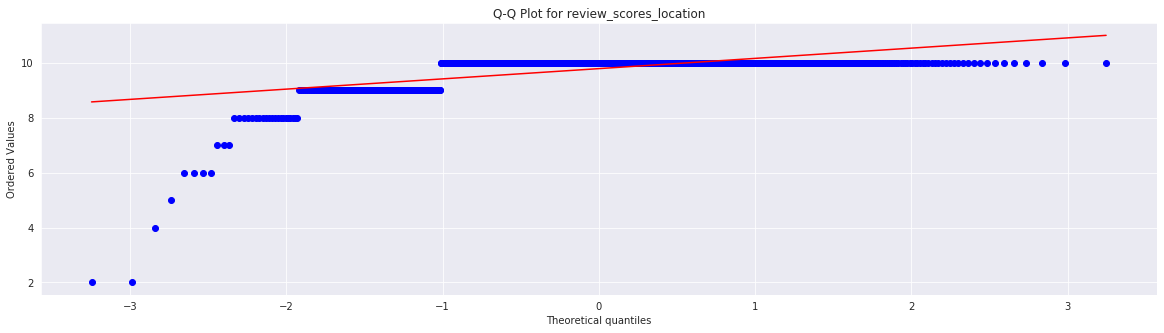

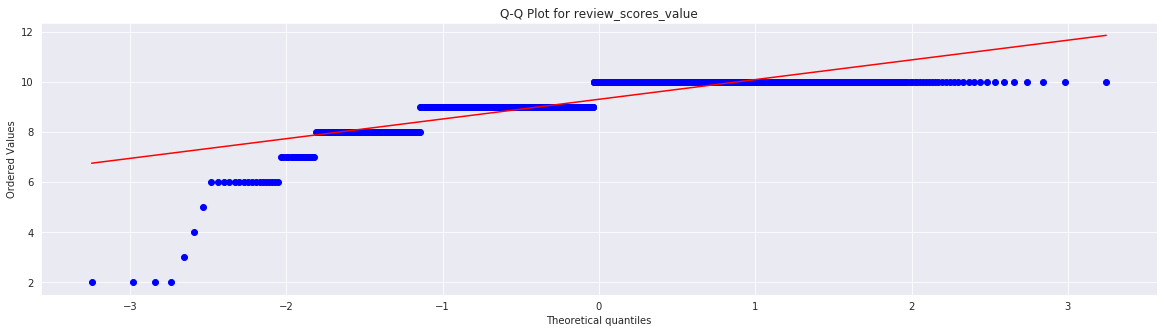

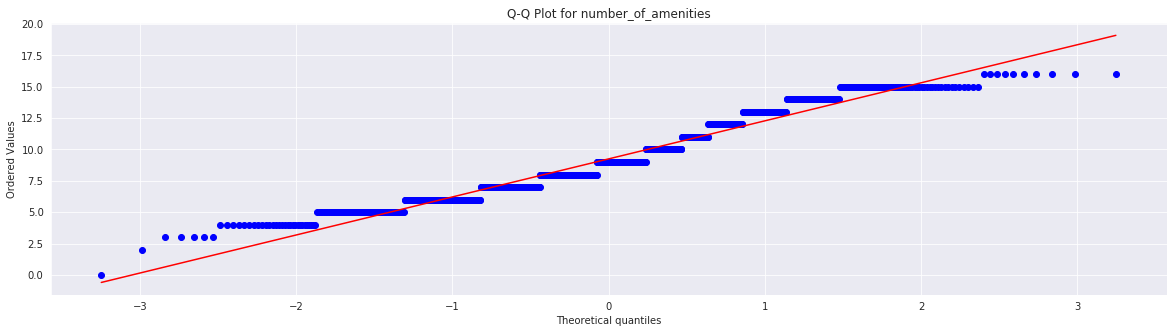

In [299]:
for column in revenue_df_proc.select_dtypes('number').drop('id', axis=1):
    plt.figure(figsize=(20, 5))
    probplot(revenue_df_proc[column], dist='norm', plot=plt)
    plt.title('Q-Q Plot for ' + column)

From the Q-Q plots, none of the numeric attributes seem to strongly follow the normality assumption. Future works involving machine learning models might need to take this into account 

#### Bivariate Analysis 

##### Pairwise Scatterplot Matrix 

**Pairwise Scatterplot Matrix** for numeric attributes, after removing potential outliers, can be estimated as follows:

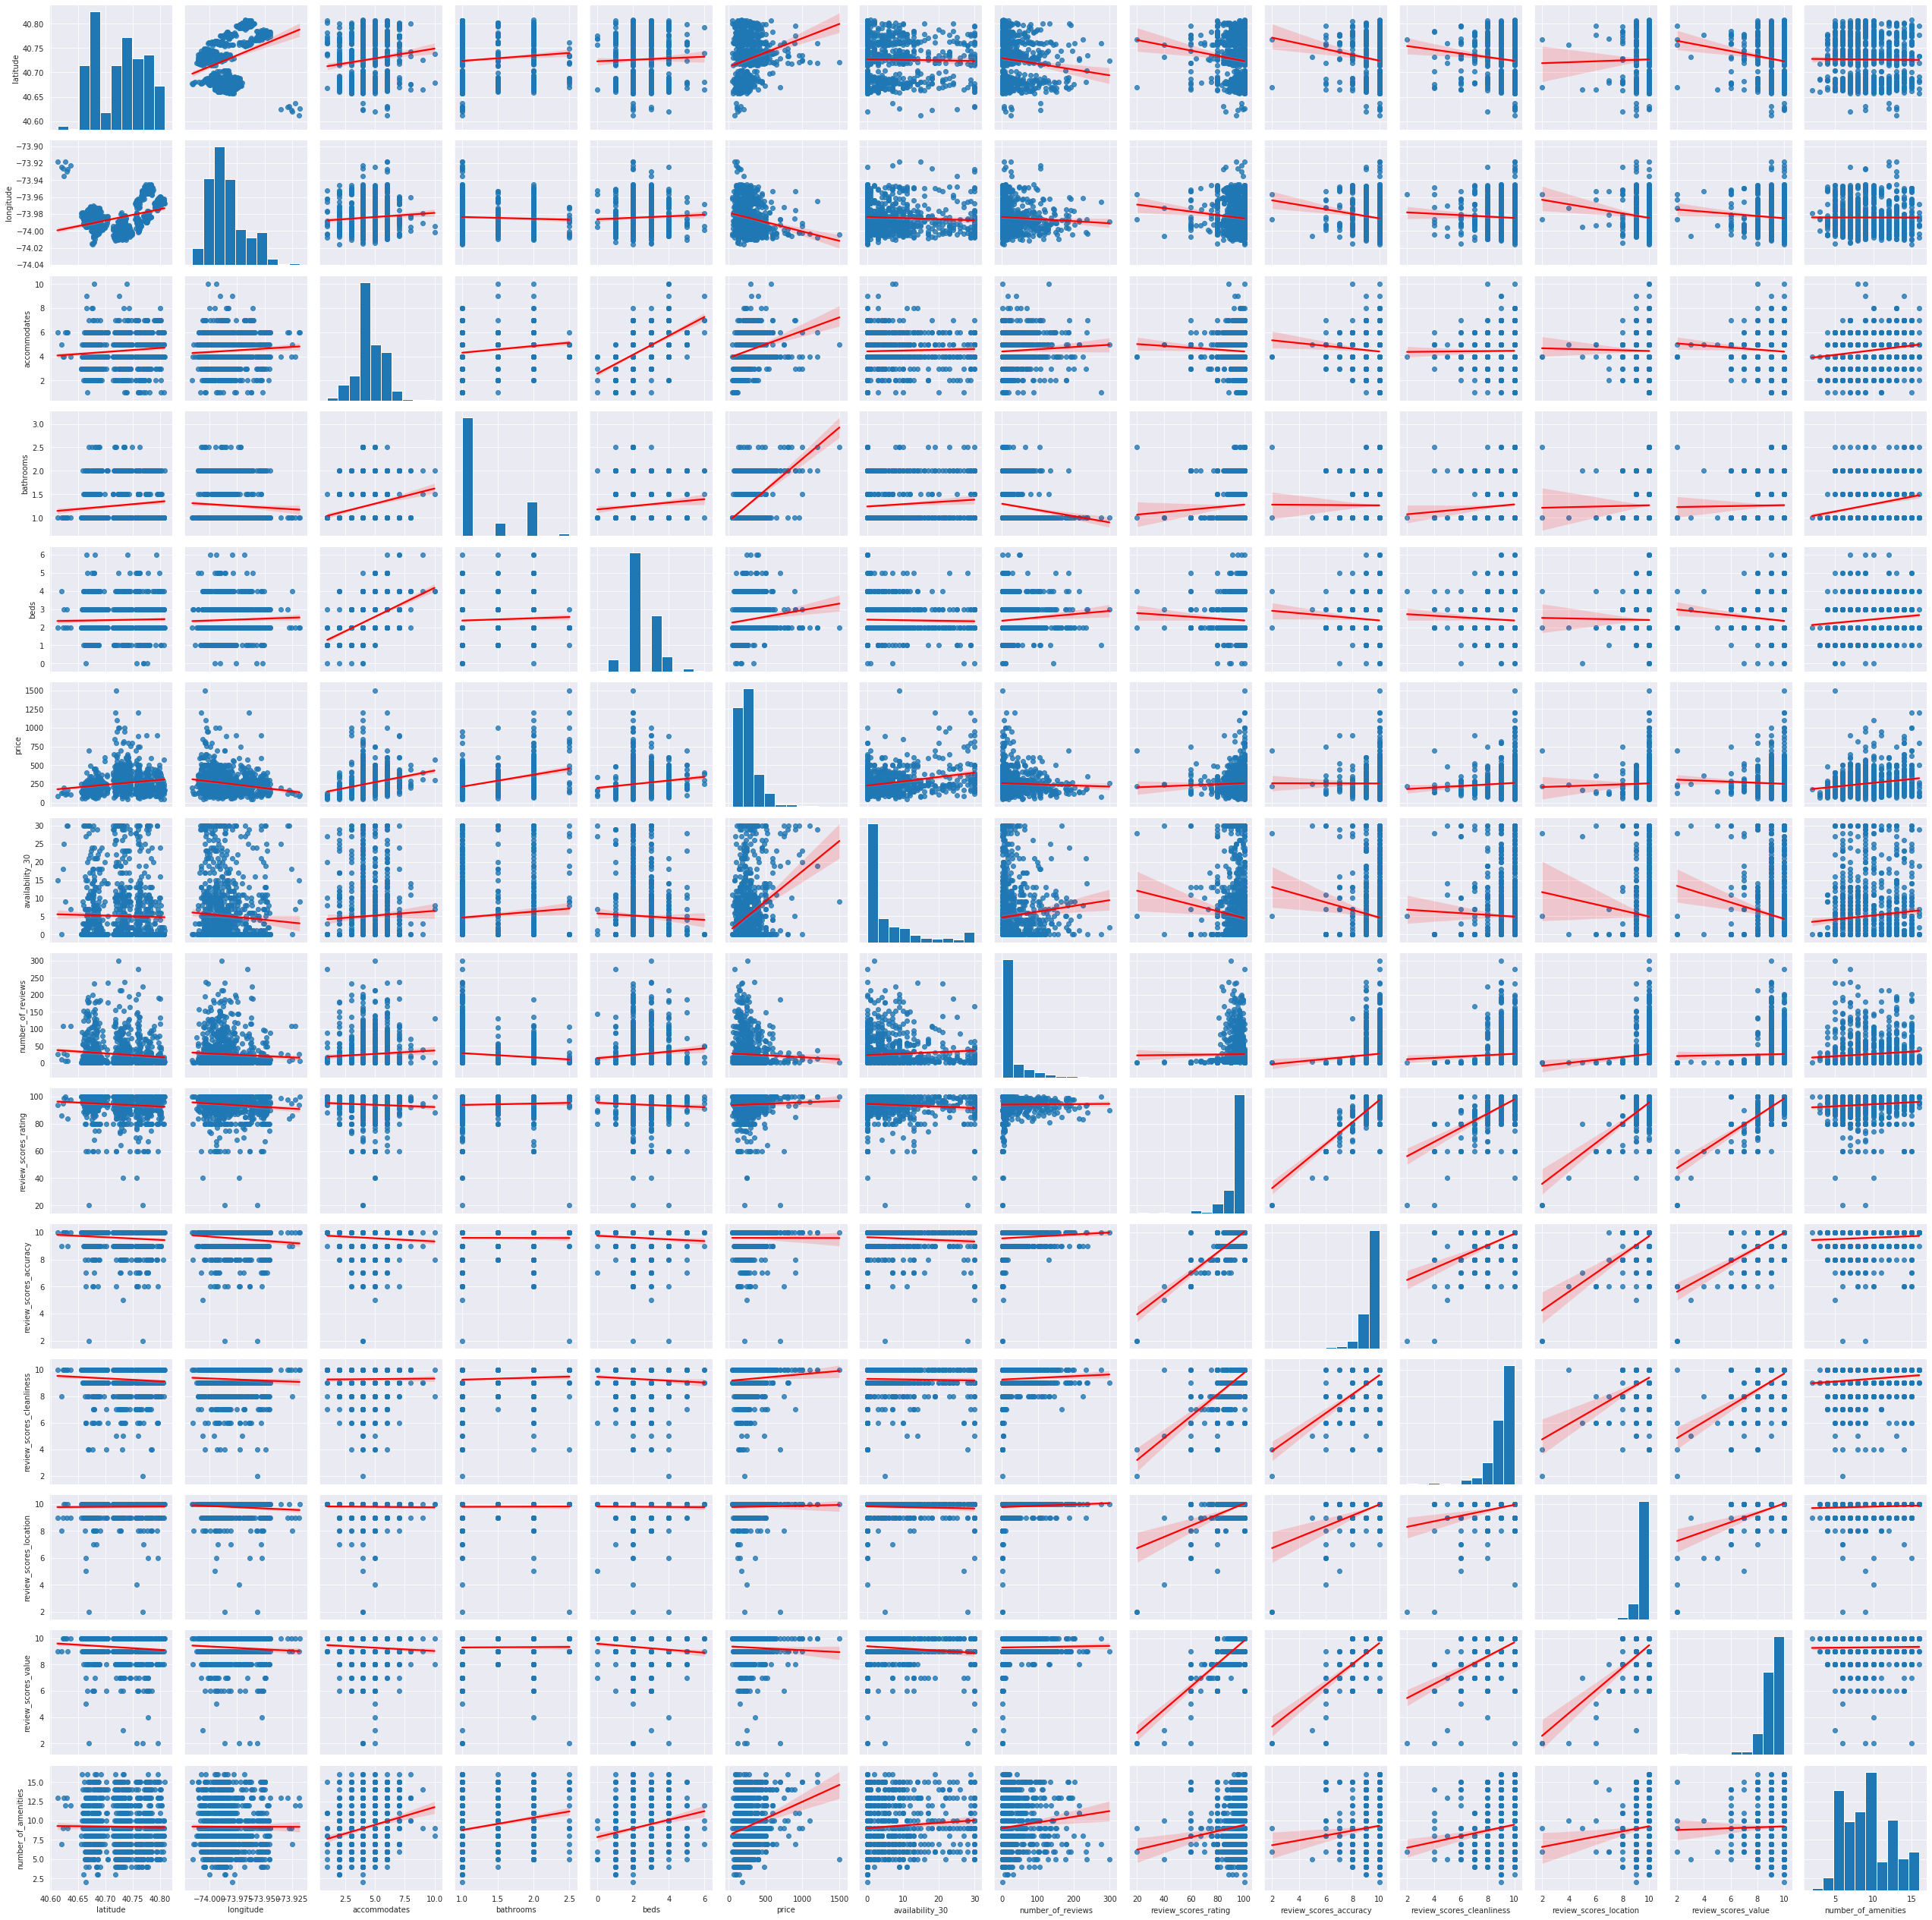

In [300]:
# Removing outliers for the purpose to visualize linear correlation
sns.pairplot(
    revenue_df_proc.select_dtypes('number').query( # Removing the possible range of outliers
        'price < 2000 and longitude < -73.8 and longitude > -74.05 and accommodates < 12 and bathrooms < 3 and bathrooms > 0 and price < 1900 and number_of_reviews < 300 and number_of_amenities > 0'
    ).drop('id', axis=1), 
    kind='reg', 
    plot_kws={'line_kws':{'color':'red'}}
)

There still seems to a be few outliers here and there. It looks like there is some linear correlation between the numeric attributes in general. However, strong nonlinear correlations between attributes is a possibility. Some minor observations that can be inferred are as follows:

1. As the latitude increases, the price of the property seems to increase slightly.
2. As the longitude increases, the price of the property seems to decrease slightly.
3. Greater the number of reviews, lower tends to be the price of the property.
4. As more amenities are offered to tenants, the price of the property seems to increase naturally. 
5. If a property's availability for rent increases within the 30 days period, its price might increase slightly. 
6. More accommodations usually imply a slight increase in the number of beds in the apartment along with a slight increase in the price of the property.

It is reminder all observations so far in this EDA section, univariate or bivariate, pertain to 2-bedroom apartments. 

##### Boxplots 

**Boxplots** are drawn to gain better insights of the categorical variables: 

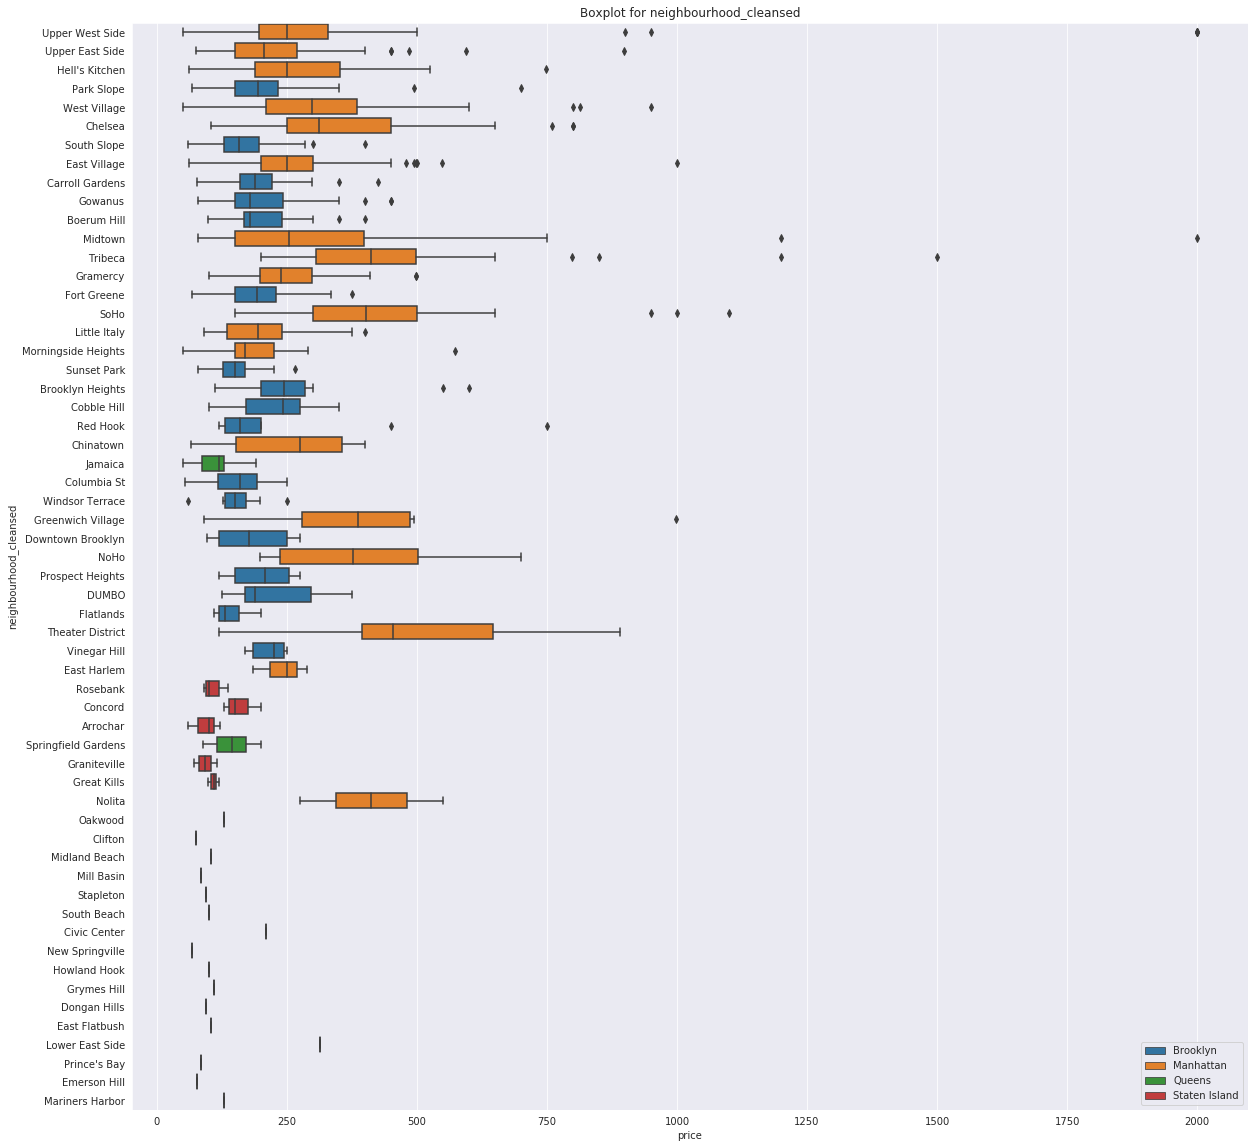

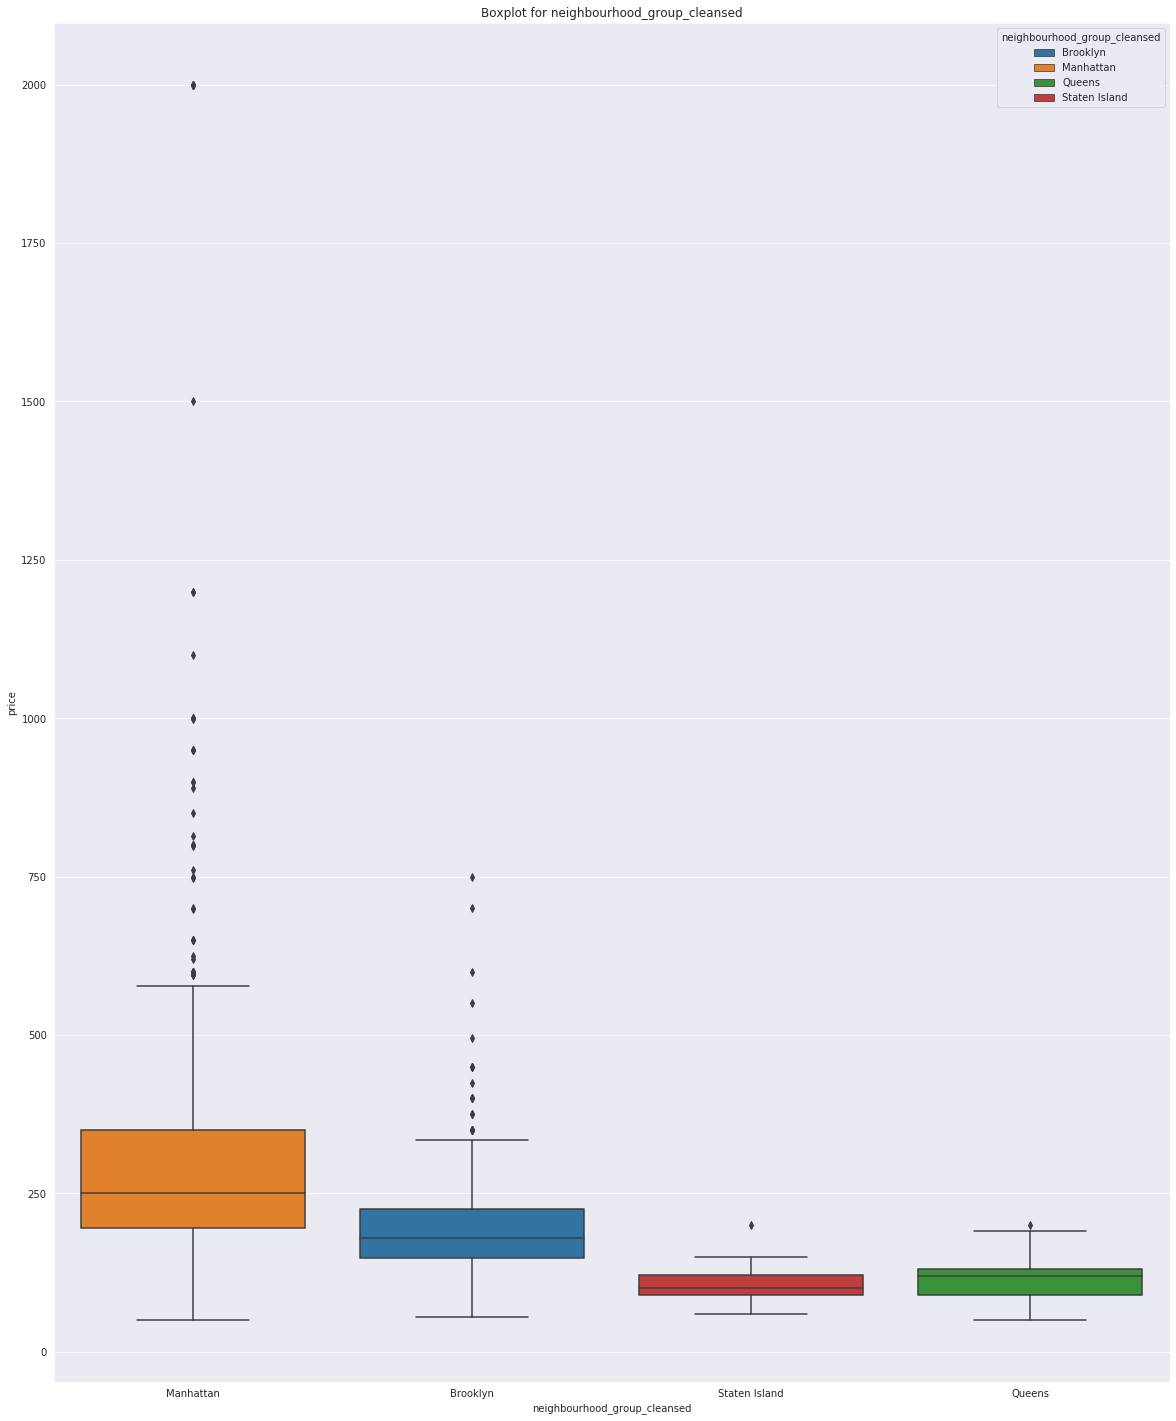

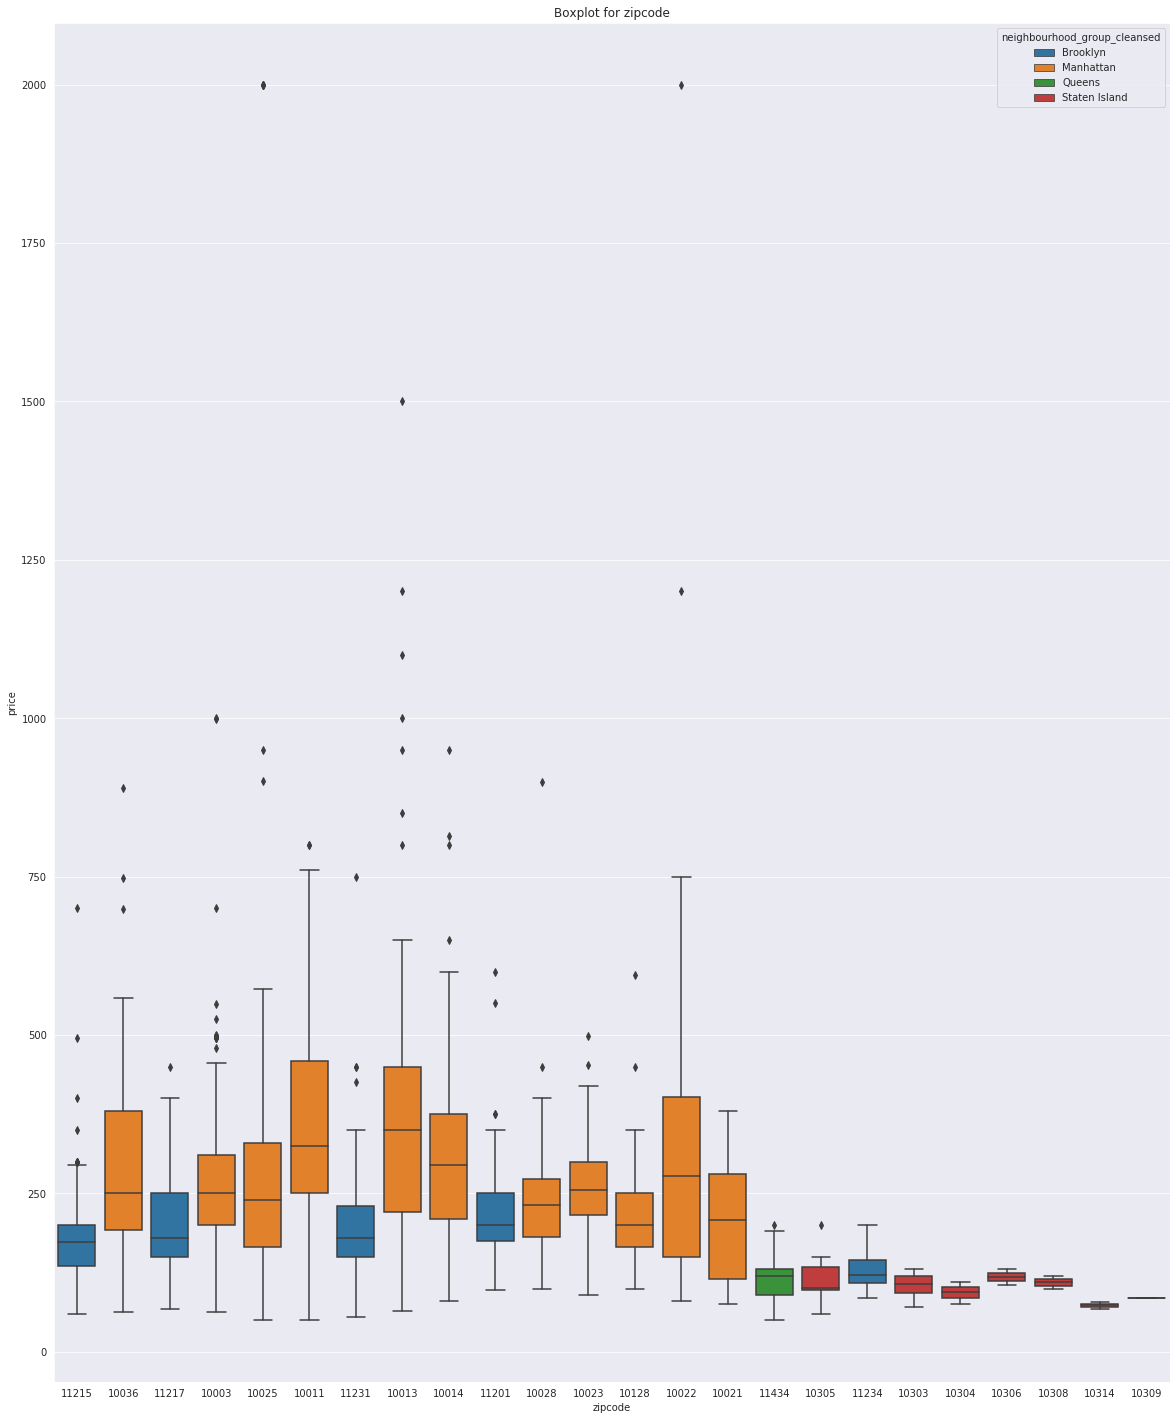

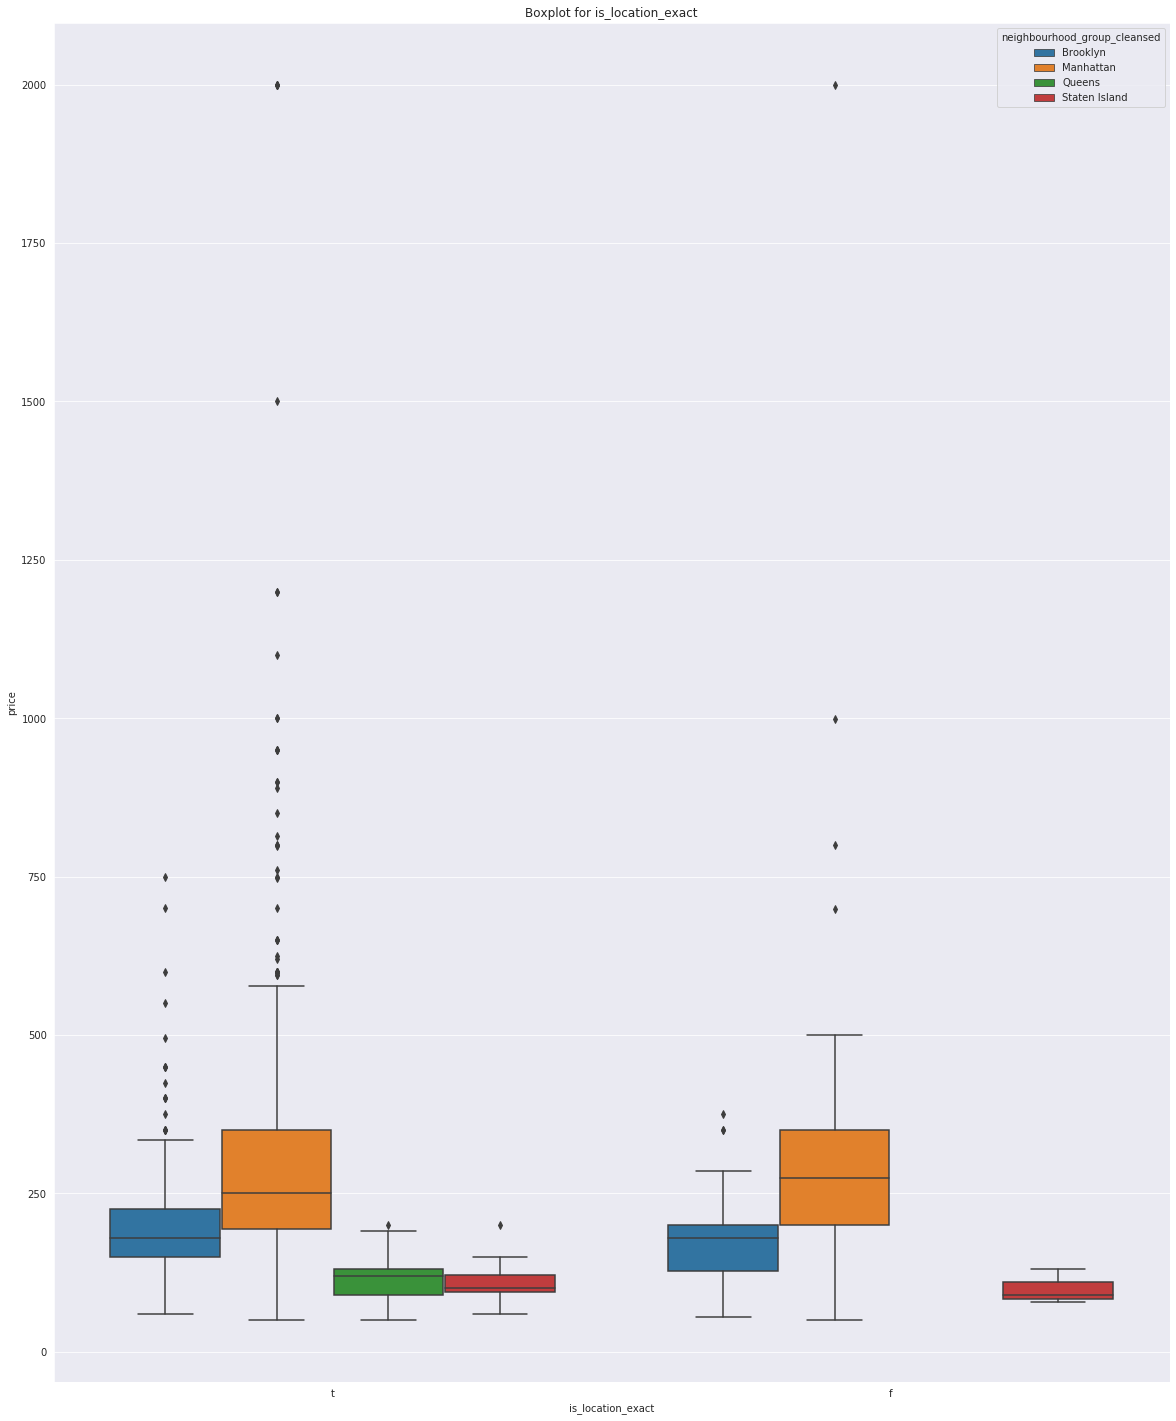

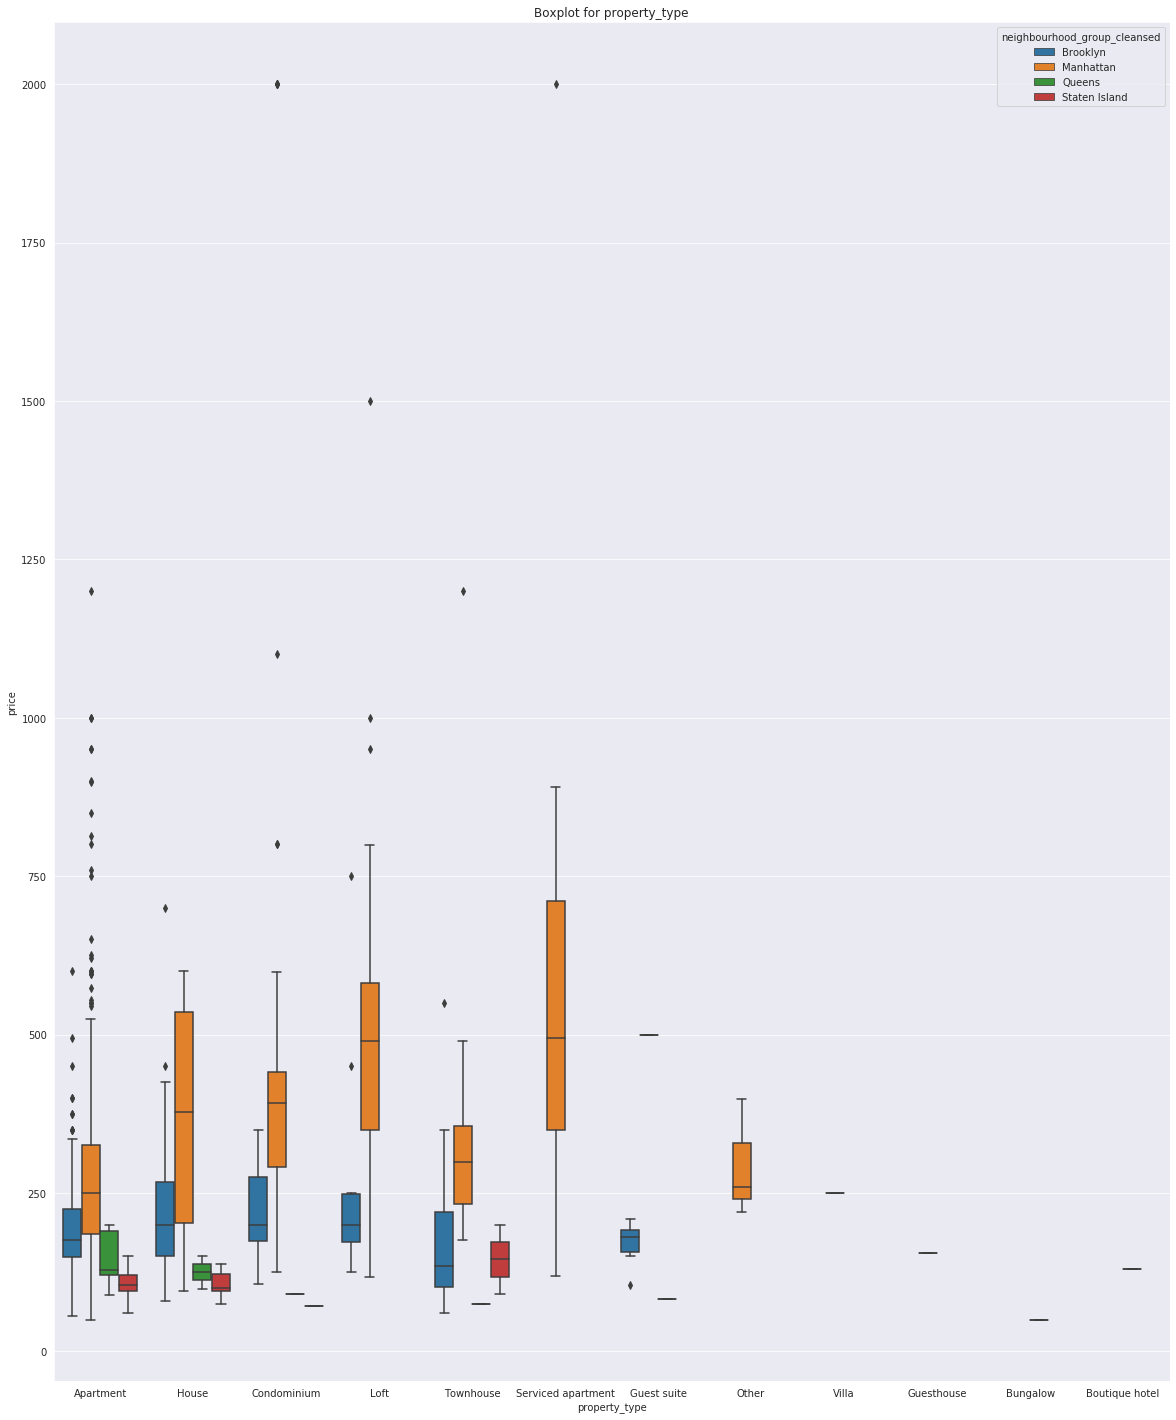

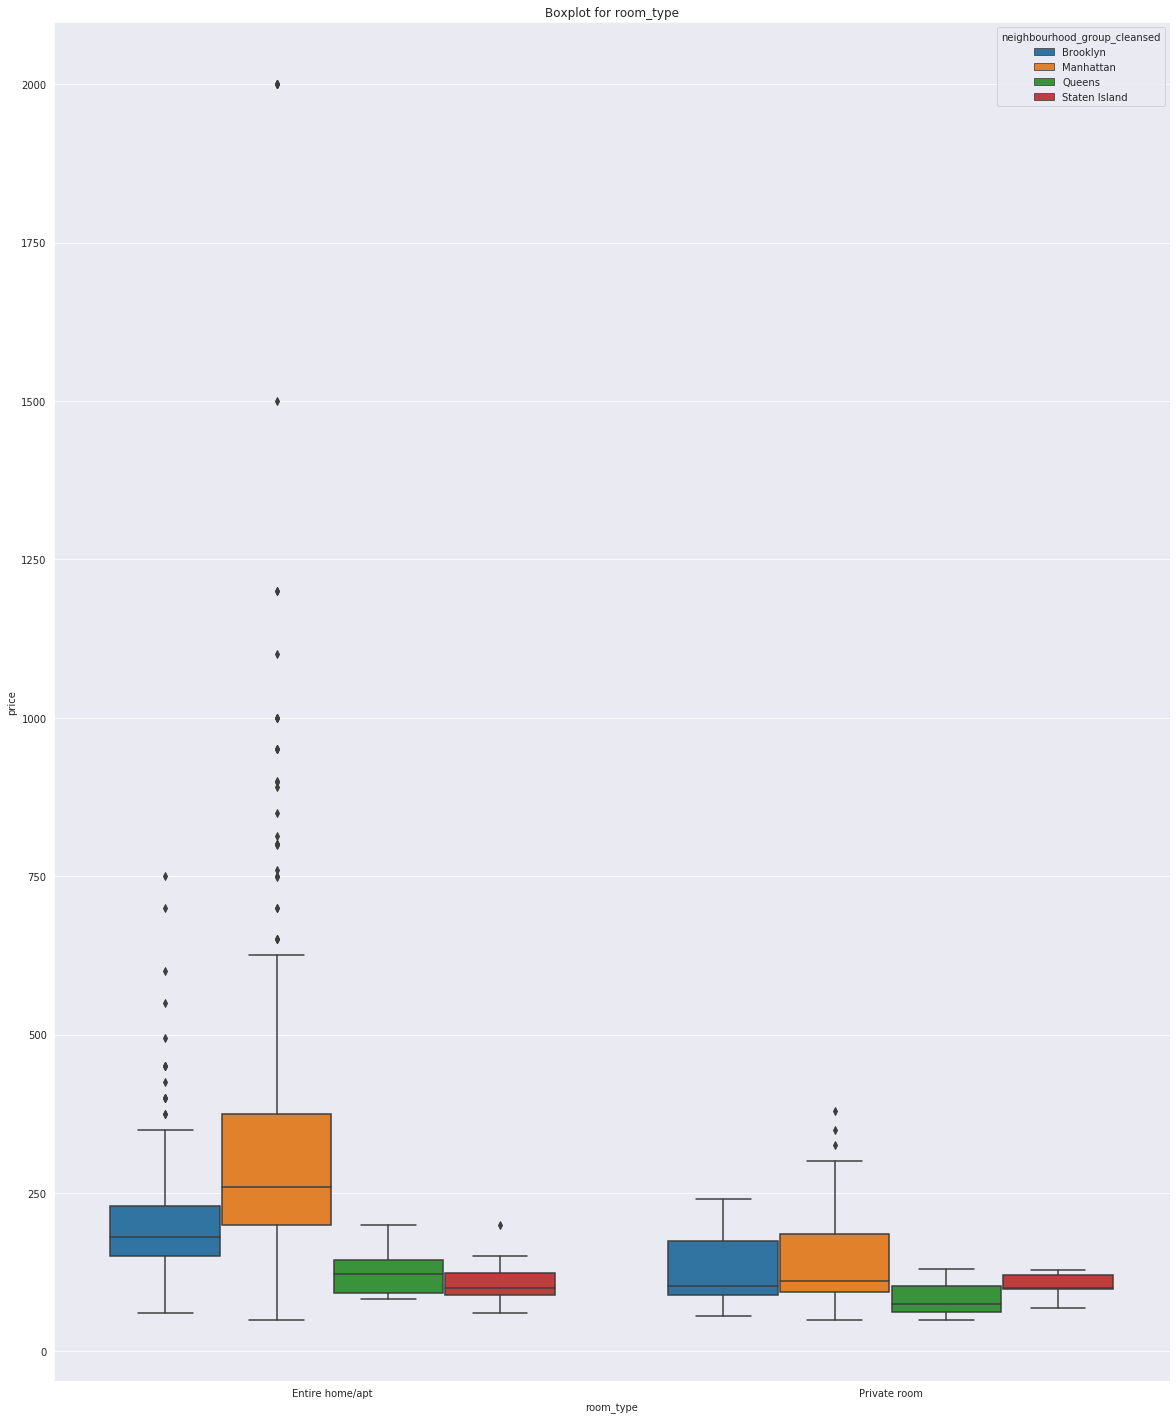

In [301]:
# Drawing boxplots
for column in revenue_df_proc.select_dtypes('category'):
    if column in ['property_type', 'room_type', 'is_location_exact']: dodge = True
    else: dodge = False
    if column in ['neighbourhood_cleansed']:
        fsize, x, y = 20, 'price', column
    else:
        fsize, x, y = 25, column, 'price'            
    plt.figure(figsize=(20, fsize))
    sns.boxplot(
        x=x, 
        y=y, 
        data=revenue_df_proc, 
        order=revenue_df_proc[column].value_counts().index,
        hue=revenue_df_proc.neighbourhood_group_cleansed,
         dodge=dodge
    )
    if column in ['neighbourhood_cleansed']: plt.legend(loc='lower right')
    plt.title('Boxplot for ' + column)

Each boxplot element (for the categorical level) in the boxplot are ordered (descending) based on the number of the unique properties for that categorical level. The boxplots are created with respect to the most important numeric attribute, *price*. This boxplot also confirms our hypothesis for the presence of a large number of outliers in our dataset. Several interesting observations can be summarized as follows:

1. While several Manhattan properties, like the Upper West Side, East Village, etc. tend to have higher median prices than other locations, a property in Prospect Heights neigbourhood in the Brooklyn borough seems likely to have the highest price among all NYC properties.
2. Manhattan properties tend to have higher variability in prices than other boroughs and also tends to have more outliers than other boroughs. This is expected since Manhattan also outnumbers other boroughs in terms of the number of properties it possesses. 
3. Staten Island seems to have the lowest variability in prices, at the same time, tends to have the least pricey properties.
4. Most zipcodes have high median priced properties; naturally these zipcodes mostly belong to the Manhattan borough.
5. While Queens rental properties that require tenants to rent entire homes/apartments tend have higher prices than Staten Island, it is generally more expensive to rent a private roon in Staten Island than in Queens.
6. Manhattan properties followed by Brooklyn properties tend consistently dominate with regards to high prices for almost every type of property - Apartment, Loft, House, Townhouse, etc.
7. Though Staten Island has more properties than Queens, the prices of properties in Staten Island tend to be lesser than Queens. 

It is a reminder that these observations, which are drawn and compared with respect to the NYC boroughs, are conditioned on the limited number of the zipcodes information we received earlier through data cleaning (i.e., the zipcodes are common to the cost and revenue datasets respectively). This means that our inference can change as and when more zipcodes and its corresponding historic information are added to the cost dataset.

If each Boxplot element (for the categorical level) in the boxplot are ordered (descending) based on the median price for that categorical level, we are a few more interesting insights. Again, the boxplots are created with respect to the most important numeric attribute, *price*. (so the boxplots above and below are almost identical)  

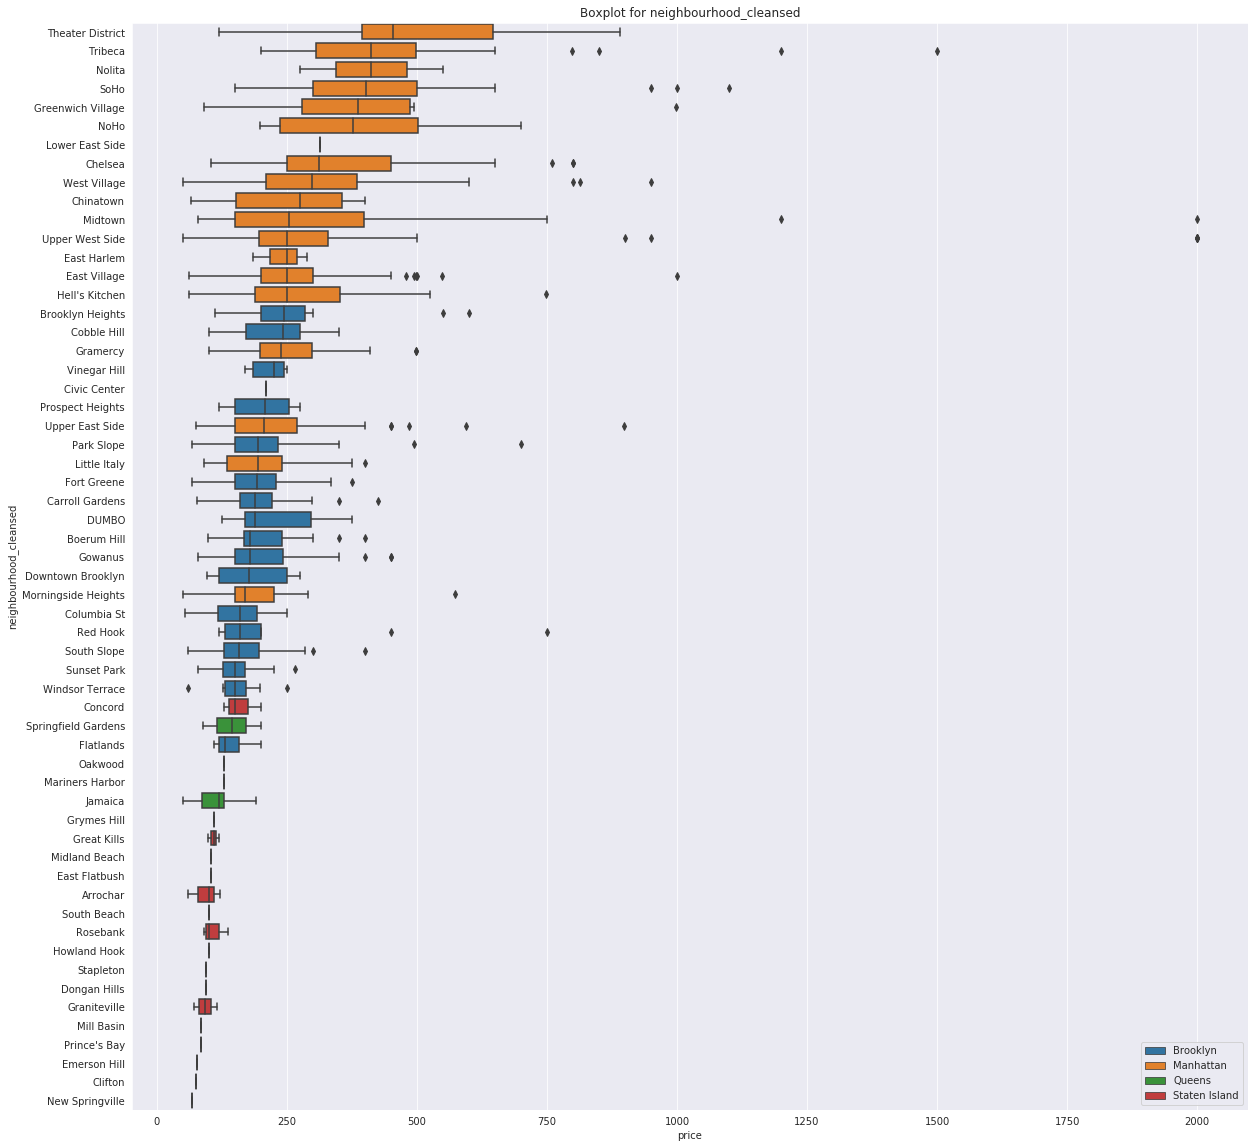

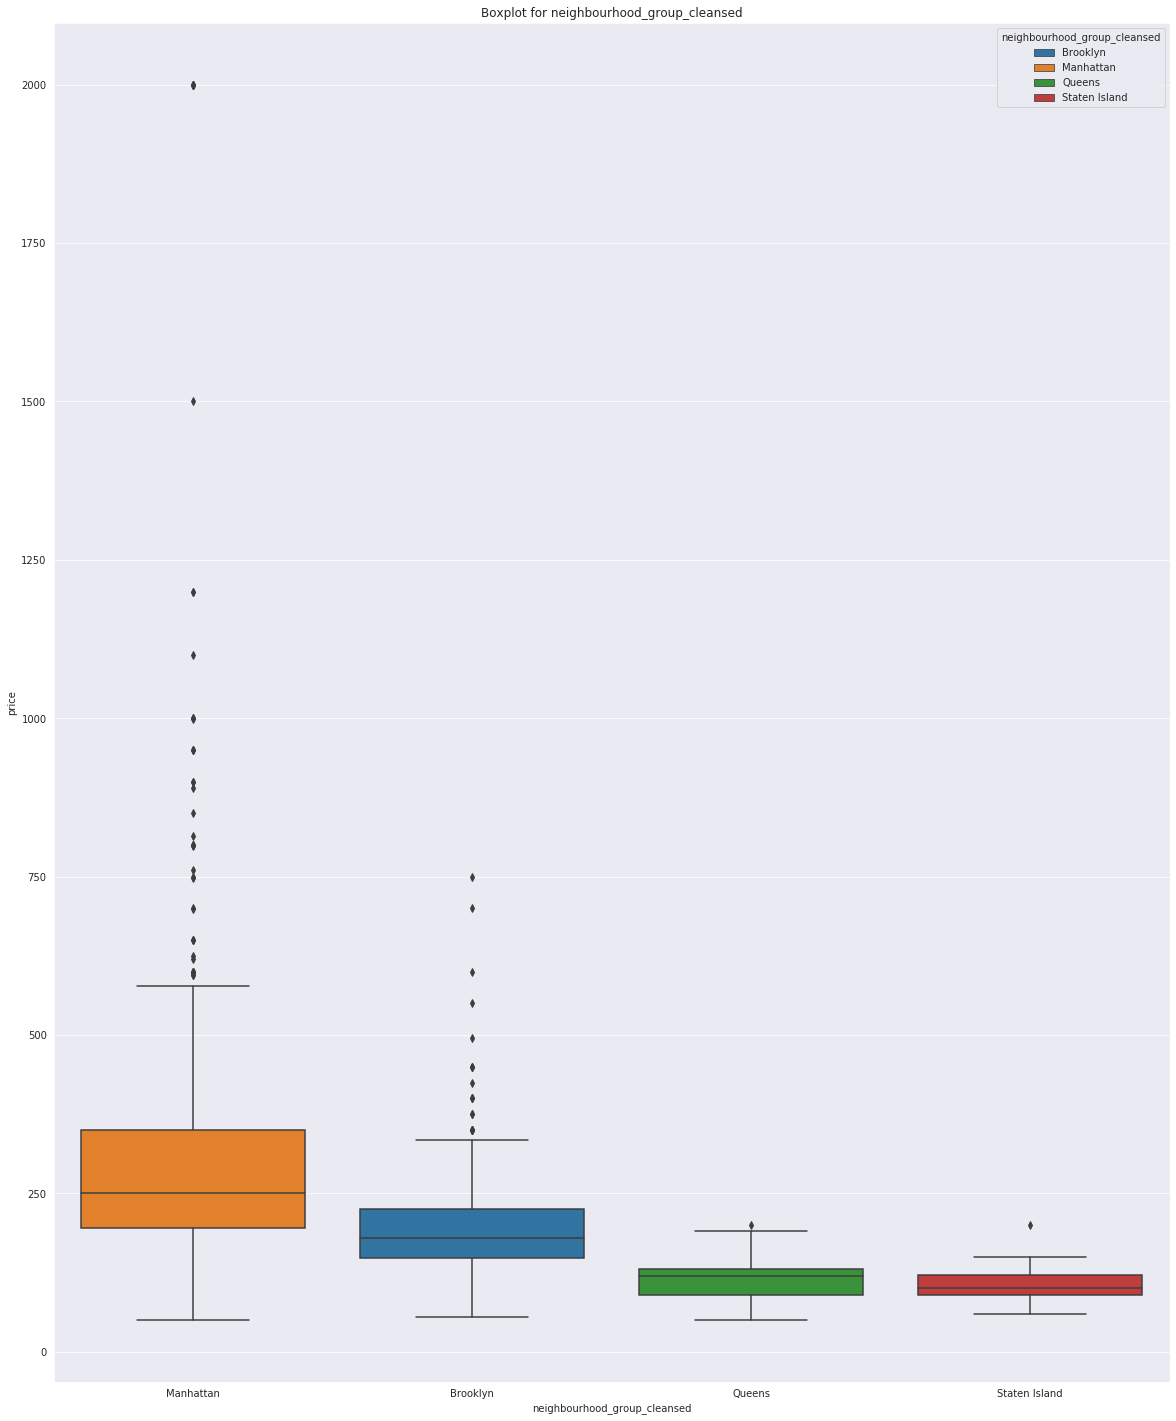

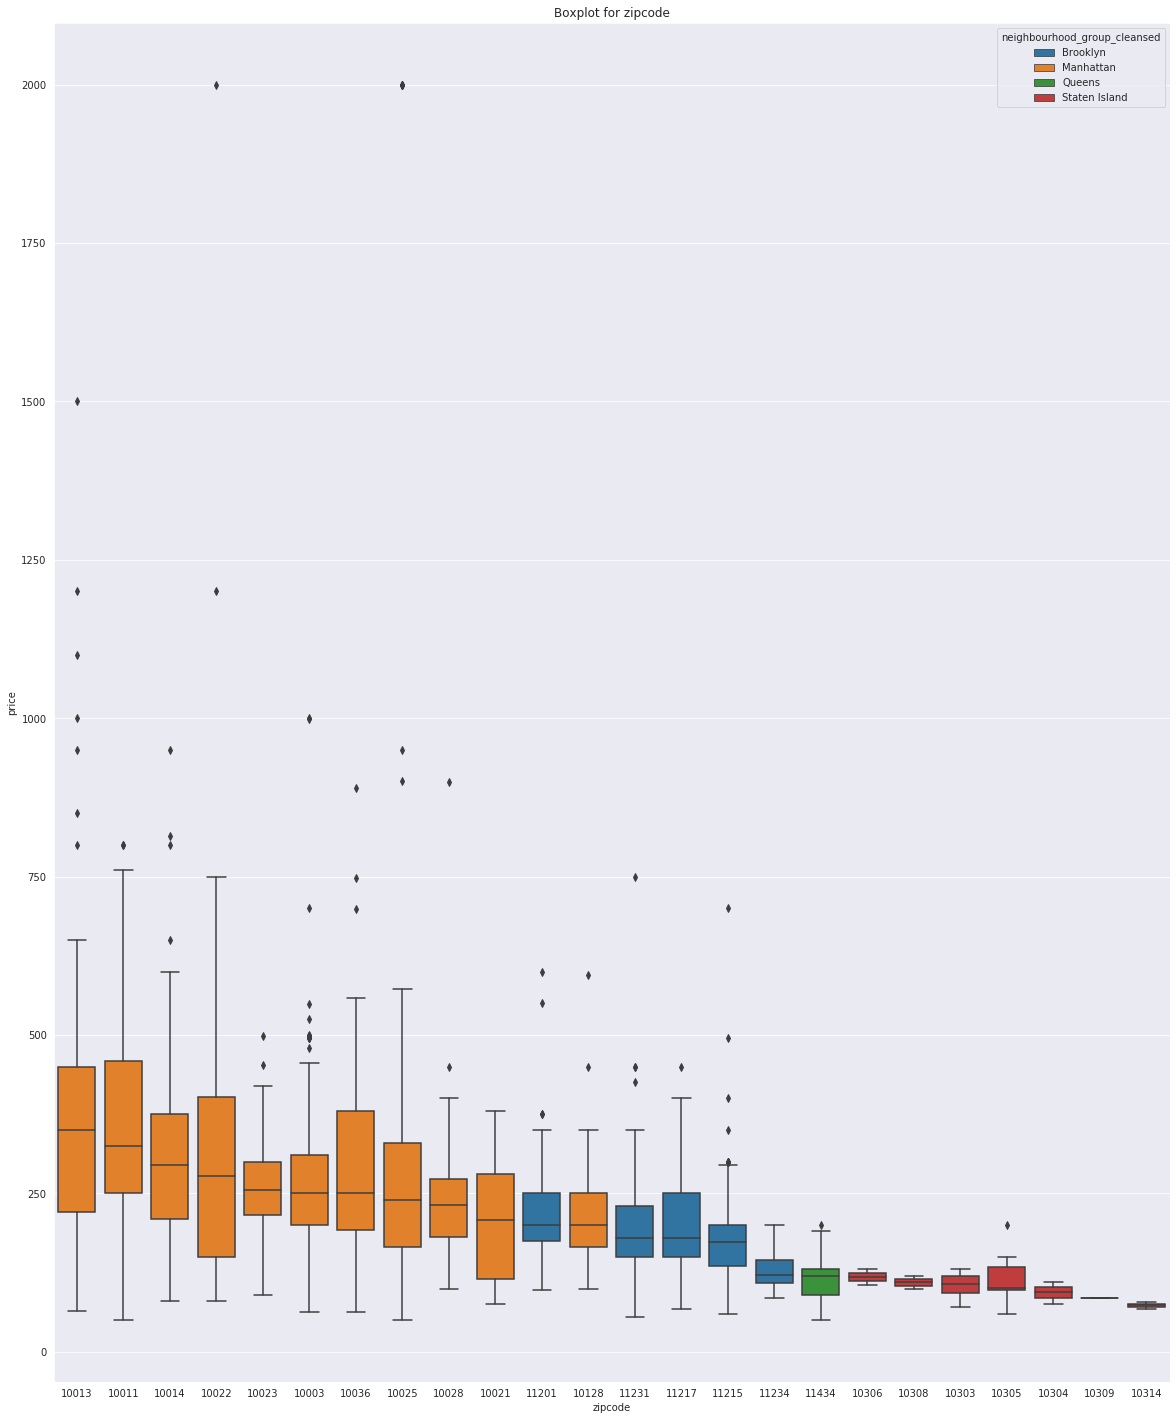

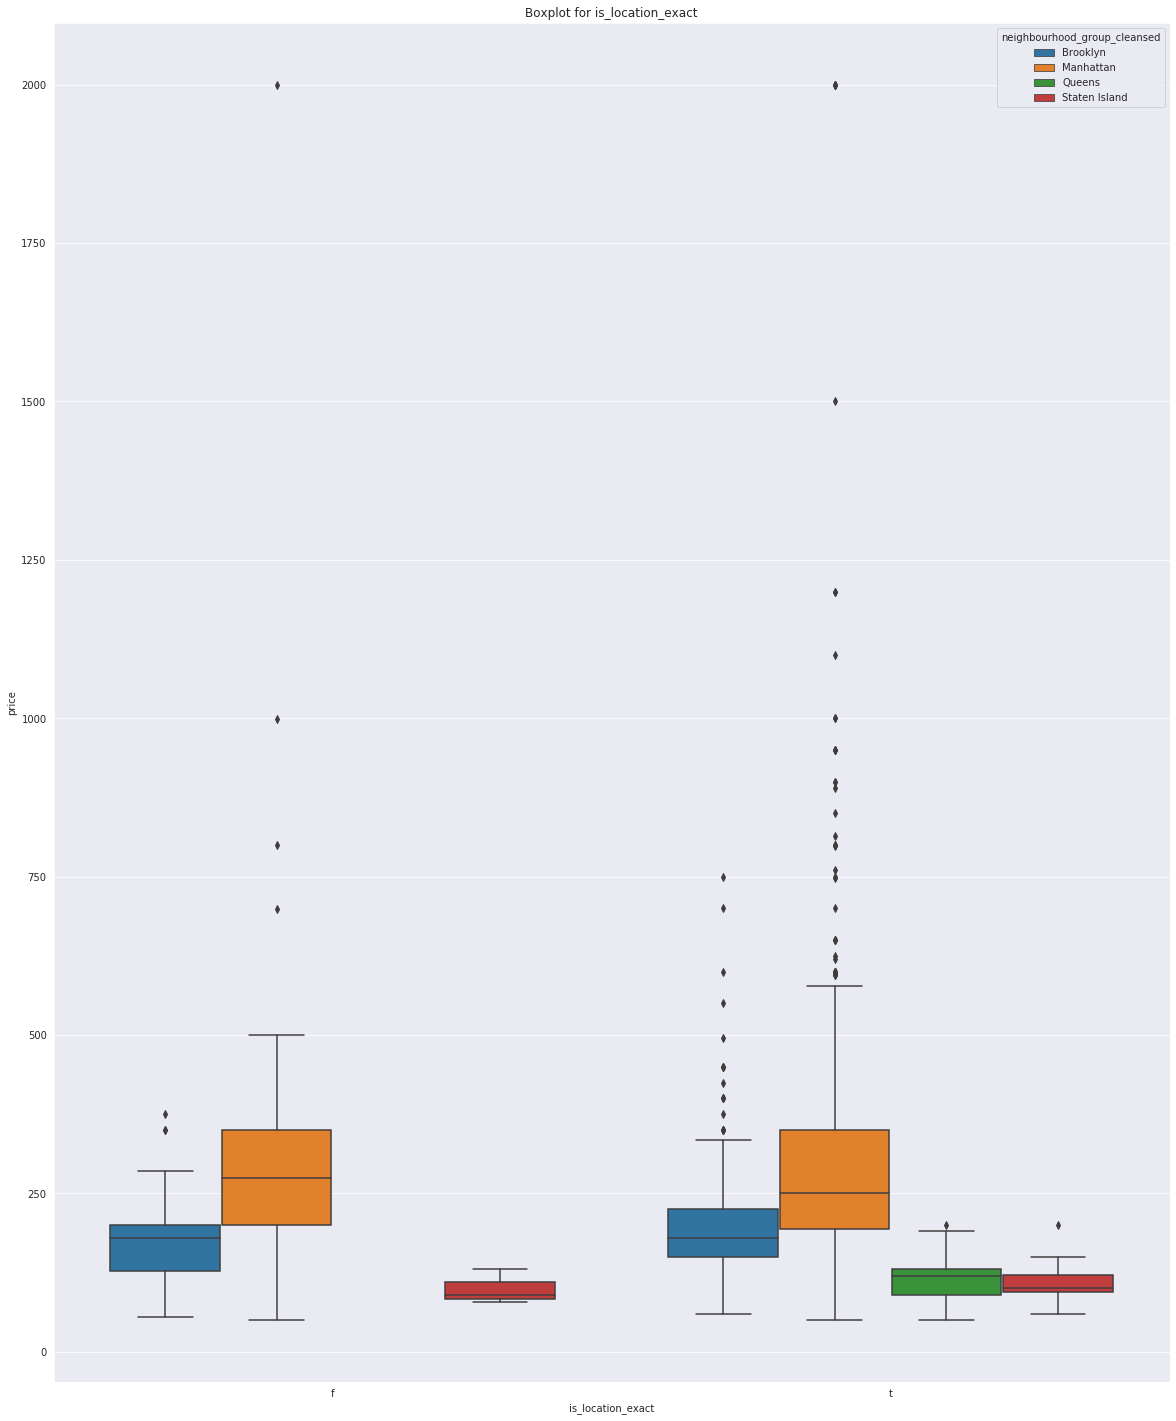

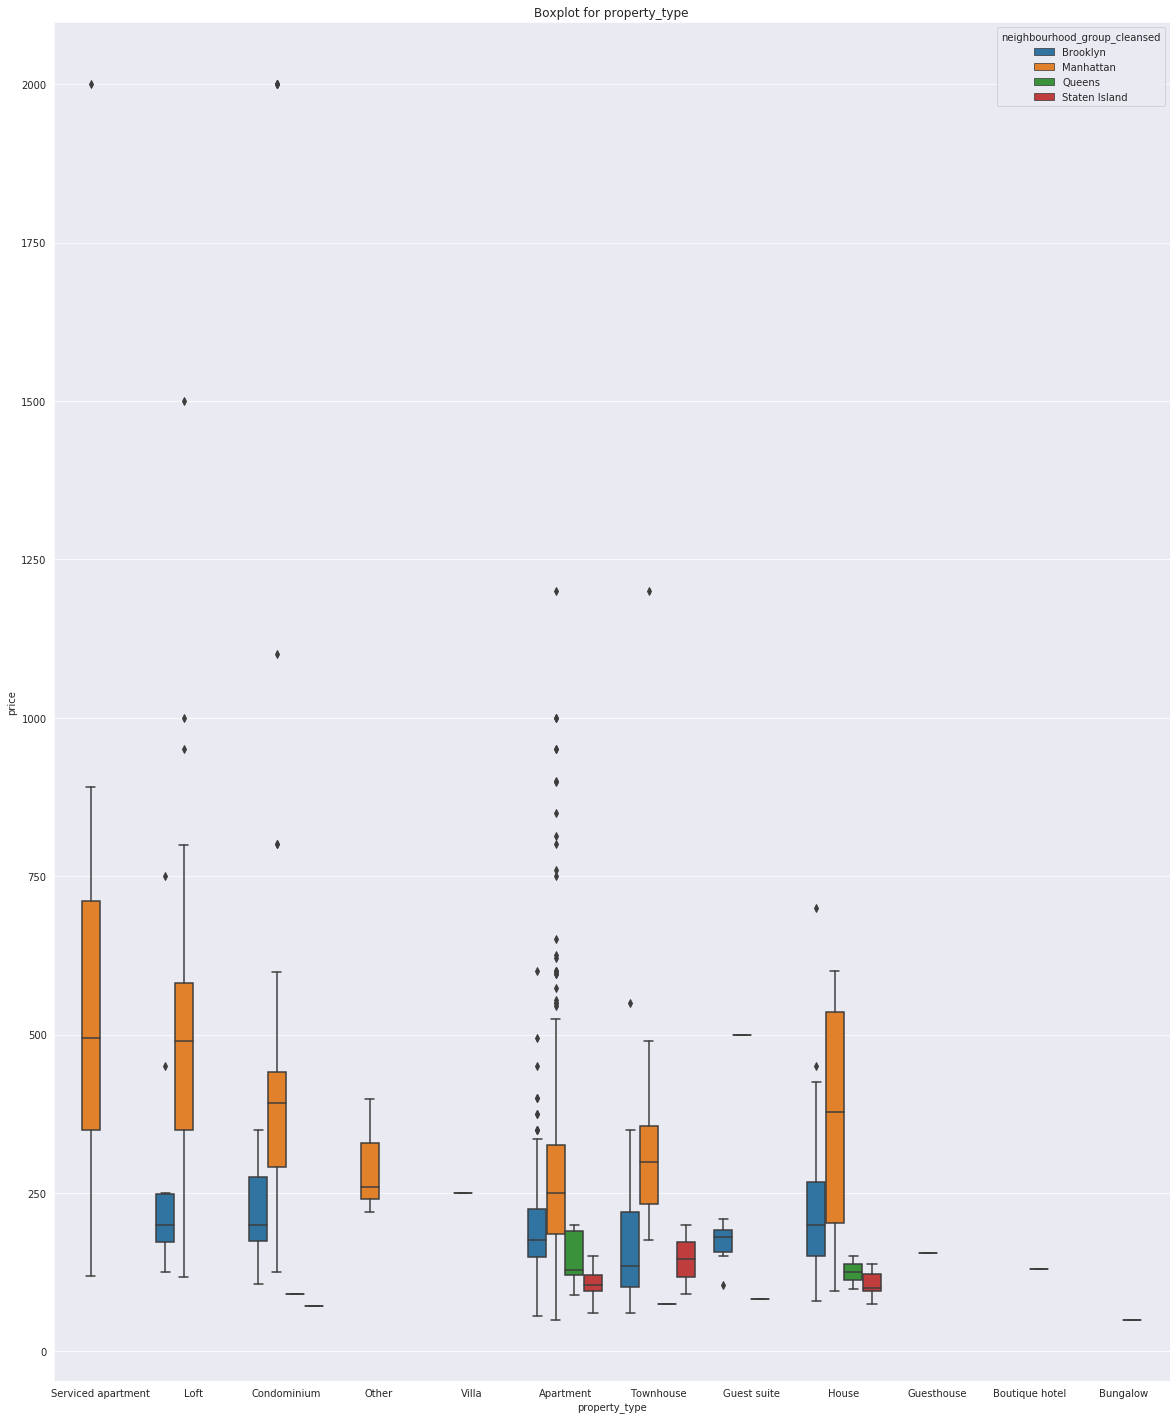

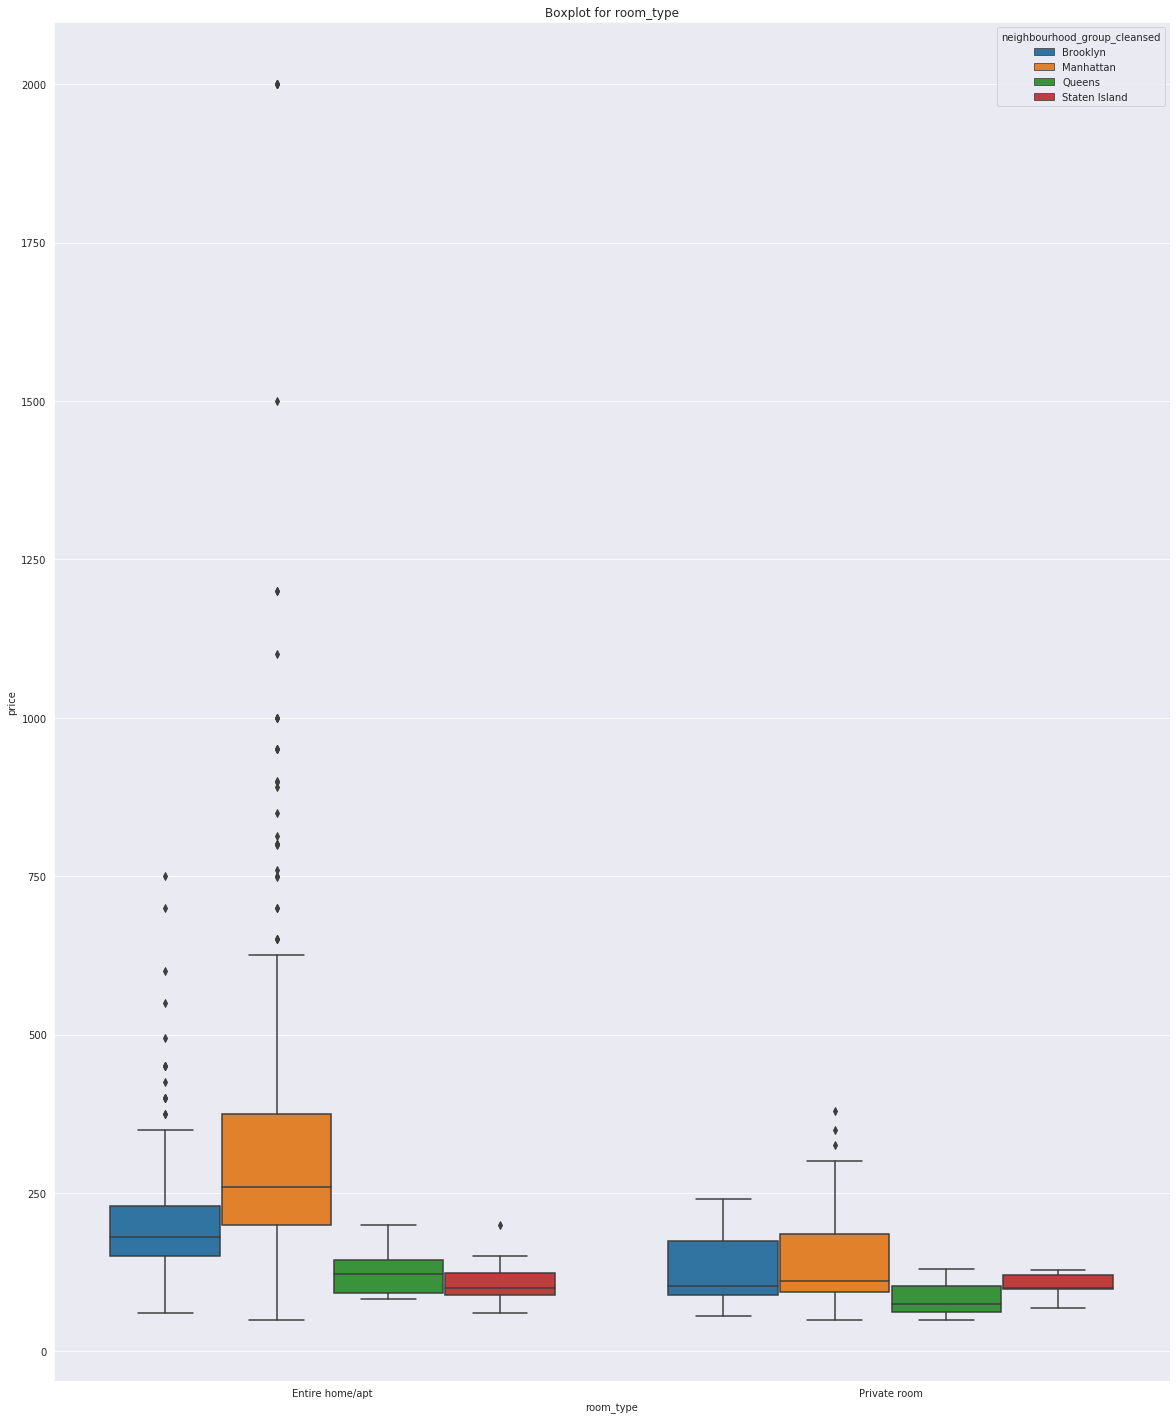

In [302]:
for column in revenue_df_proc.select_dtypes('category'):
    if column in ['property_type', 'room_type', 'is_location_exact']: dodge = True
    else: dodge = False
    if column in ['neighbourhood_cleansed']:
        fsize, x, y = 20, 'price', column
    else:
        fsize, x, y = 25, column, 'price'            
    plt.figure(figsize=(20, fsize))
    sns.boxplot(
        x=x, 
        y=y, 
        data=revenue_df_proc, 
        order=revenue_df_proc.groupby(column).median().sort_values('price', ascending=False).index,
        hue=revenue_df_proc.neighbourhood_group_cleansed,
         dodge=dodge
    )
    if column in ['neighbourhood_cleansed']: plt.legend(loc='lower right')
    plt.title('Boxplot for ' + column)

Some insights that can be drawn are as follows:

1. The median rent price of a property in Manhattan is the highest, followed by Brooklyn, Queens and finally Staten Island.
2. It appears as though that properties in zipcodes belonging to the same borough have nearly the same median price.  
3. Top 3 Neighbourhoods having properties with high median prices in Manhattan:
    - NoHo
    - SoHo
    - Tribeca
4. Top 3 Neighbourhoods having properties with high median prices in Brooklyn:
    - Cobble Hill
    - Brooklyn Heights
    - Vinegar Hill
5. Top 3 Neighbourhoods having properties with high median prices in Queens:
    - Cambria Heights
    - Springfield Gardens
    - Jamaica
6. Top 3 Neighbourhoods having properties with high median prices in Staten Island:
    - Shores Acres
    - Concord
    - Mariners Harbor
    
Of course, as we define our metrics for choosing the most profitable zipcodes for investment, it might be good to take note  of the top 3 neighbourhoods in each borough, where the rent prices are typically high. Of course, through several other factors in play, such as breakeven years, the above listed neighbourhoods need not necessarily the best fit if the costs of purchasing the property in these neighbouroods (and consequently the time to come reach the no-profit no-loss scenario) outweighs the the high rental revenue that would be received.  

### Cost Dataset  

Our cost dataset can be summarized as follows:

In [303]:
print('Size of the dataset = {} rows, {} columns'.format(cost_df_proc.shape[0], cost_df_proc.shape[1]))

Size of the dataset = 24 rows, 3 columns


In [304]:
cost_df_proc.info(verbose=True, null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 21 to 527
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zipcode       24 non-null     int64  
 1   size_rank     24 non-null     int64  
 2   median_price  24 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 768.0 bytes


The memory usage for the cost dataset is barely 1 KB, which is good for scalability.

The dtypes care fairly consistent for the respective columns.

The descriptive statistics for the median price for the cost dataset can be seen as: 

In [305]:
cost_df_proc.median_price.describe()

count    2.400000e+01
mean     1.273946e+06
std      8.426342e+05
min      3.124167e+05
25%      3.870125e+05
50%      1.303217e+06
75%      1.890738e+06
max      3.224517e+06
Name: median_price, dtype: float64

The real-estate investor might need to be aware that purchasing a property will be an expensive task, costing around and about $1M  

#### Univariate Analysis 

##### Unique Elements

A quick check, on the number of unique elements the cost dataset attributes have, is performed:

In [306]:
for x in cost_df_proc.columns.values:
    print("Number of Unique Elements in {} column: {}".format(x, len(cost_df_proc[x].unique())))

Number of Unique Elements in zipcode column: 24
Number of Unique Elements in size_rank column: 24
Number of Unique Elements in median_price column: 24


It looks like all 25 rows in the cost dataset have unique column values respectively.

##### Q-Q Plot

Text(0.5, 1.0, 'Q-Q Plot for Median Price')

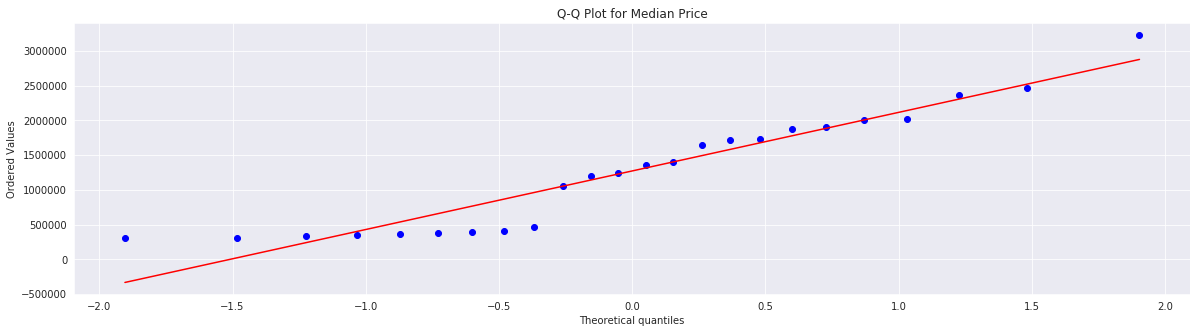

In [307]:
plt.figure(figsize=(20, 5))
probplot(cost_df_proc['median_price'], dist='norm', plot=plt)
plt.title('Q-Q Plot for Median Price')

The above Q-Q plot is for the median price attribute. The attribute does not seem to follow a strong normality assumption. 

#### Bivariate Analysis 

##### Bar Plot 

Text(0.5, 1.0, 'Median Prices of Zipcodes Ordered by Their Size Rank (Ascending)')

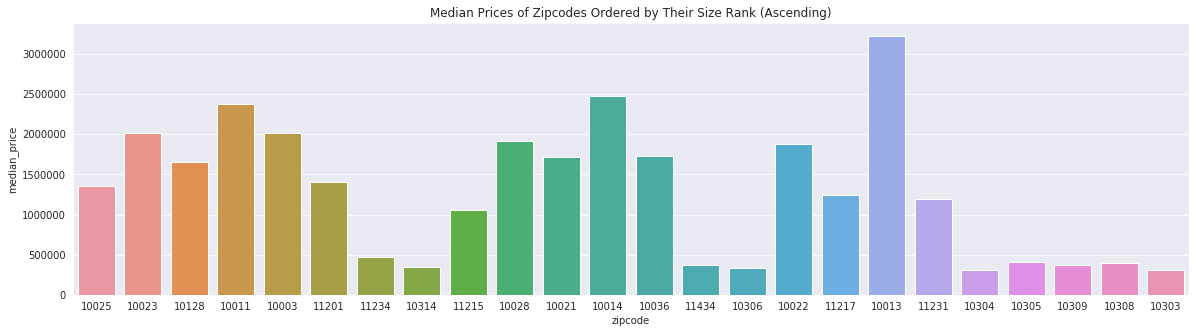

In [308]:
plt.figure(figsize=(20, 5))
sns.barplot(x='zipcode', y='median_price', order=cost_df_proc.sort_values('size_rank').zipcode, data=cost_df_proc)
plt.title('Median Prices of Zipcodes Ordered by Their Size Rank (Ascending)')

If we plot the order zipcodes by their size rank, and check their median property prices, then we get a bar plot as shown above. There isn't any obvious trend here, but in general it seems to be the case that greater the population in a zipcode, higher the median price of a property (some zipcodes are outliers to this trend).

Text(0.5, 1.0, 'Size Rank of Zipcodes Ordered by Their Median Price (Descending)')

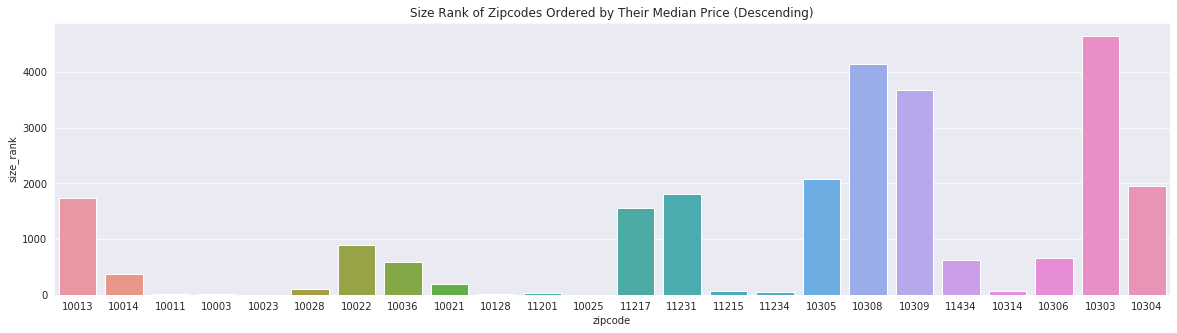

In [309]:
plt.figure(figsize=(20, 5))
sns.barplot(x='zipcode', y='size_rank', order=cost_df_proc.sort_values('median_price', ascending=False).zipcode, data=cost_df_proc)
plt.title('Size Rank of Zipcodes Ordered by Their Median Price (Descending)')

If we order the zipcodes with respect to the descending property median prices and check their size rank, we gte the bar plot above. From this plot, this seems more clear that zipcodes with higher population tend to have higher median property prices. Outliers do exist as always (in the fact, the zipcode *10013*, which has the highest property median prices, has relatively lesser population than expected living in that area).

# Evaluation Metrics

The metrics were formulated after performing EDA and getting some insights of the data we are working with. 

**QUANTITATIVE METRICS**
1. <ins> *Breakeven Years* </ins>: 
    - Amount of time it will take for the real-estate investor to reach a 'no-profit, no-loss' situation via receiving rent from tenants (through a constant assumed occupancy rate) after a property has been purchased by the investor.
    - *Occupancy rate* is estimated by:
        - The number of days a property is rented by tenants within the 30 days period, and 
            - The maximum number of people who accommodate a property, in the case of private room leasing), or
            - A group of people (1+ persons, number of accommodations do not matter), in case of entire apartment/home leasing) 
    - *Rent prices* are estimated with the help of the occupancy rate    
    - In general, $\downarrow$ the number of breakeven years $\Longrightarrow$ $\uparrow$ profitable a property would be deemed

**QUALITATIVE METRICS**
2. <ins>*Presence of Essential Amenities*</ins>:
    - Number of essential amenities available to tenants renting the property.
    - The presence of an amenity is important to a prospective tenant - frequency of the amenity being offered is not accounted for.   
    - The set of amenities that are titled as 'Essential' are listed below as per their category:
        - Property Specifics
            1. Bed
            2. Bathroom
            3. Heating
            4. Air conditioning
            5. Parking            
        - Property Safety and Assistance
            1. Fire extinguisher
            2. Smoke detector
            3. Wheelchair
        - Electronics
            1. TV
            2. WiFi
        - Food-Related Utilities
            1. Kitchen
            2. Kitchenette
            3. Dishes
            4. Dishwasher
            5. Microwave
            6. Oven
            7. Stove
            8. Breakfast
        - Laundry
            1. Washer
            2. Dryer
        - Leisure
            1. Gym
    - As per the AirBnB listing, all amenities are expected to be a part of the property. Only relaxation applies to the Gym amenity, which may either be included in the rent package, or it is just in the vicinity of the property (traffic on NYC roads can be bad, so nearby gyms are a big plus).     
    - In general, $\uparrow$ the number of essential amenities $\Longrightarrow$ $\uparrow$ likely is a tenant to rent the property as he/she will have access to more utilities for possibly the same rent being paid $\Longrightarrow$  $\uparrow$ valuable and profitable a property should be    
3. <ins> *Property Accuracy Score* </ins>:
    - Score that weighs the total number of property listings in a Zipcode by their accuracy score provided by tenants  
    - Computed by multiplying the Accuracy review score given by tenants (to the property description + its pictures as mentioned in the listing) and the Number of property listings  in the zipcode
    - There may be properties that are not described accurately by a host on AirBnB, but might otherwise be excellent in terms of location
    - In general, $\uparrow$ the accuracy of a property listing $\Longrightarrow$ $\uparrow$ trustworthy is the decision of choosing a property
4. <ins> *Property Worth Score* </ins>:
    - Summarizes the qualitative worth of a property in one number based on the review scores (based on value, location and cleanliness) given by tenants, and is mathematically defined as: $\frac{4 \times Value\_Review\_Score + 4 \times Location\_Review\_Score + 2 \times Cleanliness\_Review\_Score}{10}$
    - More weights are given to the value and location of the property
    -  In general, $\uparrow$ the property qualitative worth $\Longrightarrow$ $\uparrow$ property profitable for investment as the tenant finds it worth staying there. 
    
It is to be noted that these metrics may be aggregated as the analysis is conducted on the zipcode level. The medians are not computed as it would not be possible to compute medians over all possible properties in the zipcode, thereby giving an incorrect median estimate. 

        

# Dashboard

A hub that displays our metric charts and helps us to decide on the likely optimal set of zipcodes for recommendation. 

## Utility Functions

#### Helper Functions 

In [310]:
def compute_price(rdf):
    """Computes price per day
    """
    rdf = rdf.copy()
    
    # Initialize a column 
    rdf['price_per_day'] = 0.0
    
    # Calculate price per day depending on the room type 
    rdf.loc[rdf.room_type == 'Entire home/apt', 'price_per_day'] = rdf.loc[rdf.room_type == 'Entire home/apt', 'price'].copy()  
    rdf.loc[rdf.room_type == 'Private room', 'price_per_day'] = rdf.loc[rdf.room_type == 'Private room', 'price'] * rdf.loc[rdf.room_type == 'Private room', 'accommodates']
    
    return rdf

In [311]:
def compute_occupancy_rate(rdf):
    """Computes occupancy rate
    """
    rdf = rdf.copy()
    
    rdf['occupancy_rate'] = (30 - rdf.availability_30) * 12
    
    return rdf

In [312]:
def compute_price_per_year(rdf):
    """Computes price per year 
    """
    rdf = rdf.copy()
    
    rdf['price_per_year'] =  rdf['price_per_day'] * rdf['occupancy_rate']
    
    return rdf

In [313]:
def groupby_zipcode_and_compute_mean_price_per_year(rdf):
    """Computes mean price-per-year, grouped by zipcode
    """
    rdf = rdf.copy()
    
    rdf = rdf.groupby(['zipcode'])[['zipcode', 'price_per_year']].mean().reset_index()
    rdf['zipcode'] = rdf['zipcode'].astype('int64')
    
    return rdf    

In [314]:
def join_with_cost_dataset(rdf, cdf=pd.DataFrame()):
    """Joins revenue with cost dataset
    """    
    rdf = rdf.copy()
    cdf = cdf.copy()
    
    rdf = pd.merge(rdf, cdf[['zipcode', 'median_price']], on='zipcode')
    
    return rdf 

In [315]:
def compute_breakeven_years(rdf):
    """Computes breakeven years
    """    
    rdf = rdf.copy()
    
    rdf['breakeven_years'] = np.ceil(rdf['median_price'] / rdf['price_per_year'])
    rdf.zipcode = rdf.zipcode.astype('category')
    rdf.breakeven_years = rdf.breakeven_years.astype('int64')
    
    return rdf.sort_values('breakeven_years')


In [319]:
def clip_beds_and_bathrooms(rdf):
    
    rdf = rdf.copy()
    
    # Creating it as an assymetric attribute
    rdf.beds.clip(0, 1, inplace=True)
    rdf.bathrooms.clip(0, 1, inplace=True)
    
    return rdf

In [320]:
def compute_presence_of_essential_amenities_for_property(rdf):
    
    rdf = rdf.copy()
    
    rdf['presence_of_essential_amenities'] = rdf.beds + rdf.bathrooms + rdf.number_of_amenities
    
    return rdf

In [321]:
def groupby_zipcode_and_compute_mean_number_of_amenities(rdf, gdf=None):
    
    rdf = rdf.copy()
    gdf = gdf.copy()
    
    rdf = rdf.groupby('zipcode')[['zipcode', 'presence_of_essential_amenities']].mean().reset_index()
    rdf['presence_of_essential_amenities'] = np.ceil(rdf['presence_of_essential_amenities']).astype('int64')
    
#     gdf[['zipcode', 'neighbourhood_group_cleansed']]
#     rdf['borough'] = gdf.loc[gdf.zipcode]

    rdf = pd.merge(rdf, revenue_df_proc[['zipcode', 'neighbourhood_group_cleansed', 'price']].groupby(['zipcode', 'neighbourhood_group_cleansed']).sum().dropna().reset_index()[['zipcode', 'neighbourhood_group_cleansed']], on='zipcode')
    
    return rdf.sort_values('presence_of_essential_amenities', ascending=False)

In [324]:
def groupby_zipcode_and_compute_mean_accuracy_score(rdf):
    
    rdf = rdf.copy()
    
    rdf = rdf.groupby('zipcode')['review_scores_accuracy'].mean().reset_index()
    rdf.columns = ['zipcode', 'mean_accuracy_score']
        
    return rdf

In [325]:
def groupby_zipcode_and_compute_count_accuracy_score(rdf):
    
    rdf = rdf.copy()
    
    rdf = rdf.groupby('zipcode')['review_scores_accuracy'].count().reset_index()
    rdf.columns = ['zipcode', 'count_accuracy_score']
    
    return rdf

In [326]:
def join_count_accuracy_score_and_mean_accuracy_score(rdf):
    
    rdf = rdf.copy()
    gdf = rdf.copy()
    
    rdf = groupby_zipcode_and_compute_mean_accuracy_score(rdf)
    gdf = groupby_zipcode_and_compute_count_accuracy_score(gdf)
    
    rdf = pd.merge(rdf, gdf, on='zipcode')
    
    return rdf    

In [327]:
def compute_number_of_accurate_listings(rdf):
    
    rdf = rdf.copy()
    
    rdf['property_accuracy_score'] = np.ceil(rdf['mean_accuracy_score'] * rdf['count_accuracy_score']).astype('int64')
    
    return rdf.sort_values('property_accuracy_score', ascending=False)

In [330]:
def compute_worth_score(rdf):
    
    rdf = rdf.copy()
    
    rdf['property_worth_score'] = (4 * rdf.review_scores_location + 4 * rdf.review_scores_value + 2 * rdf.review_scores_cleanliness) / 10
    
    return rdf[['zipcode', 'property_worth_score']]

In [331]:
def groupby_zipcode_and_compute_mean_worth_score(rdf):
    
    rdf = rdf.copy()
    
    rdf = rdf.groupby('zipcode')['property_worth_score'].mean().reset_index() 
    
    return rdf.sort_values('property_worth_score', ascending=False)

####  Main Functions 

In [316]:
def breakeven_years(rdf, cdf):
    """Computes breakeven years
    Args:
        rdf: Revenue Dataset 
        cdf: Cost Dataset
    
    Returns:
        Plot + DataFrame with Breakeven information
    """

    # Preserve a copy
    rdf = revenue_df_proc.copy()
    cdf = cost_df_proc.copy()

    # Compute breakeven years
    resdf = (
        rdf.pipe(compute_price)
        .pipe(compute_occupancy_rate)
        .pipe(compute_price_per_year)
        .pipe(groupby_zipcode_and_compute_mean_price_per_year)
        .pipe(join_with_cost_dataset, cdf=cdf)
        .pipe(compute_breakeven_years)
    )
    
    # Draw the plot
    plt.figure(figsize=(20, 10))
    sns.barplot(
        x='breakeven_years', 
        y='zipcode', 
        data=resdf,
        palette=sns.color_palette("RdYlGn_r", len(resdf)), 
        orient='h',
        order=resdf.sort_values('breakeven_years').zipcode
    )        
    plt.title('Breakeven Years')
    plt.show()
    
    return resdf

In [322]:
def presence_of_essential_amenities(rdf):
    """Computes Presence of Essential Attributes
    Args:
        rdf: revenue dataset
    
    Returns:
        Plot + DataFrame with metric information
    """

    # Preserve a copy
    rdf = revenue_df_proc.copy()

    # Compute presence_of_essential_amenities
    resdf = (
        rdf.pipe(clip_beds_and_bathrooms)
        .pipe(compute_presence_of_essential_amenities_for_property)
        .pipe(groupby_zipcode_and_compute_mean_number_of_amenities, gdf=rdf)
    )
    
    # Draw the plot
    plt.figure(figsize=(20, 10))
    sns.barplot(
        x='presence_of_essential_amenities', 
        y='zipcode', 
        data=resdf, 
        orient='h',
        hue=resdf.neighbourhood_group_cleansed,
        order=resdf.sort_values('presence_of_essential_amenities', ascending=False).zipcode,
        dodge=False
    )        
    plt.title('Presence of Essential Amenities')
    plt.show()
    
    return resdf

In [334]:
def property_accuracy_score(rdf):
    """Computes property accuracy score
    Args: 
        revenue dataset
    
    Returns:
        Plot + DataFrame with metric information
    """
    
    rdf = rdf.copy()
    
    # Compute property_accuracy_score
    resdf = (
        rdf.pipe(join_count_accuracy_score_and_mean_accuracy_score)
        .pipe(compute_number_of_accurate_listings)
    )

    # Draw the plot
    plt.figure(figsize=(20, 10))
    sns.barplot(
        y='property_accuracy_score', 
        x='zipcode', 
        data=resdf,
        palette=sns.color_palette("Blues_r", len(resdf)), 

        order=resdf.sort_values('property_accuracy_score', ascending=False).zipcode
    )        
    plt.title('Property Accuracy Score')
    plt.show()
    
    
    return resdf
    

In [336]:
def property_worth_score(rdf):
    """Computes property worth score
    Args: 
        revenue dataset
    
    Returns:
        Plot + DataFrame with metric information
    """
    
    rdf = rdf.copy()
    
    # Compute property_accuracy_score
    resdf = (
        rdf.pipe(compute_worth_score)
        .pipe(groupby_zipcode_and_compute_mean_worth_score)
    )

    # Draw the plot
    plt.figure(figsize=(20, 10))
    sns.scatterplot(
        y='property_worth_score', 
        x='zipcode', 
        data=resdf,
        hue='property_worth_score',
        size='property_worth_score',
        sizes=(40, 400)
    )
    plt.legend(fontsize='x-large', title_fontsize='40')
    plt.title('Property Worth Score')
    plt.show()
    
    
    return resdf

## Metadata 

Our revenue dataset is:

In [345]:
revenue_df_proc.info(verbose=True, null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 66 to 47867
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   id                            1184 non-null   int64   
 1   neighbourhood_cleansed        1184 non-null   category
 2   neighbourhood_group_cleansed  1184 non-null   category
 3   zipcode                       1184 non-null   category
 4   latitude                      1184 non-null   float64 
 5   longitude                     1184 non-null   float64 
 6   is_location_exact             1184 non-null   category
 7   property_type                 1184 non-null   category
 8   room_type                     1184 non-null   category
 9   accommodates                  1184 non-null   int64   
 10  bathrooms                     1184 non-null   float64 
 11  beds                          1184 non-null   float64 
 12  price                         1184 non-null   

Our cost dataset is:

In [346]:
cost_df_proc.info(verbose=True, null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 21 to 527
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zipcode       24 non-null     int64  
 1   size_rank     24 non-null     int64  
 2   median_price  24 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


The information regarding each of these columns correspond to the original metadata document shared with the raw and uncleaned versions of the datasets. 

The only column that does not exist in the metadata document is this newly created column; *number_of_amenities* is a column which sums up the presence of all amenities that should be available in a rental property. The list of amenities aggregated upon include:

- Property Specifics
    1. Heating
    2. Air conditioning
    3. Parking            
- Property Safety and Assistance
    1. Fire extinguisher
    2. Smoke detector
    3. Wheelchair
- Electronics
    1. TV
    2. WiFi
- Food-Related Utilities
    1. Kitchen
    2. Kitchenette
    3. Dishes
    4. Dishwasher
    5. Microwave
    6. Oven
    7. Stove
    8. Breakfast
- Laundry
    1. Washer
    2. Dryer
- Leisure
    1. Gym

## Conclusions

This section summarizes the results of our designed metrics.

Let us plot the graphs for our metrics (in the descending order of importance of the metric):

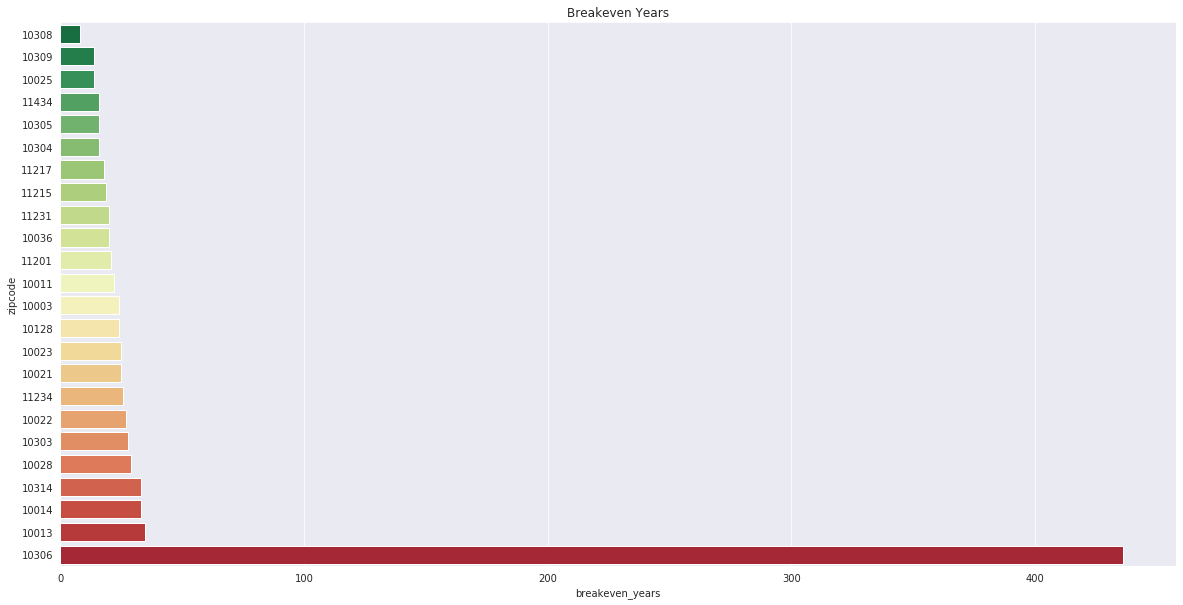

In [339]:
_ = breakeven_years(revenue_df_proc, cost_df_proc)

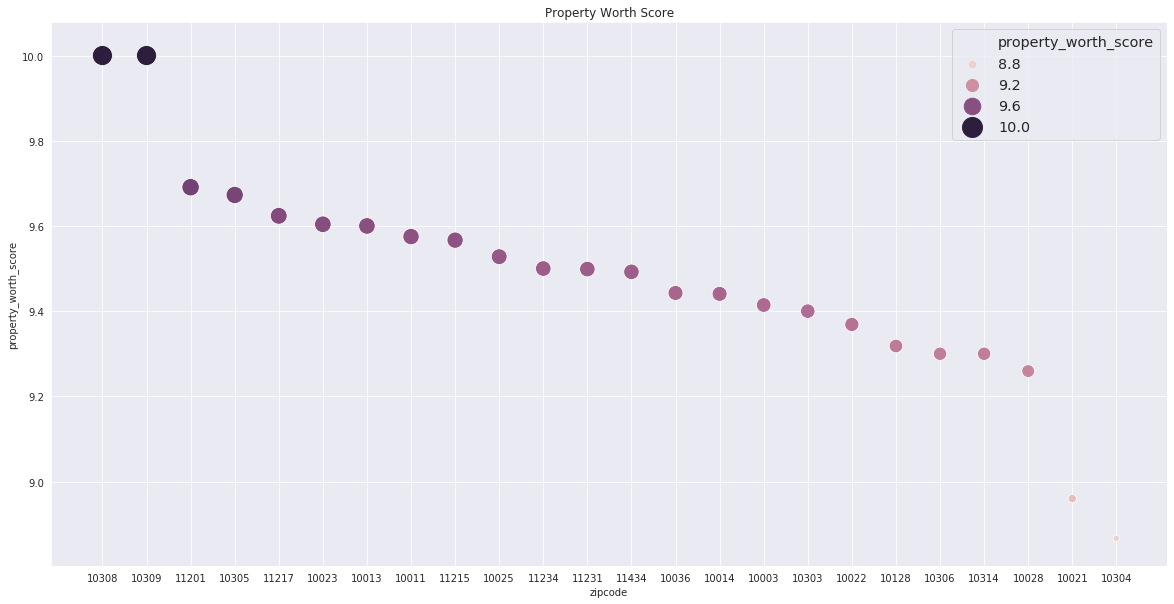

In [340]:
_ = property_worth_score(revenue_df_proc)

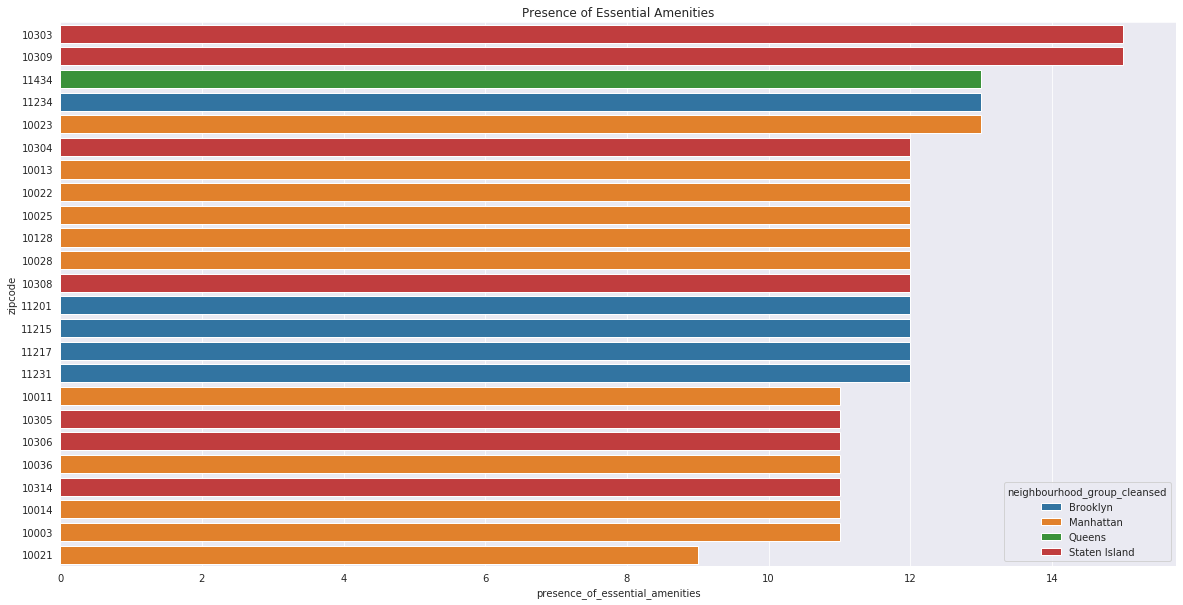

In [342]:
_ = presence_of_essential_amenities(revenue_df_proc)

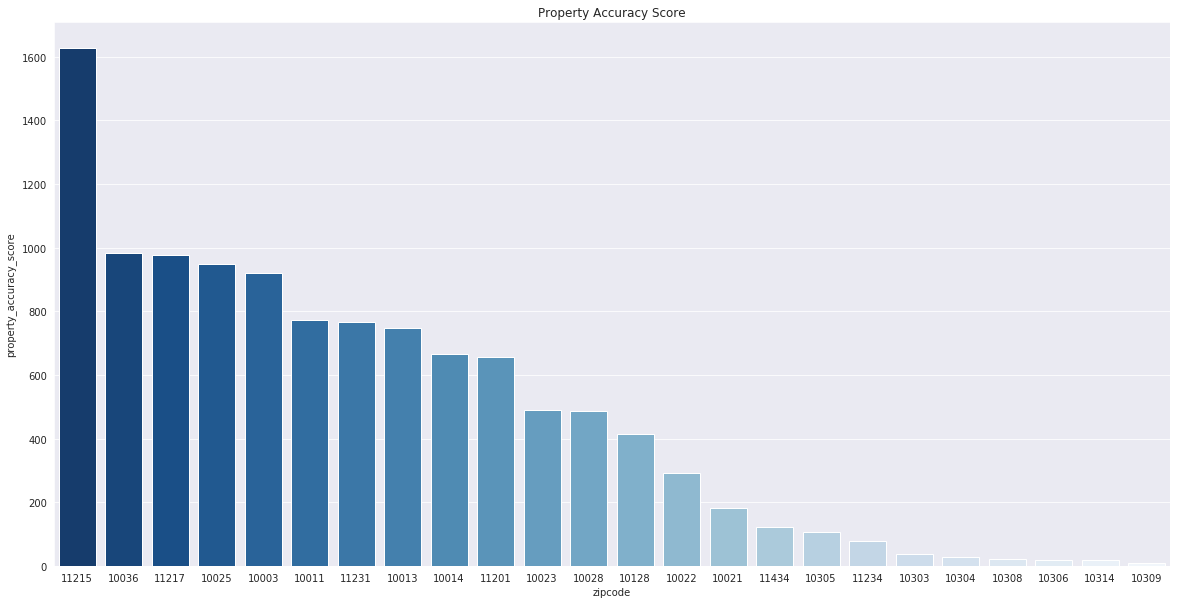

In [341]:
_ = property_accuracy_score(revenue_df_proc)

**RECOMMENDATIONS**

From the metric charts, our top recommendation of zipcodes that are deemed to be profitable are as follows:
    1. 10308 - Staten Island
    2. 10309 - Staten Island
    3. 10305 - Staten Island
    4. 11217 - Brooklyn
    5. 11215 - Brooklyn

Our metric charts tell us that:
    - Zipcodes 10308 annd 10309 have the lowest breakeven years. This means that profits can be generated much earlier than once the no-profit no-loss margin is crossed.
    - Zipcodes 10308 annd 10309 also have the highest property worth score, meaning that from a quantitative perspective (location, value and cleanliness), tenants have voted highly for these properties.
    - Zipcodes 10308 annd 10309 offer guests the highest number of amenities as well.
    - Zipcode 10305 does well on our 1st 3 metrics as well.
    - Zipcodes 11217 and 11215 not only perform decent on the first 3 metrics, but also have properties with the most accurate information. Although, it is to be noted that our property accuracy metric seems to be highly skewed by the shear number of samples. So this metric weighs the least in our decision-making process.
    - All our insights pertaining to the boroughs from the EDA section apply to these zipcodes - eg. Staten Island is one of the least costly places to buy a property. 

**ACTIONS** 

The real-estate firm should perform drill-down analysis to see profitable properties in the respective recommended zipcodes using the metrics described above (preferably through an interactive dashboard interface). Breakeven years should be primary focus while doing so, since the investor would want to generate profits as soon as possible after purchasing a property. Fortunately, the top properties mentioned in the breakeven chart should be less costlier to invest (our EDA earlier had confirmed that Staten Island is the cheapest place to invest).

# Future Works

- Package utility functions in separate modules and possibly piping them (eg: df.pipe in pandas) to create a robust Pandas cleaning pipeline. By splitting the notebook code into modular chunks, it would be easier manage code changes.  
- Create an interactive dashboard for the user via applications like Dash/Plotly to enable the real-estate investor to make optimal data-driven decisions themselves according to their use case  
- Use accurate Reverse Geoencoding services like Google API that can technically impute missing zipcodes
- Perform sentiment analysis of the host' description about the property / tenants reviews about the properties through natural language processing (NLP) to refine the quality and genuineness of the property (but we need more data)
- Hopefully get more data (pertaining to the cost and revenue datasets, eg. getting properties with more distributed NYC zipcodes) to concretely understand about the renting habits in NYC
- Scrape AirBnB listing URL sites with permission to see if we can correct/verify any erroneous data, find zipcode information
- Use predictive modeling to find out how profitable a property would turn out to be in the future in terms of revenue. 
- Forecast median cost price of property (using predictive regression models) for the year 2019, since our revenue dataset seems to have been pulled and prepared in the year 2019. This would allow us to base our recommendations with more certainty. 
- Store historical data about AirBnB and Zillow property prices via big data solutions and technologies revolving around them (eg. data warehousing engines using Hive for batch querying, Kafka + Spark for streaming data)
- Verify if our assumptions hold valid - do more number of reviews imply the property is more profitable? (it could most of the views are just negative in sentiment)
- Refine the conclusions slightly more.